This notebook can be run instead of main.py for ease of use.

In [1]:
# Package Imports

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from torchvision.models import resnet18
import os.path
from tqdm import tqdm
import os
import sys
from pathlib import Path

In [2]:
# Models

class PretrainedClassifier(nn.Module):
    """Initial classifier trained on original data"""
    def __init__(self):
        super().__init__()
        # Input: 28x28
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)  # 28x28 -> 28x28
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)  # 28x28 -> 28x28
        self.pool = nn.MaxPool2d(2, 2)  # 28x28 -> 14x14

        # Size progression:
        # After first pool: 14x14x32
        # After conv2 + pool: 7x7x64
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        # First conv + pool
        x = self.pool(F.relu(self.conv1(x)))  # 28x28 -> 14x14

        # Second conv + pool
        x = self.pool(F.relu(self.conv2(x)))  # 14x14 -> 7x7

        # Flatten and fully connected layers
        x = x.view(-1, 64 * 7 * 7)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

class ImageParaphraser(nn.Module):
    """ResNet-based paraphraser that maximally transforms images while preserving classification"""
    def __init__(self):
        super().__init__()
        # Encoder
        self.encoder = nn.Sequential(
            # Input: 28x28x1
            nn.Conv2d(1, 64, kernel_size=3, padding=1),  # 28x28x64
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.AvgPool2d(2, 2),  # 14x14x64 - Use average pooling instead of max pooling

            # ResNet-style blocks
            self._make_res_block(64, 128),  # 14x14x128
            nn.AvgPool2d(2, 2),  # 7x7x128
            self._make_res_block(128, 256),  # 7x7x256
        )

        # Style embedding
        self.style_linear = nn.Linear(32, 256)

        # Decoder with anti-aliasing
        self.decoder = nn.Sequential(
            # 7x7x256 -> 14x14x128
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),  # Use bilinear upsampling
            nn.Conv2d(256, 128, kernel_size=3, padding=1),  # Anti-aliasing convolution
            nn.BatchNorm2d(128),
            nn.ReLU(),

            # 14x14x128 -> 28x28x64
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            # Smooth final output
            nn.Conv2d(64, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 1, kernel_size=3, padding=1),
            nn.Sigmoid()
        )

    def _make_res_block(self, in_channels, out_channels):
        """Create a ResNet-style block with smoothing"""
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            # Add a small amount of average pooling to suppress high frequencies
            nn.AvgPool2d(kernel_size=3, stride=1, padding=1)
        )

    def forward(self, x):
        batch_size = x.size(0)

        # Generate random style vector
        style = torch.randn(batch_size, 32).to(x.device)
        style = self.style_linear(style)
        style = style.view(batch_size, -1, 1, 1)

        # Encode
        x = self.encoder(x)

        # Add style information (reduced magnitude to prevent artifacts)
        x = x + 0.05 * style.expand(-1, -1, x.size(2), x.size(3))

        # Decode with smoothing
        x = self.decoder(x)

        return x

class InterpretableClassifier(nn.Module):
    """Classifier that outputs interpretable intermediate representations"""
    def __init__(self, num_classes=10):
        super().__init__()
        self.layers = nn.ModuleList([
            # Layer 1: Edge detection and basic feature extraction
            nn.Sequential(
                nn.Conv2d(1, 32, kernel_size=3, padding=1),
                nn.BatchNorm2d(32),
                nn.ReLU(),
                nn.Conv2d(32, 1, kernel_size=3, padding=1),
                nn.Sigmoid()
            ),
            # Layer 2: Pattern recognition
            nn.Sequential(
                nn.Conv2d(1, 64, kernel_size=3, padding=1),
                nn.BatchNorm2d(64),
                nn.ReLU(),
                nn.Conv2d(64, 1, kernel_size=3, padding=1),
                nn.Sigmoid()
            ),
            # Layer 3: Higher-level feature extraction
            nn.Sequential(
                nn.Conv2d(1, 128, kernel_size=3, padding=1),
                nn.BatchNorm2d(128),
                nn.ReLU(),
                nn.Conv2d(128, 1, kernel_size=3, padding=1),
                nn.Sigmoid()
            )
        ])
        
        # Final classification layer
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28 * 28, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )

    def forward(self, x, return_intermediates=False):
        intermediates = []
        current = x
        
        for layer in self.layers:
            current = layer(current)
            intermediates.append(current)
        
        logits = self.classifier(current)
        
        if return_intermediates:
            return logits, intermediates
        return logits

In [3]:
# Train initial classifier

def train_classifier(model, train_loader, test_loader, device, num_epochs=10):
    """Train the initial classifier on original data"""
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    model = model.to(device)  # Ensure model is on correct device
    criterion = criterion.to(device)  # Move loss function to device if needed

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for images, labels in tqdm(train_loader):
            # Move input data to device
            images = images.to(device)
            labels = labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        # Evaluate on test set
        test_acc = evaluate_model(model, test_loader, device)
        print(f'Epoch {epoch+1}: Train Acc: {100*correct/total:.2f}%, Test Acc: {test_acc:.2f}%')


In [4]:
# Train paraphraser

def train_paraphraser(paraphraser, classifier, train_loader, device, num_epochs=2):
    """Train the paraphraser with comprehensive logging"""
    # Ensure models are on the correct device
    paraphraser = paraphraser.to(device)
    classifier = classifier.to(device)
    
    optimizer = optim.Adam(paraphraser.parameters(), lr=0.0001)
    criterion = ParaphrasingLoss(classifier)  # Assuming ParaphrasingLoss handles device internally

    # For logging
    epoch_accuracies = []
    epoch_losses = []
    confusion_matrices = []

    print("\nStarting paraphraser training:")
    print("--------------------------------")

    for epoch in range(num_epochs):
        paraphraser.train()
        running_loss = 0.0
        running_class_loss = 0.0
        running_accuracy = 0.0
        epoch_confusion = torch.zeros(10, 10)  # Initialize on CPU for accumulation
        batch_count = 0

        for images, labels in tqdm(train_loader):
            # Move data to device
            images = images.to(device)
            labels = labels.to(device)
            
            optimizer.zero_grad()

            # Generate paraphrased images
            paraphrased = paraphraser(images)

            # Compute losses and accuracy
            loss, class_loss, accuracy, confusion = criterion(images, paraphrased, labels)
            loss.backward()
            optimizer.step()

            # Accumulate metrics (move confusion matrix to CPU for accumulation)
            running_loss += loss.item()
            running_class_loss += class_loss.item()
            running_accuracy += accuracy
            epoch_confusion += confusion.cpu()
            batch_count += 1

            # Print progress every 100 batches
            if batch_count % 100 == 0:
                print(f"Batch {batch_count}: Loss = {loss.item():.4f}, Accuracy = {accuracy:.1f}%")

        # Compute epoch averages
        avg_loss = running_loss / batch_count
        avg_class_loss = running_class_loss / batch_count
        avg_accuracy = running_accuracy / batch_count

        # Store metrics
        epoch_accuracies.append(avg_accuracy)
        epoch_losses.append(avg_loss)
        confusion_matrices.append(epoch_confusion)

        # Print epoch summary
        print(f"\nEpoch {epoch+1}/{num_epochs}:")
        print(f"Average Loss: {avg_loss:.4f}")
        print(f"Classification Loss: {avg_class_loss:.4f}")
        print(f"Average Classification Accuracy: {avg_accuracy:.1f}%")

        # Display confusion matrix
        print("\nConfusion Matrix (True vs Predicted):")
        confusion_matrix = epoch_confusion.numpy()
        row_sums = confusion_matrix.sum(axis=1, keepdims=True)
        normalized_confusion = 100 * confusion_matrix / row_sums  # percentage scores

        # Print normalized confusion matrix
        print("\nNormalized Confusion Matrix (%):")
        print("    ", end="")
        for i in range(10):
            print(f"{i:5d}", end="")
        print("\n" + "-" * 60)

        for i in range(10):
            print(f"{i:2d} |", end="")
            for j in range(10):
                print(f"{normalized_confusion[i,j]:5.1f}", end="")  # i is true, j is predicted
            print(f" | {confusion_matrix[i].sum():.0f}")
        print("-" * 60)

        # Plot confusion matrix
        fig = plt.imshow(normalized_confusion, cmap='viridis', interpolation='nearest', origin='lower')
        plt.colorbar(fig)
        plt.title('Confusion on Paraphrased Images')
        plt.xlabel('True Class')
        plt.ylabel('Predicted Class')
        plt.show()

        # Visualize examples
        visualize_paraphrasing(paraphraser, train_loader, device, num_samples=10)

    # Plot training progress
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epoch_losses)
    plt.title('Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')

    plt.subplot(1, 2, 2)
    plt.plot(epoch_accuracies)
    plt.title('Classification Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')

    plt.tight_layout()
    plt.show()

    return epoch_accuracies, epoch_losses, confusion_matrices

In [5]:
# Train interpretable classifier

def train_interpretable_classifier(model, paraphraser, train_loader, test_loader, 
                                 paraphrase_prob=1.0, num_epochs=5, device='cuda', save_dir=None):
    """
    Train the interpretable classifier. Probabilistically paraphrases input and intermediate model states.
    """
    model = model.to(device)
    paraphraser = paraphraser.to(device)
    criterion = nn.CrossEntropyLoss().to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    metrics_log = {
        'paraphrase_prob': paraphrase_prob,
        'train_acc': [],
        'train_loss': [],
        'test_acc': [],
        'batch_metrics': {
            'loss': [],
            'acc': []
        },
        'layer_metrics': {i: {'mse': [], 'cosine_sim': [], 'was_paraphrased': []} 
                         for i in range(len(model.layers) + 1)}  # +1 for input layer
    }
    
    best_acc = 0.0
    
    print(f"\nTraining with paraphrase probability: {paraphrase_prob * 100:.1f}%")
    
    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0.0
        correct = 0
        total = 0
        batch_count = 0
        layer_diffs = [[] for _ in range(len(model.layers) + 1)]  # +1 for input layer

        for batch_idx, (images, labels) in enumerate(tqdm(train_loader)):
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            
            # Handle input paraphrasing
            was_input_paraphrased = np.random.random() < paraphrase_prob
            if was_input_paraphrased:
                with torch.no_grad():
                    current = paraphraser(images)
                # Calculate metrics between original and paraphrased input
                mse = F.mse_loss(images, current).item()
                cosine_sim = F.cosine_similarity(images.view(images.size(0), -1),
                                               current.view(current.size(0), -1),
                                               dim=1).mean().item()
            else:
                current = images
                mse = 0.0  # No paraphrasing occurred
                cosine_sim = 1.0  # Identity mapping
            
            # Store input layer metrics
            layer_diffs[0].append({
                'mse': mse, 
                'cosine_sim': cosine_sim,
                'was_paraphrased': was_input_paraphrased
            })
            
            # Forward pass tracking intermediates
            intermediates = []
            paraphrased_intermediates = []
            layer_originals = []  # Store original outputs for visualization
            
            # Process through each layer with probabilistic paraphrasing
            for i, layer in enumerate(model.layers, 1):  # Start from 1 since 0 is input
                # Get layer output
                current = layer(current)
                layer_originals.append(current.clone())  # Store original layer output
                
                # Probabilistically apply paraphrasing
                was_paraphrased = np.random.random() < paraphrase_prob
                if was_paraphrased:
                    with torch.no_grad():
                        paraphrased = paraphraser(current)
                    # Calculate metrics only if paraphrasing occurred
                    mse = F.mse_loss(current, paraphrased).item()
                    cosine_sim = F.cosine_similarity(current.view(current.size(0), -1),
                                                   paraphrased.view(paraphrased.size(0), -1),
                                                   dim=1).mean().item()
                else:
                    paraphrased = current
                    mse = 0.0  # No paraphrasing occurred
                    cosine_sim = 1.0  # Identity mapping
                
                intermediates.append(current)
                paraphrased_intermediates.append(paraphrased)
                
                layer_diffs[i].append({
                    'mse': mse, 
                    'cosine_sim': cosine_sim,
                    'was_paraphrased': was_paraphrased
                })
                
                current = paraphrased
            
            # Final classification
            logits = model.classifier(current)
            
            # Calculate loss
            class_loss = criterion(logits, labels)
            reg_loss = sum(F.mse_loss(inter, para) 
                          for inter, para in zip(intermediates, paraphrased_intermediates))
            
            total_loss = class_loss + 0.1 * reg_loss
            total_loss.backward()
            optimizer.step()

            # Update metrics
            batch_loss = total_loss.item()
            epoch_loss += batch_loss
            _, predicted = torch.max(logits.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            batch_count += 1

            # Store batch-level metrics
            metrics_log['batch_metrics']['loss'].append(batch_loss)
            metrics_log['batch_metrics']['acc'].append(100 * (predicted == labels).sum().item() / labels.size(0))

            if batch_idx % 400 == 0:  # Reduced frequency for more meaningful plots
                visualize_intermediates(
                    original_input=images,
                    paraphrased_input=current if was_input_paraphrased else None,
                    layer_originals=layer_originals,
                    layer_paraphrased=paraphrased_intermediates,
                    layer_diffs=layer_diffs,
                    epoch=epoch,
                    batch_idx=batch_idx
                )
                
                # Log layer statistics
                for i in range(len(model.layers) + 1):
                    layer_metrics = layer_diffs[i][-100:]  # Use last 100 batches
                    metrics_log['layer_metrics'][i]['mse'].append(
                        np.mean([m['mse'] for m in layer_metrics]))
                    metrics_log['layer_metrics'][i]['cosine_sim'].append(
                        np.mean([m['cosine_sim'] for m in layer_metrics]))
                    metrics_log['layer_metrics'][i]['was_paraphrased'].append(
                        np.mean([m['was_paraphrased'] for m in layer_metrics]))
                    
                print(f'\nLayer Statistics (Paraphrase Prob: {paraphrase_prob * 100:.1f}%):')
                for i in range(len(model.layers) + 1):
                    layer_name = "Input" if i == 0 else f"Layer {i}"
                    paraphrase_rate = np.mean([m['was_paraphrased'] for m in layer_diffs[i][-100:]])
                    print(f'{layer_name}:')
                    print(f'  MSE: {metrics_log["layer_metrics"][i]["mse"][-1]:.4f}')
                    print(f'  Cosine Similarity: {metrics_log["layer_metrics"][i]["cosine_sim"][-1]:.4f}')
                    print(f'  Actual Paraphrase Rate: {paraphrase_rate * 100:.1f}%')

        # Epoch-level metrics
        train_acc = 100 * correct / total
        train_loss = epoch_loss / batch_count
        test_acc = evaluate_model(model, test_loader, device)
        
        metrics_log['train_acc'].append(train_acc)
        metrics_log['train_loss'].append(train_loss)
        metrics_log['test_acc'].append(test_acc)
        
        print(f'\nEpoch {epoch+1} (Paraphrase Prob: {paraphrase_prob * 100:.1f}%):')
        print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, Test Acc: {test_acc:.2f}%')
        
        # Plot training progress
        plot_training_progress(metrics_log)
        
        # Save best model if specified
        if save_dir and test_acc > best_acc:
            best_acc = test_acc
            save_path = Path(save_dir) / f'interpretable_classifier_p{paraphrase_prob:.2f}.pth'
            torch.save(model.state_dict(), save_path)
    
    return metrics_log


In [6]:
# Paraphraser loss function

class ParaphrasingLoss(nn.Module):
    """Simplified loss function focused on classification preservation with moderate transformation"""
    def __init__(self, classifier, classification_weight=5.0, transform_weight=0.5):
        super().__init__()
        self.classifier = classifier
        self.classification_weight = classification_weight
        self.transform_weight = transform_weight

    def forward(self, original, paraphrased, true_labels):
        # Classification preservation using original classifier
        with torch.no_grad():
            original_logits = self.classifier(original)
        paraphrased_logits = self.classifier(paraphrased)

        classification_loss = F.cross_entropy(paraphrased_logits, true_labels)

        # Simple L2 difference to encourage moderate transformation
        transform_loss = -F.mse_loss(original, paraphrased)  # Negative because we want some difference

        # Total loss
        total_loss = (self.classification_weight * classification_loss +
                     self.transform_weight * transform_loss)

        # For logging: compute classification accuracy
        with torch.no_grad():
            _, predicted = torch.max(paraphrased_logits, 1)
            correct = (predicted == true_labels).sum().item()
            total = true_labels.size(0)
            accuracy = 100 * correct / total

            # Get confusion matrix data
            confusion = torch.zeros(10, 10, device=original.device)
            for t, p in zip(true_labels, predicted):
                confusion[t.item(), p.item()] += 1

        return total_loss, classification_loss, accuracy, confusion


In [7]:
# Visualisation and evaluation

def visualize_paraphrasing(paraphraser, train_loader, device, num_samples=10):
    """Helper function to visualize paraphrased images"""
    # Get a batch of images
    images, _ = next(iter(train_loader))
    images = images[:num_samples].to(device)
    
    # Generate paraphrased images
    with torch.no_grad():
        paraphrased = paraphraser(images)
    
    # Move tensors to CPU for visualization
    original_images = images.cpu()
    paraphrased_images = paraphrased.cpu()
    
    # Plot original vs paraphrased
    plt.figure(figsize=(20, 4))
    for i in range(num_samples):
        # Original
        plt.subplot(2, num_samples, i + 1)
        plt.imshow(original_images[i].squeeze(), cmap='gray')
        plt.axis('off')
        if i == 0:
            plt.title('Original')
        
        # Paraphrased
        plt.subplot(2, num_samples, num_samples + i + 1)
        plt.imshow(paraphrased_images[i].squeeze(), cmap='gray')
        plt.axis('off')
        if i == 0:
            plt.title('Paraphrased')
    
    plt.tight_layout()
    plt.show()

def evaluate_model(model, test_loader, device):
    """Evaluate model on test set"""
    model.eval()
    correct = 0
    total = 0
    
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    return 100 * correct / total

def visualize_intermediates(original_input, paraphrased_input, layer_originals, 
                          layer_paraphrased, layer_diffs, epoch, batch_idx, num_samples=1):
    """
    Visualize random sample of images, their intermediate representations, and paraphrased versions.
    Clearly indicates which versions were actually paraphrased vs copied.
    """
    # Set num_samples to 1 for brevity of output. Including a large number of samples gives better visibility over training
    batch_size = original_input.size(0)
    indices = torch.randperm(batch_size)[:num_samples]
    
    for idx in indices:
        num_cols = len(layer_originals) + 1  # +1 for input
        plt.figure(figsize=(3 * num_cols, 6))
        
        # Original input
        plt.subplot(2, num_cols, 1)
        plt.imshow(original_input[idx].cpu().squeeze(), cmap='gray')
        plt.title('Original Input')
        plt.axis('off')
        
        # Input paraphrasing status and visualization
        was_paraphrased = layer_diffs[0][-1]['was_paraphrased']
        status = "Paraphrased" if was_paraphrased else "Original"
        plt.subplot(2, num_cols, num_cols + 1)
        
        # Show either paraphrased input or original depending on whether paraphrasing occurred
        display_input = paraphrased_input if was_paraphrased else original_input
        plt.imshow(display_input[idx].detach().cpu().squeeze(), cmap='gray')
        plt.title(f'Input ({status})')
        plt.axis('off')
        
        # Layer outputs and their paraphrased versions
        for i, (orig, para) in enumerate(zip(layer_originals, layer_paraphrased)):
            # Original layer output
            plt.subplot(2, num_cols, i + 2)
            plt.imshow(orig[idx].detach().cpu().squeeze(), cmap='gray')
            plt.title(f'Layer {i+1}')
            plt.axis('off')
            
            # Paraphrasing status for this layer
            was_paraphrased = layer_diffs[i+1][-1]['was_paraphrased']
            status = "Paraphrased" if was_paraphrased else "Original"
            
            # Paraphrased or original version
            plt.subplot(2, num_cols, num_cols + i + 2)
            plt.imshow(para[idx].detach().cpu().squeeze(), cmap='gray')
            plt.title(f'L{i+1} ({status})')
            plt.axis('off')
        
        plt.suptitle(f'Epoch {epoch+1}, Step {batch_idx}, Sample {idx.item()}')
        plt.tight_layout()
        plt.show()

def compare_training_results(metrics_logs):
    """Compare and visualize results from different paraphrasing probabilities"""
    plt.figure(figsize=(15, 10))
    
    # Plot test accuracy comparison
    plt.subplot(2, 2, 1)
    for metrics in metrics_logs:
        prob = metrics['paraphrase_prob']
        plt.plot(metrics['test_acc'], label=f'Prob={prob:.1f}')
    plt.title('Test Accuracy Comparison')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    
    # Plot average MSE per layer
    plt.subplot(2, 2, 2)
    for metrics in metrics_logs:
        prob = metrics['paraphrase_prob']
        layer_mses = []
        for layer in range(len(metrics['layer_metrics'])):
            avg_mse = np.mean(metrics['layer_metrics'][layer]['mse'])
            layer_mses.append(avg_mse)
        plt.plot(layer_mses, marker='o', label=f'Prob={prob:.1f}')
    plt.title('Average MSE by Layer')
    plt.xlabel('Layer')
    plt.ylabel('MSE')
    plt.legend()
    
    # Plot average cosine similarity per layer
    plt.subplot(2, 2, 3)
    for metrics in metrics_logs:
        prob = metrics['paraphrase_prob']
        layer_cos = []
        for layer in range(len(metrics['layer_metrics'])):
            avg_cos = np.mean(metrics['layer_metrics'][layer]['cosine_sim'])
            layer_cos.append(avg_cos)
        plt.plot(layer_cos, marker='o', label=f'Prob={prob:.1f}')
    plt.title('Average Cosine Similarity by Layer')
    plt.xlabel('Layer')
    plt.ylabel('Cosine Similarity')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

In [8]:
# Plot training progress

def plot_training_progress(metrics_log):
    """Plot detailed training metrics including per-batch information"""
    plt.figure(figsize=(15, 10))
    
    # Plot loss
    plt.subplot(2, 2, 1)
    plt.plot(metrics_log['batch_metrics']['loss'], label='Batch Loss', alpha=0.3)
    # Add smoothed version
    window = min(50, len(metrics_log['batch_metrics']['loss']))
    if window > 0:
        smoothed = np.convolve(metrics_log['batch_metrics']['loss'], 
                             np.ones(window)/window, mode='valid')
        plt.plot(smoothed, label='Smoothed Loss', linewidth=2)
    plt.title('Training Loss')
    plt.xlabel('Batch')
    plt.ylabel('Loss')
    plt.legend()
    
    # Plot accuracies
    plt.subplot(2, 2, 2)
    plt.plot(metrics_log['batch_metrics']['acc'], label='Batch Accuracy', alpha=0.3)
    # Add smoothed version
    if window > 0:
        smoothed = np.convolve(metrics_log['batch_metrics']['acc'], 
                             np.ones(window)/window, mode='valid')
        plt.plot(smoothed, label='Smoothed Accuracy', linewidth=2)
    plt.plot(np.arange(0, len(metrics_log['batch_metrics']['acc']), 
                      len(metrics_log['batch_metrics']['acc'])//len(metrics_log['test_acc'])),
             metrics_log['test_acc'], label='Test Accuracy', linewidth=2)
    plt.title('Accuracy')
    plt.xlabel('Batch')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    
    # Plot paraphrasing rates
    plt.subplot(2, 2, 3)
    for i in range(len(metrics_log['layer_metrics'])):
        layer_name = "Input" if i == 0 else f"Layer {i}"
        rates = metrics_log['layer_metrics'][i]['was_paraphrased']
        plt.plot(rates, label=layer_name)
    plt.title('Actual Paraphrasing Rates')
    plt.xlabel('Update Step')
    plt.ylabel('Rate')
    plt.legend()
    
    plt.tight_layout()
    plt.show()


Using device: cpu


C:\Users\plogo\AppData\Local\Temp\ipykernel_9364\2467918024.py:37: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  classifier.load_state_dict(torch.load(classifier_path, map_l

Loading pretrained classifier...
Loading pretrained paraphraser...

Training classifier with 0.0% paraphrasing probability

Training with paraphrase probability: 0.0%


  0%|          | 0/938 [00:00<?, ?it/s]

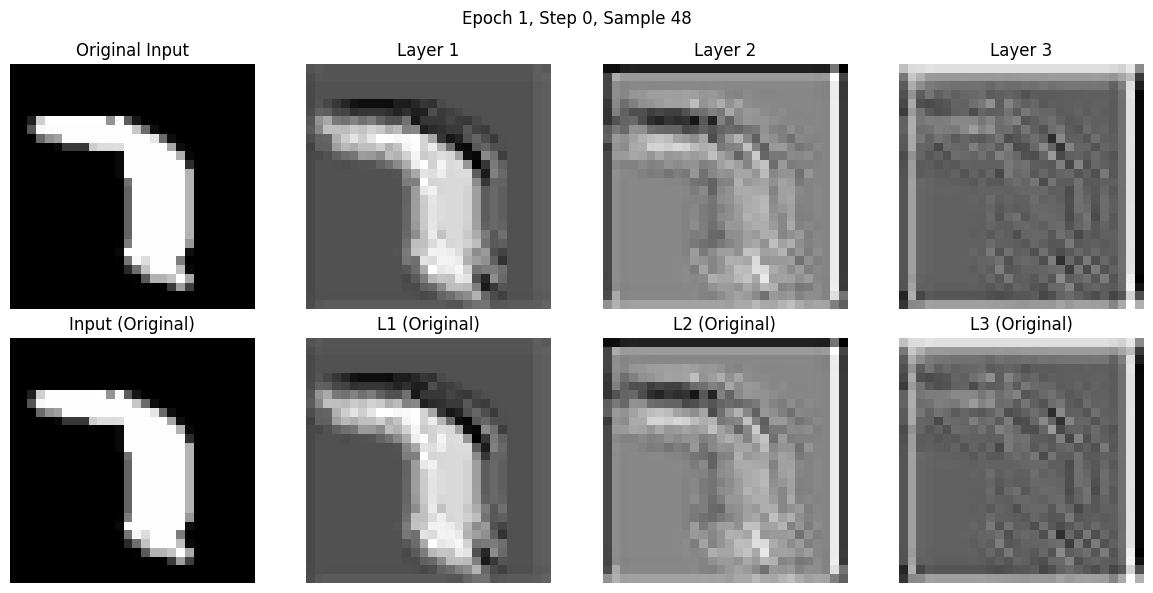

  0%|          | 1/938 [00:13<3:29:26, 13.41s/it]


Layer Statistics (Paraphrase Prob: 0.0%):
Input:
  MSE: 0.0000
  Cosine Similarity: 1.0000
  Actual Paraphrase Rate: 0.0%
Layer 1:
  MSE: 0.0000
  Cosine Similarity: 1.0000
  Actual Paraphrase Rate: 0.0%
Layer 2:
  MSE: 0.0000
  Cosine Similarity: 1.0000
  Actual Paraphrase Rate: 0.0%
Layer 3:
  MSE: 0.0000
  Cosine Similarity: 1.0000
  Actual Paraphrase Rate: 0.0%


 43%|████▎     | 400/938 [02:25<02:52,  3.11it/s]

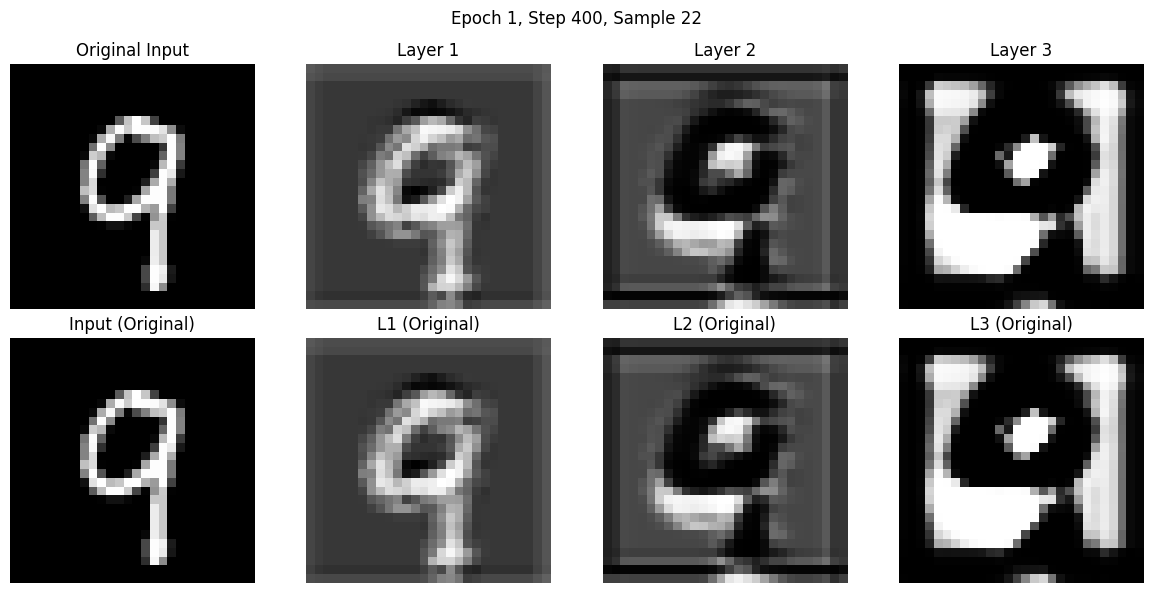

 43%|████▎     | 401/938 [02:27<05:08,  1.74it/s]


Layer Statistics (Paraphrase Prob: 0.0%):
Input:
  MSE: 0.0000
  Cosine Similarity: 1.0000
  Actual Paraphrase Rate: 0.0%
Layer 1:
  MSE: 0.0000
  Cosine Similarity: 1.0000
  Actual Paraphrase Rate: 0.0%
Layer 2:
  MSE: 0.0000
  Cosine Similarity: 1.0000
  Actual Paraphrase Rate: 0.0%
Layer 3:
  MSE: 0.0000
  Cosine Similarity: 1.0000
  Actual Paraphrase Rate: 0.0%


 85%|████████▌ | 800/938 [04:38<00:44,  3.08it/s]

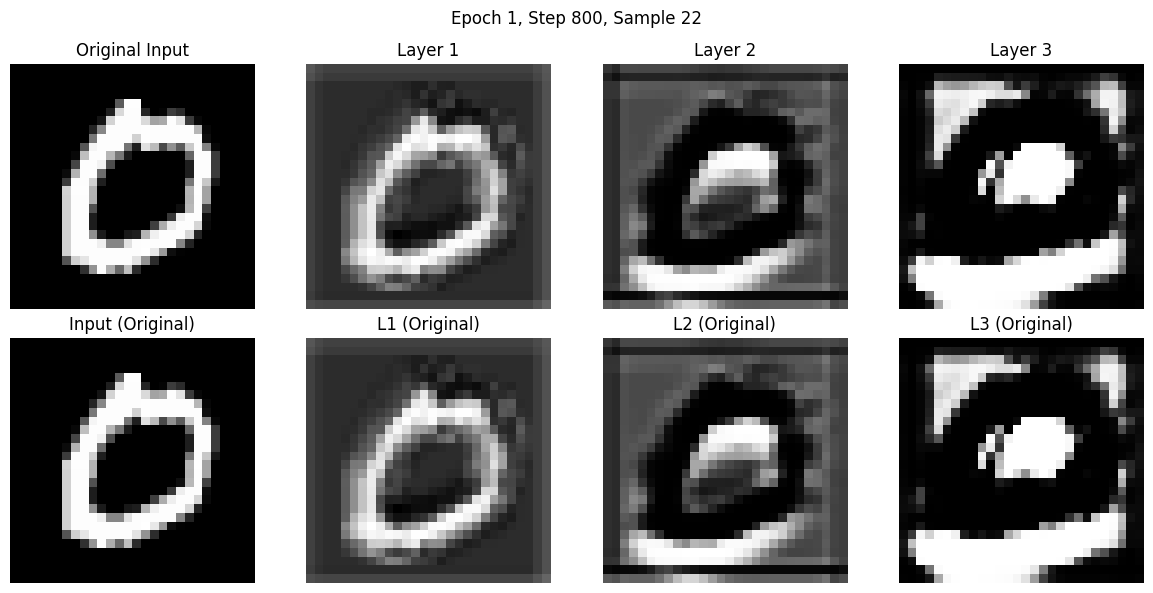

 85%|████████▌ | 801/938 [04:39<01:14,  1.83it/s]


Layer Statistics (Paraphrase Prob: 0.0%):
Input:
  MSE: 0.0000
  Cosine Similarity: 1.0000
  Actual Paraphrase Rate: 0.0%
Layer 1:
  MSE: 0.0000
  Cosine Similarity: 1.0000
  Actual Paraphrase Rate: 0.0%
Layer 2:
  MSE: 0.0000
  Cosine Similarity: 1.0000
  Actual Paraphrase Rate: 0.0%
Layer 3:
  MSE: 0.0000
  Cosine Similarity: 1.0000
  Actual Paraphrase Rate: 0.0%


100%|██████████| 938/938 [05:28<00:00,  2.85it/s]



Epoch 1 (Paraphrase Prob: 0.0%):
Train Loss: 0.4285, Train Acc: 86.75%, Test Acc: 96.08%


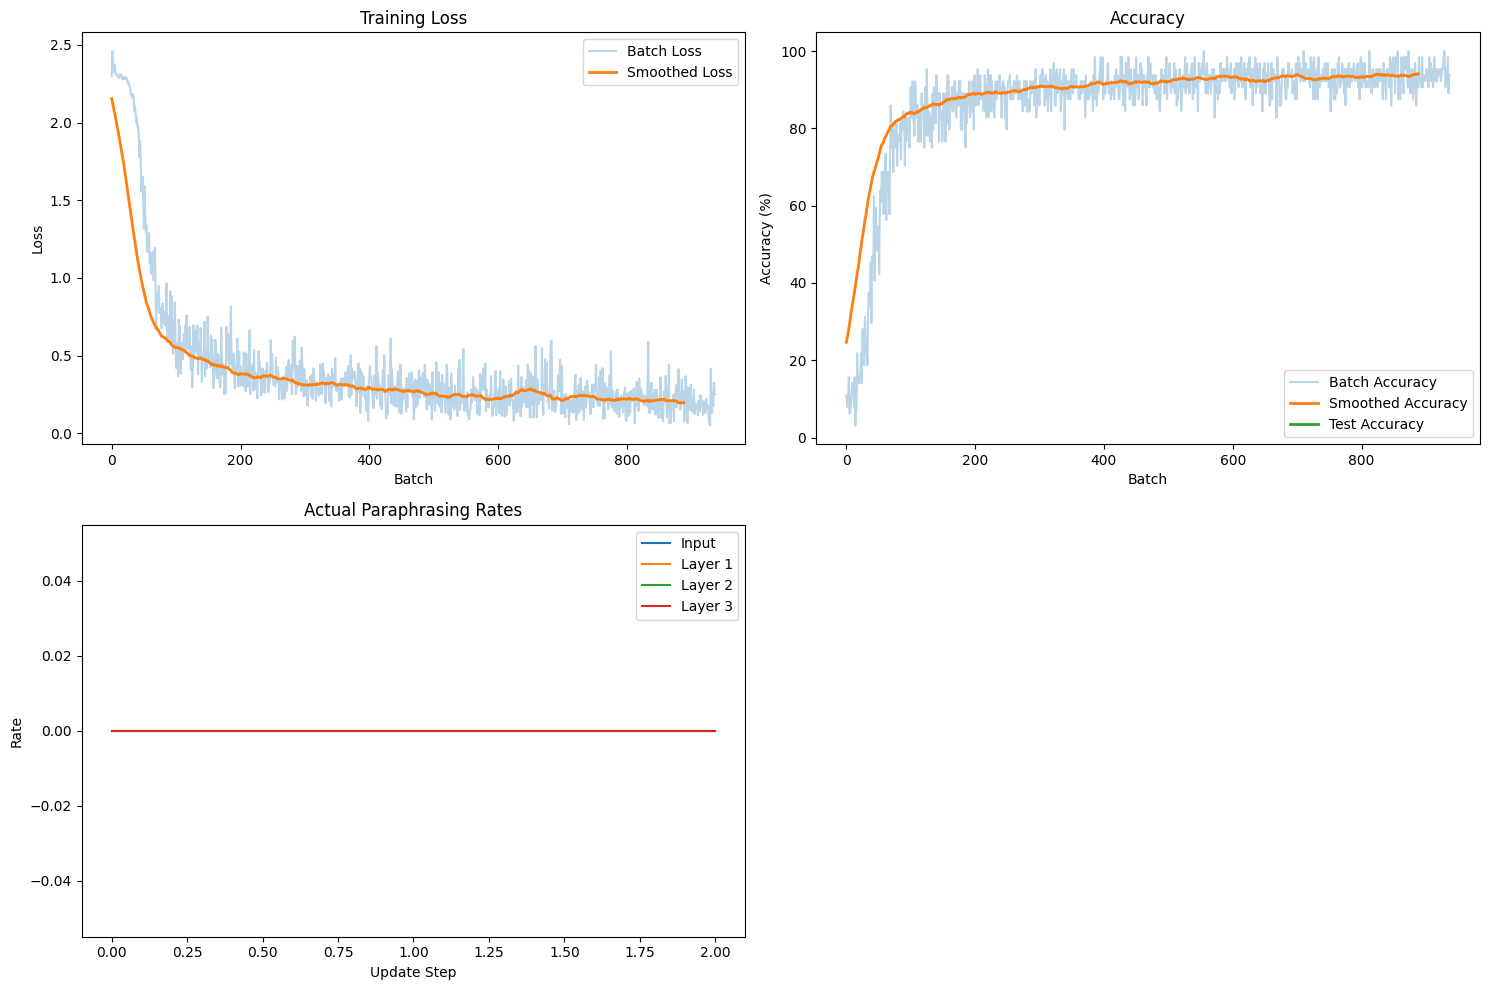

  0%|          | 0/938 [00:00<?, ?it/s]

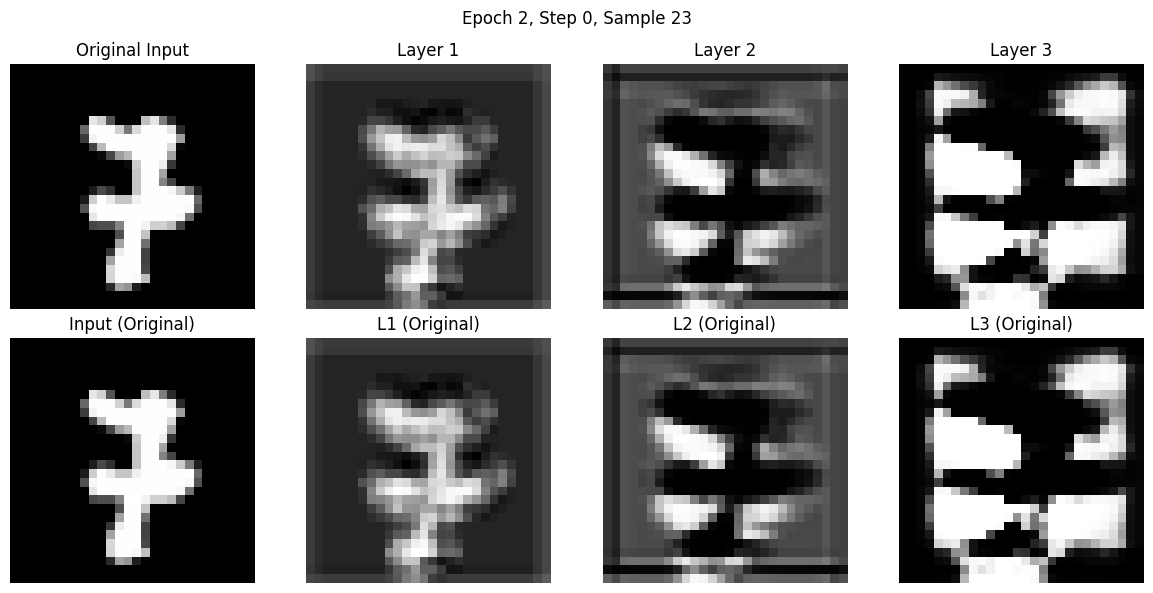

  0%|          | 1/938 [00:09<2:32:36,  9.77s/it]


Layer Statistics (Paraphrase Prob: 0.0%):
Input:
  MSE: 0.0000
  Cosine Similarity: 1.0000
  Actual Paraphrase Rate: 0.0%
Layer 1:
  MSE: 0.0000
  Cosine Similarity: 1.0000
  Actual Paraphrase Rate: 0.0%
Layer 2:
  MSE: 0.0000
  Cosine Similarity: 1.0000
  Actual Paraphrase Rate: 0.0%
Layer 3:
  MSE: 0.0000
  Cosine Similarity: 1.0000
  Actual Paraphrase Rate: 0.0%


 43%|████▎     | 400/938 [02:23<02:53,  3.10it/s]

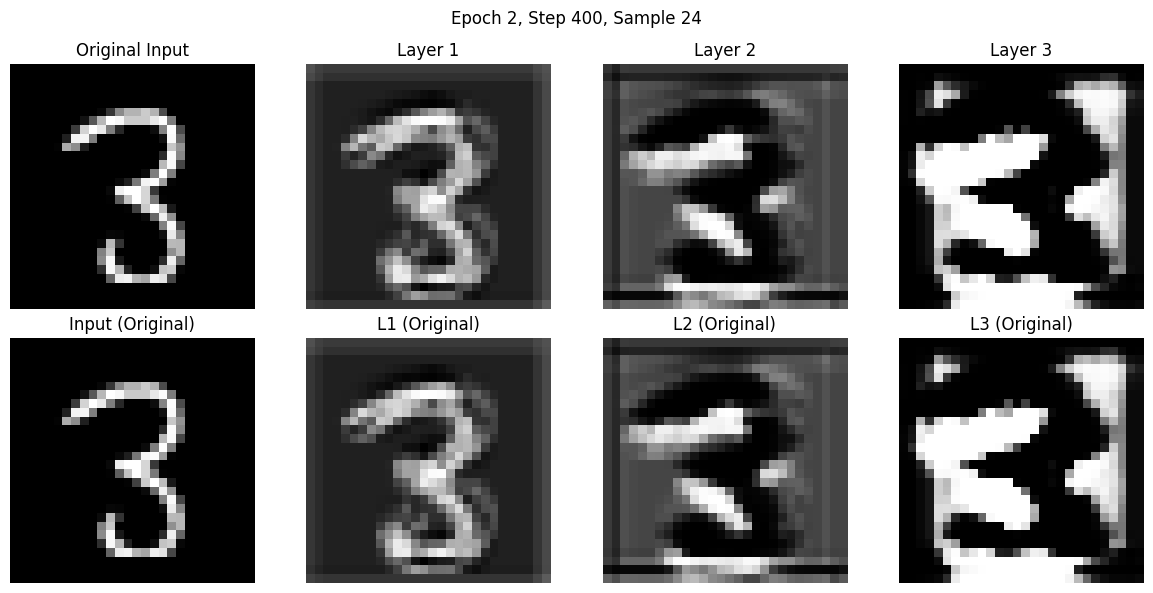

 43%|████▎     | 401/938 [02:23<04:20,  2.06it/s]


Layer Statistics (Paraphrase Prob: 0.0%):
Input:
  MSE: 0.0000
  Cosine Similarity: 1.0000
  Actual Paraphrase Rate: 0.0%
Layer 1:
  MSE: 0.0000
  Cosine Similarity: 1.0000
  Actual Paraphrase Rate: 0.0%
Layer 2:
  MSE: 0.0000
  Cosine Similarity: 1.0000
  Actual Paraphrase Rate: 0.0%
Layer 3:
  MSE: 0.0000
  Cosine Similarity: 1.0000
  Actual Paraphrase Rate: 0.0%


 85%|████████▌ | 800/938 [04:36<00:43,  3.17it/s]

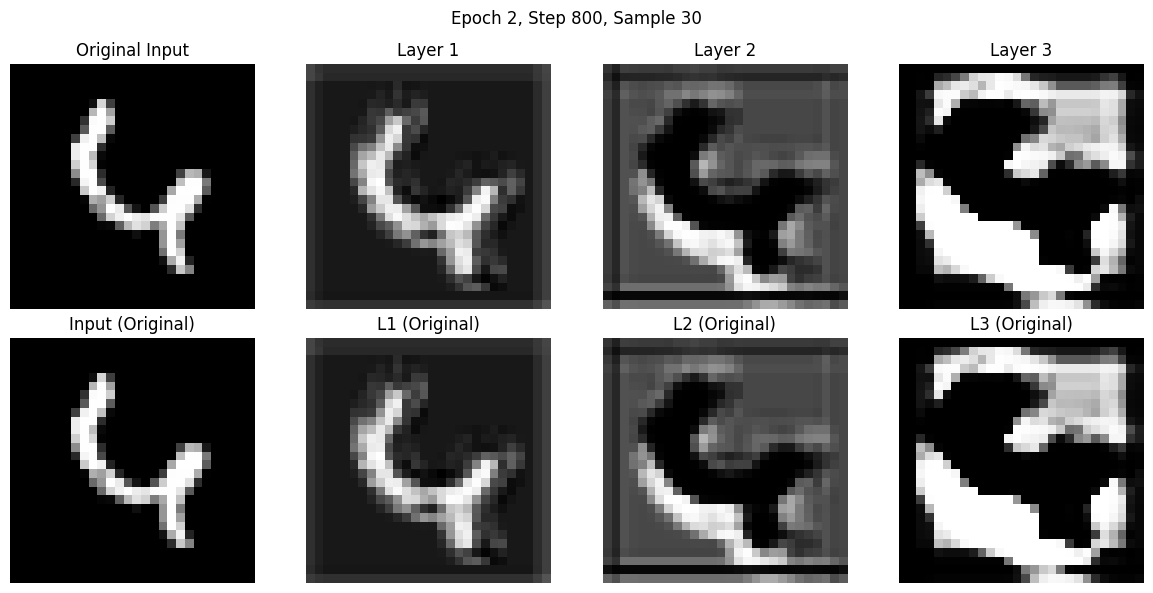

 85%|████████▌ | 801/938 [04:38<01:28,  1.55it/s]


Layer Statistics (Paraphrase Prob: 0.0%):
Input:
  MSE: 0.0000
  Cosine Similarity: 1.0000
  Actual Paraphrase Rate: 0.0%
Layer 1:
  MSE: 0.0000
  Cosine Similarity: 1.0000
  Actual Paraphrase Rate: 0.0%
Layer 2:
  MSE: 0.0000
  Cosine Similarity: 1.0000
  Actual Paraphrase Rate: 0.0%
Layer 3:
  MSE: 0.0000
  Cosine Similarity: 1.0000
  Actual Paraphrase Rate: 0.0%


100%|██████████| 938/938 [05:23<00:00,  2.90it/s]



Epoch 2 (Paraphrase Prob: 0.0%):
Train Loss: 0.1805, Train Acc: 94.79%, Test Acc: 96.59%


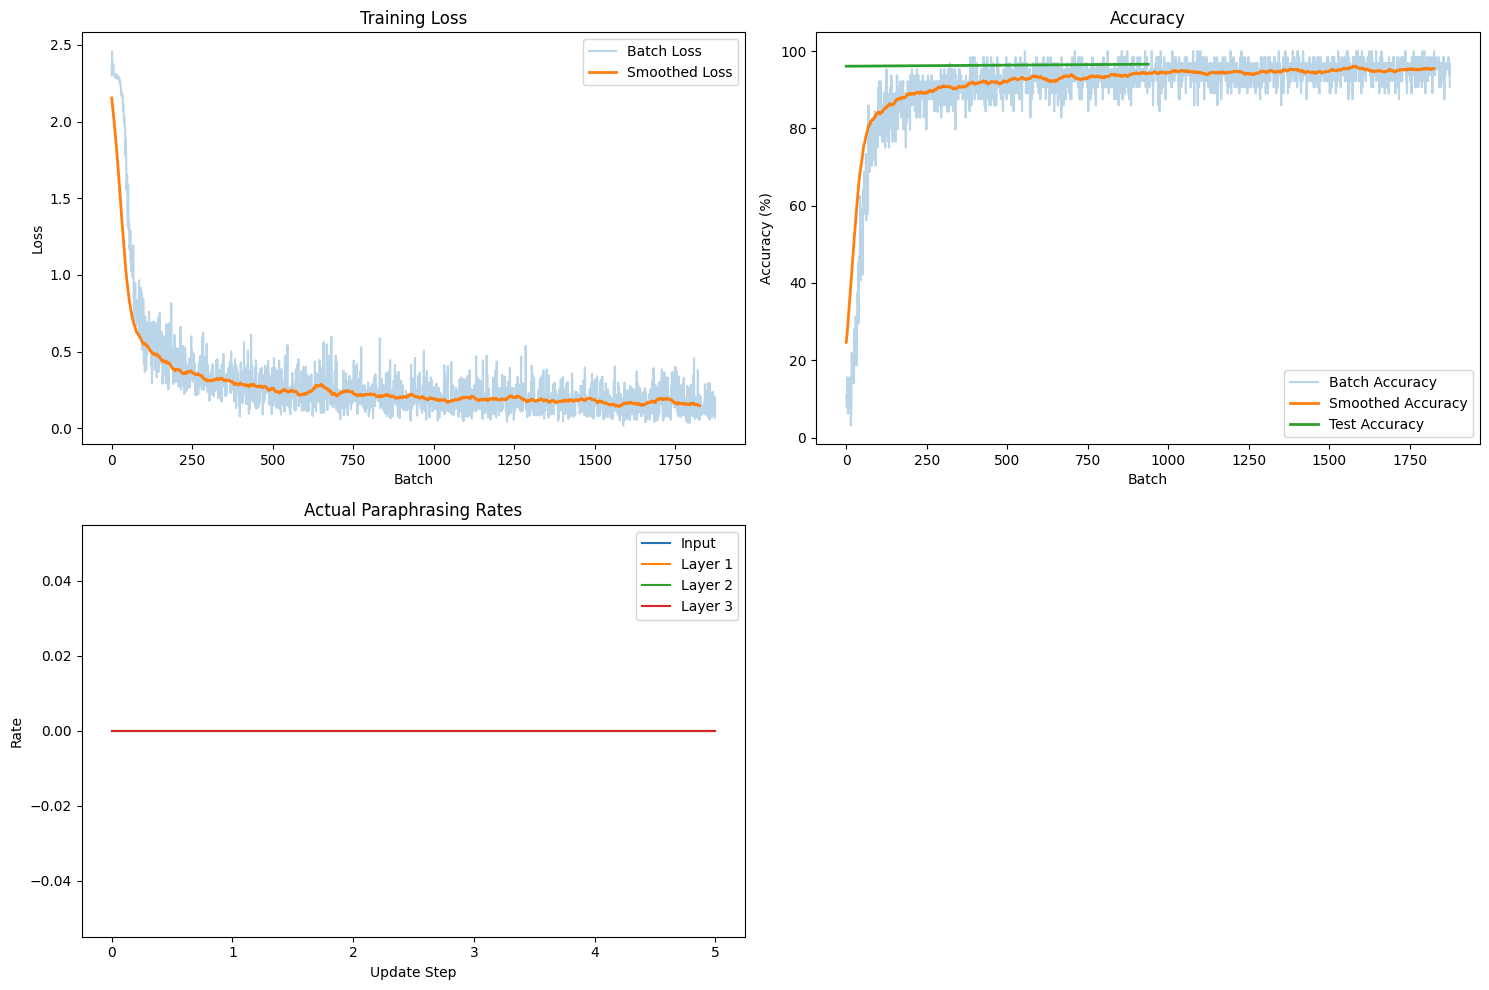

  0%|          | 0/938 [00:00<?, ?it/s]

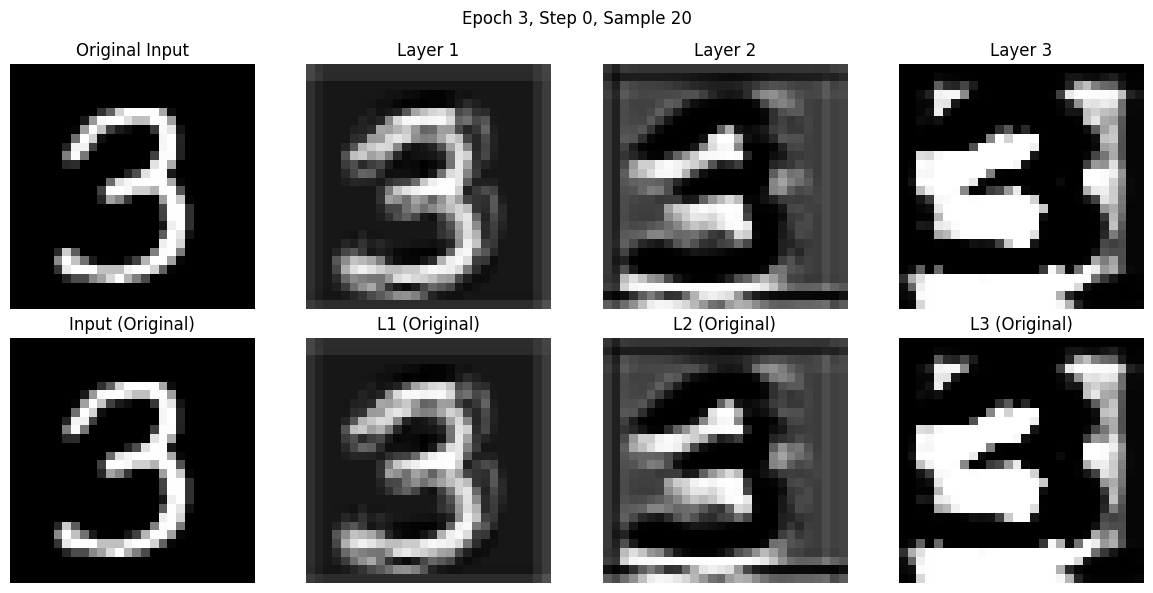

  0%|          | 1/938 [00:10<2:51:14, 10.97s/it]


Layer Statistics (Paraphrase Prob: 0.0%):
Input:
  MSE: 0.0000
  Cosine Similarity: 1.0000
  Actual Paraphrase Rate: 0.0%
Layer 1:
  MSE: 0.0000
  Cosine Similarity: 1.0000
  Actual Paraphrase Rate: 0.0%
Layer 2:
  MSE: 0.0000
  Cosine Similarity: 1.0000
  Actual Paraphrase Rate: 0.0%
Layer 3:
  MSE: 0.0000
  Cosine Similarity: 1.0000
  Actual Paraphrase Rate: 0.0%


 43%|████▎     | 400/938 [02:21<02:53,  3.10it/s]

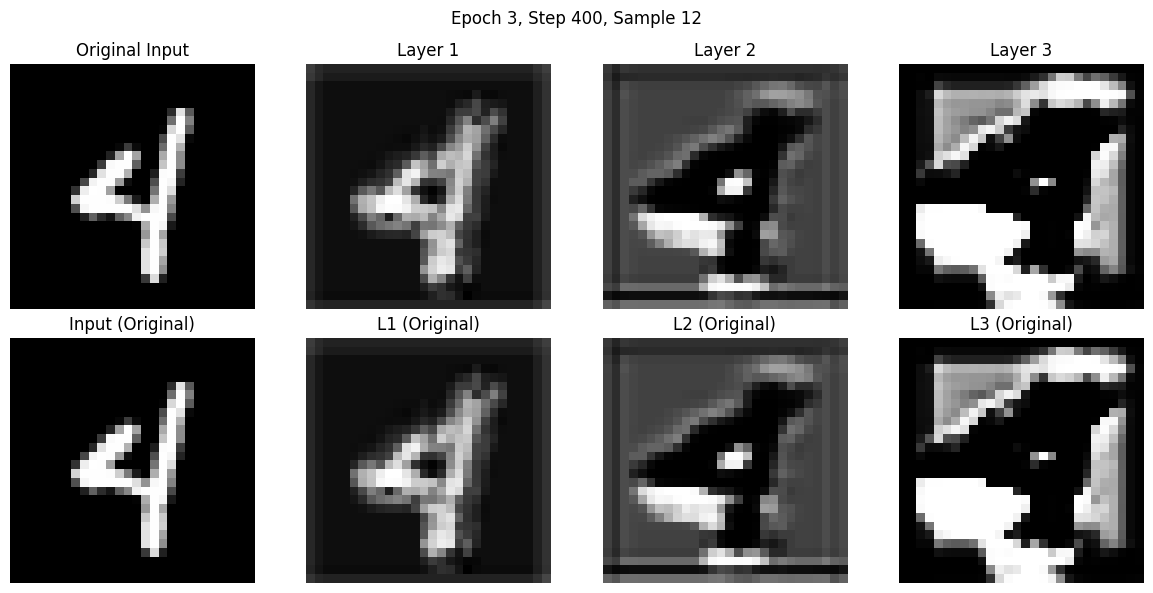

 43%|████▎     | 401/938 [02:22<04:20,  2.06it/s]


Layer Statistics (Paraphrase Prob: 0.0%):
Input:
  MSE: 0.0000
  Cosine Similarity: 1.0000
  Actual Paraphrase Rate: 0.0%
Layer 1:
  MSE: 0.0000
  Cosine Similarity: 1.0000
  Actual Paraphrase Rate: 0.0%
Layer 2:
  MSE: 0.0000
  Cosine Similarity: 1.0000
  Actual Paraphrase Rate: 0.0%
Layer 3:
  MSE: 0.0000
  Cosine Similarity: 1.0000
  Actual Paraphrase Rate: 0.0%


 85%|████████▌ | 800/938 [04:32<00:45,  3.02it/s]

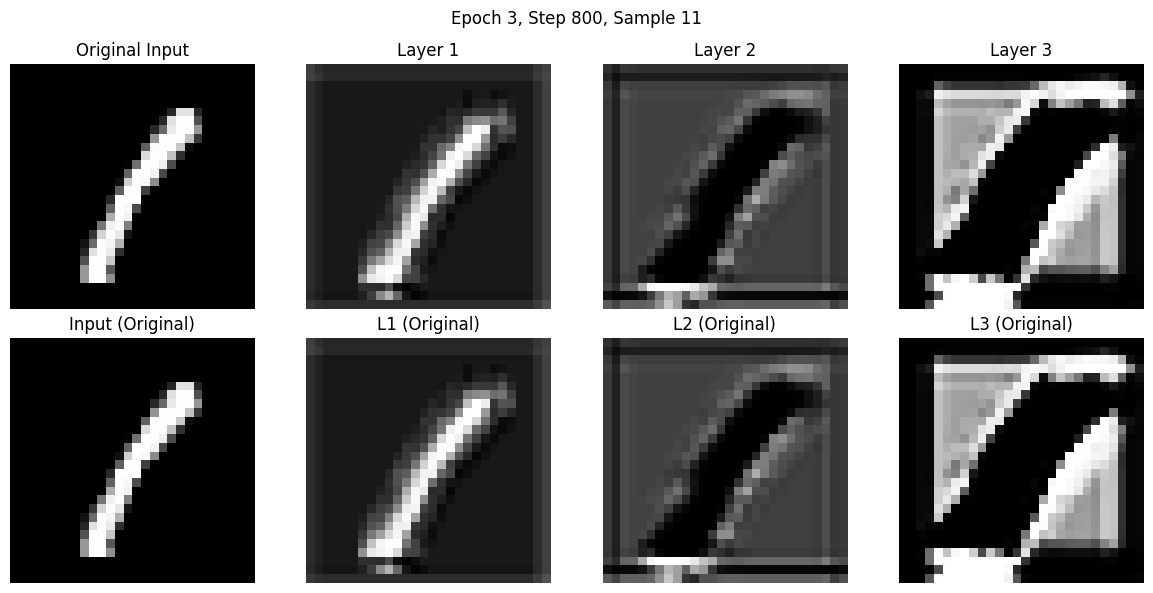

 85%|████████▌ | 801/938 [04:33<01:07,  2.02it/s]


Layer Statistics (Paraphrase Prob: 0.0%):
Input:
  MSE: 0.0000
  Cosine Similarity: 1.0000
  Actual Paraphrase Rate: 0.0%
Layer 1:
  MSE: 0.0000
  Cosine Similarity: 1.0000
  Actual Paraphrase Rate: 0.0%
Layer 2:
  MSE: 0.0000
  Cosine Similarity: 1.0000
  Actual Paraphrase Rate: 0.0%
Layer 3:
  MSE: 0.0000
  Cosine Similarity: 1.0000
  Actual Paraphrase Rate: 0.0%


100%|██████████| 938/938 [05:19<00:00,  2.94it/s]



Epoch 3 (Paraphrase Prob: 0.0%):
Train Loss: 0.1460, Train Acc: 95.80%, Test Acc: 97.37%


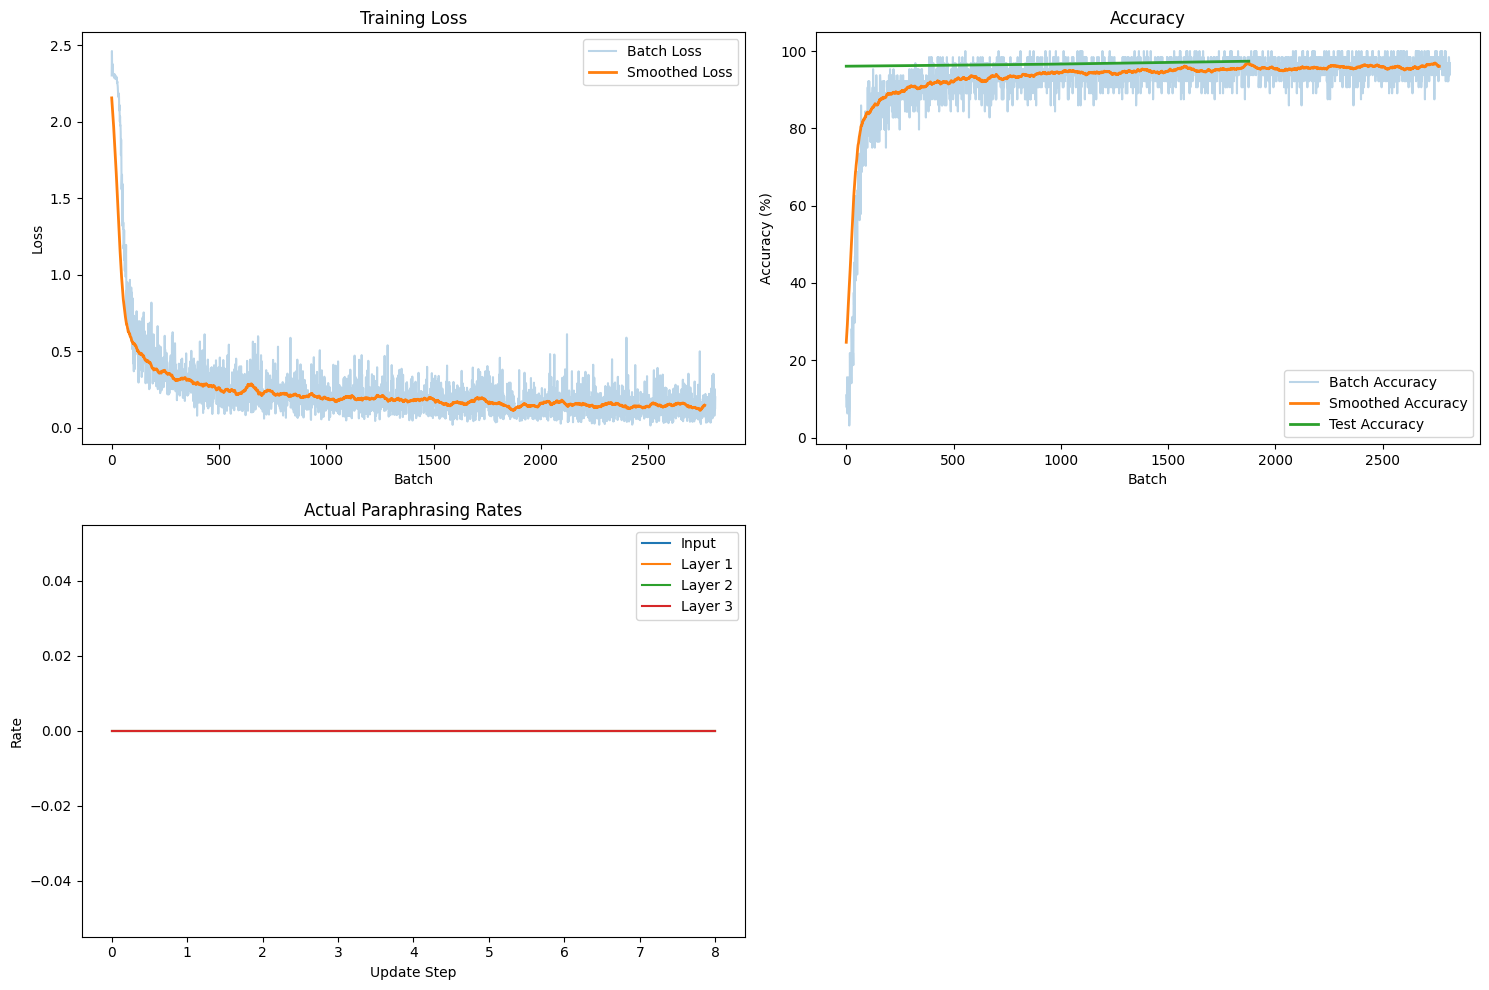

  0%|          | 0/938 [00:00<?, ?it/s]

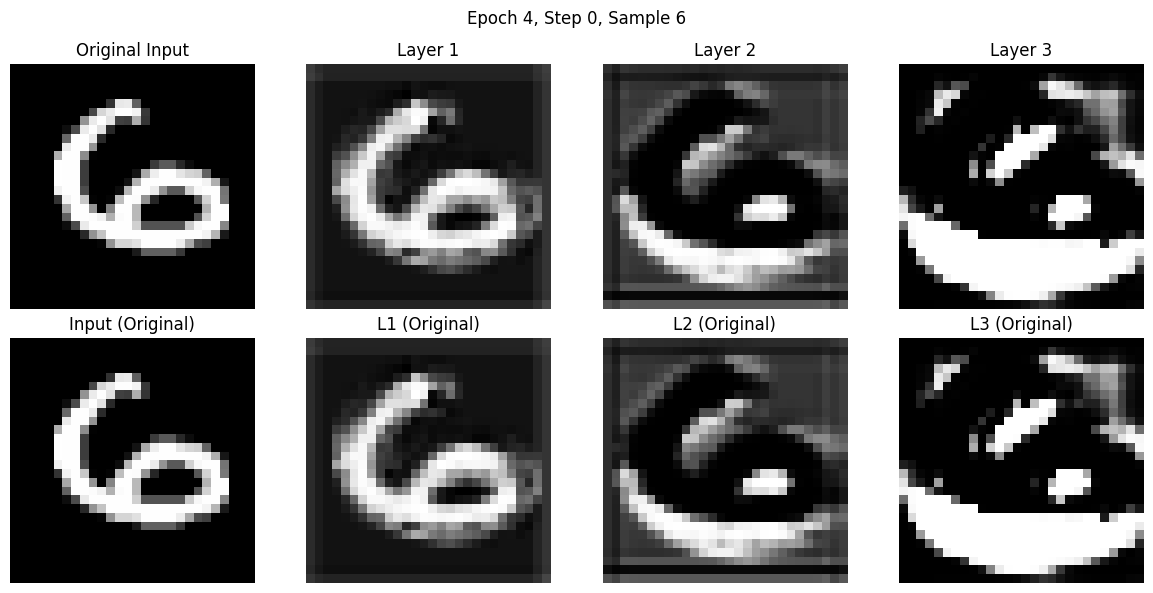

  0%|          | 1/938 [00:09<2:34:31,  9.89s/it]


Layer Statistics (Paraphrase Prob: 0.0%):
Input:
  MSE: 0.0000
  Cosine Similarity: 1.0000
  Actual Paraphrase Rate: 0.0%
Layer 1:
  MSE: 0.0000
  Cosine Similarity: 1.0000
  Actual Paraphrase Rate: 0.0%
Layer 2:
  MSE: 0.0000
  Cosine Similarity: 1.0000
  Actual Paraphrase Rate: 0.0%
Layer 3:
  MSE: 0.0000
  Cosine Similarity: 1.0000
  Actual Paraphrase Rate: 0.0%


 43%|████▎     | 400/938 [02:40<02:58,  3.01it/s]

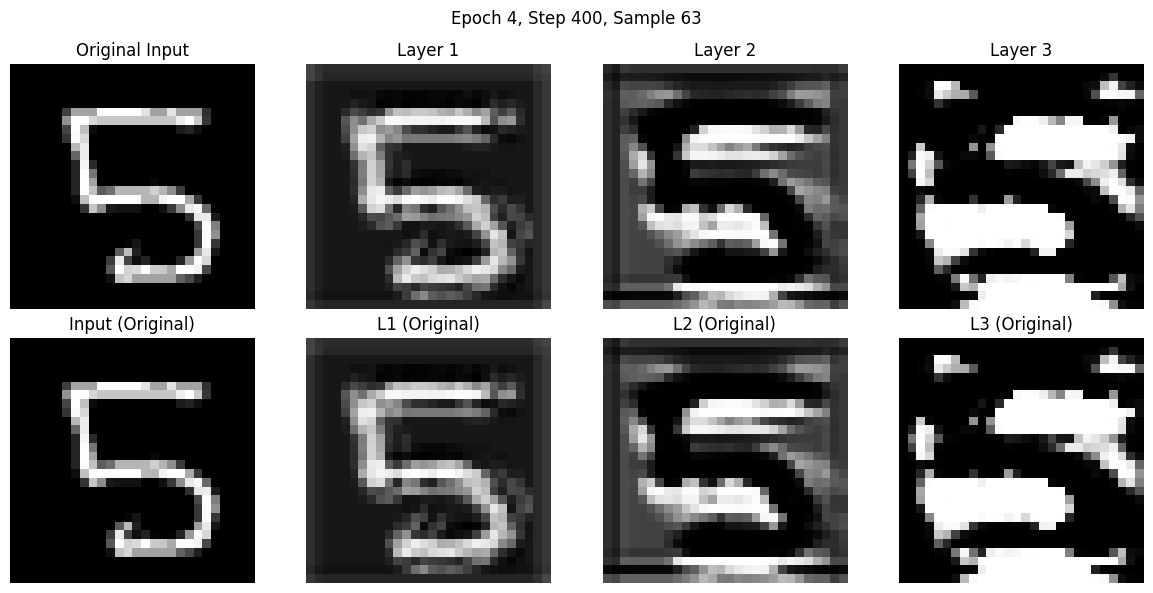

 43%|████▎     | 401/938 [02:41<04:37,  1.93it/s]


Layer Statistics (Paraphrase Prob: 0.0%):
Input:
  MSE: 0.0000
  Cosine Similarity: 1.0000
  Actual Paraphrase Rate: 0.0%
Layer 1:
  MSE: 0.0000
  Cosine Similarity: 1.0000
  Actual Paraphrase Rate: 0.0%
Layer 2:
  MSE: 0.0000
  Cosine Similarity: 1.0000
  Actual Paraphrase Rate: 0.0%
Layer 3:
  MSE: 0.0000
  Cosine Similarity: 1.0000
  Actual Paraphrase Rate: 0.0%


 85%|████████▌ | 800/938 [04:54<00:45,  3.00it/s]

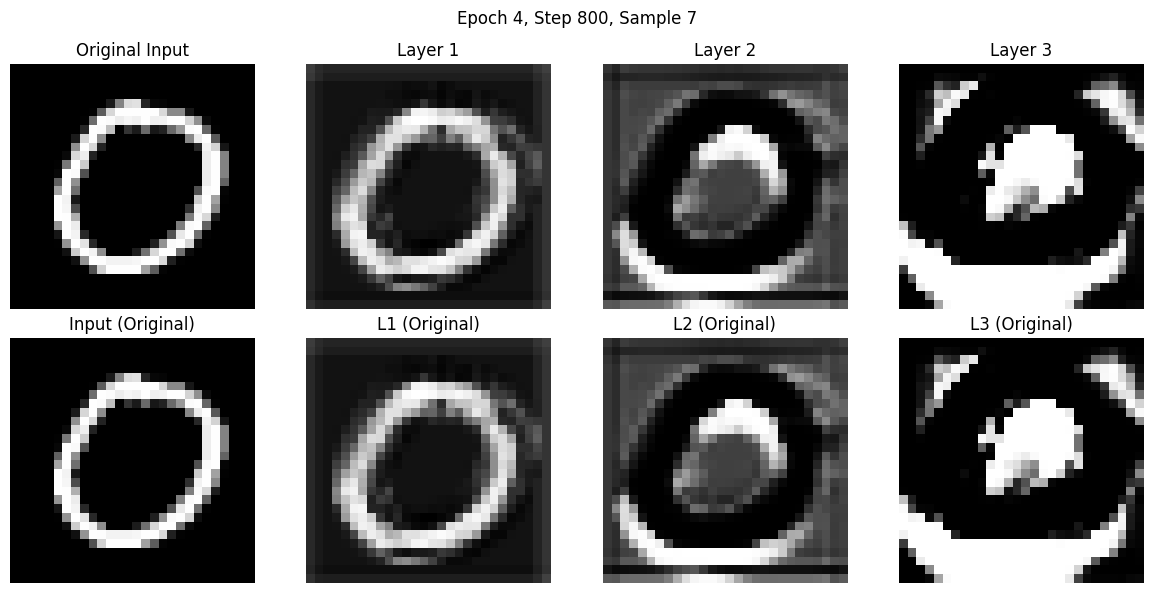

 85%|████████▌ | 801/938 [04:55<01:10,  1.94it/s]


Layer Statistics (Paraphrase Prob: 0.0%):
Input:
  MSE: 0.0000
  Cosine Similarity: 1.0000
  Actual Paraphrase Rate: 0.0%
Layer 1:
  MSE: 0.0000
  Cosine Similarity: 1.0000
  Actual Paraphrase Rate: 0.0%
Layer 2:
  MSE: 0.0000
  Cosine Similarity: 1.0000
  Actual Paraphrase Rate: 0.0%
Layer 3:
  MSE: 0.0000
  Cosine Similarity: 1.0000
  Actual Paraphrase Rate: 0.0%


100%|██████████| 938/938 [05:43<00:00,  2.73it/s]



Epoch 4 (Paraphrase Prob: 0.0%):
Train Loss: 0.1270, Train Acc: 96.25%, Test Acc: 97.55%


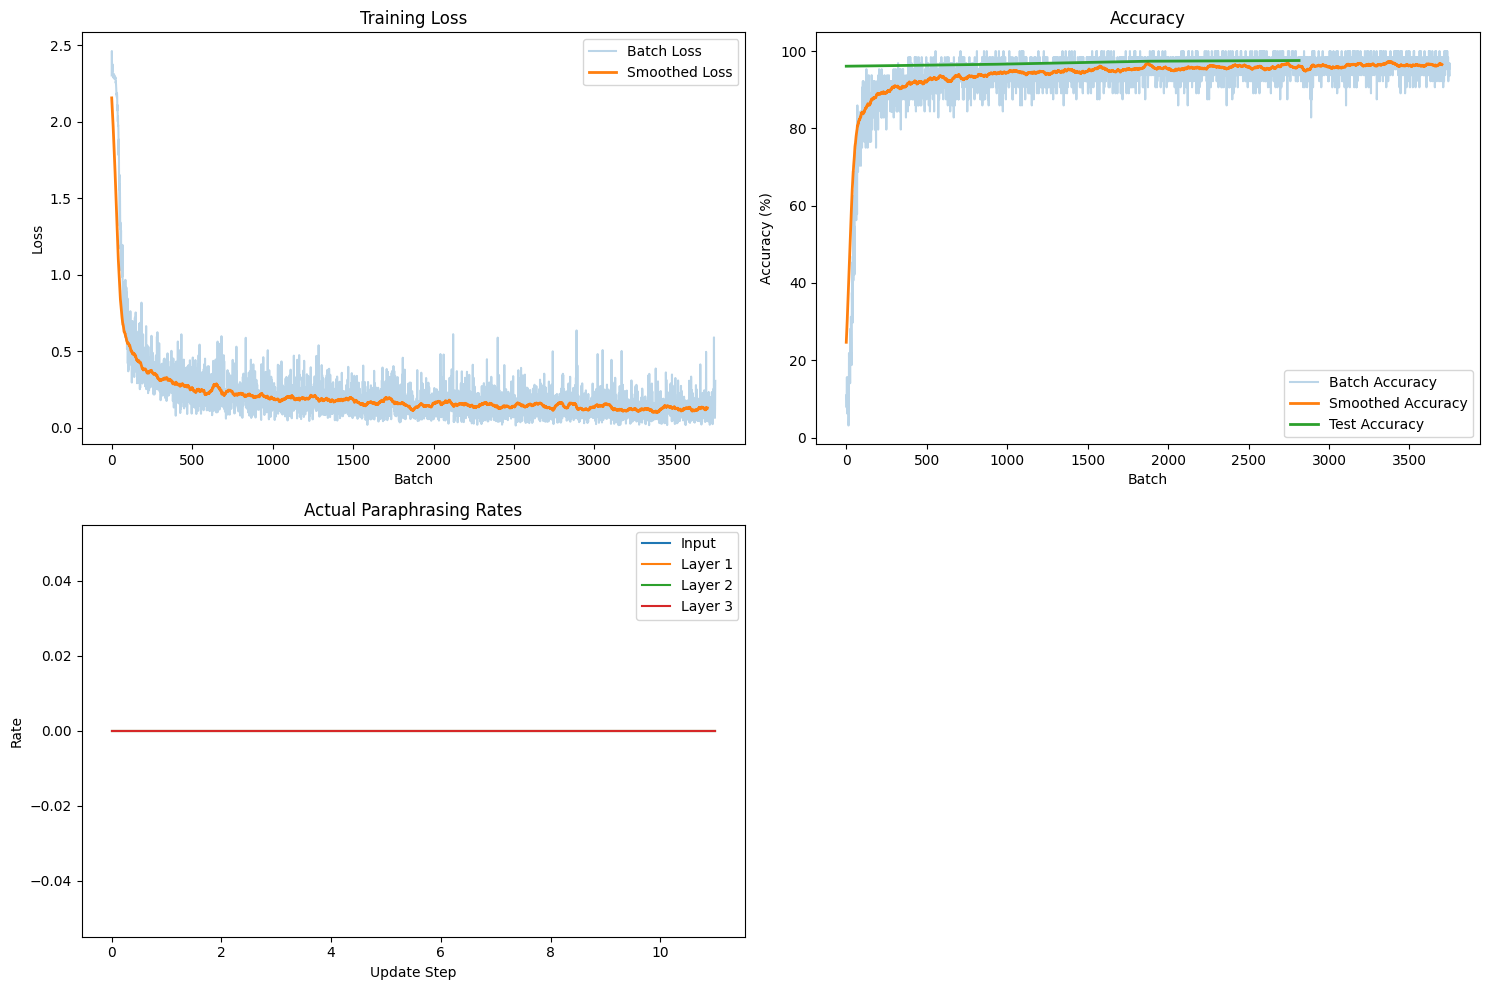

  0%|          | 0/938 [00:00<?, ?it/s]

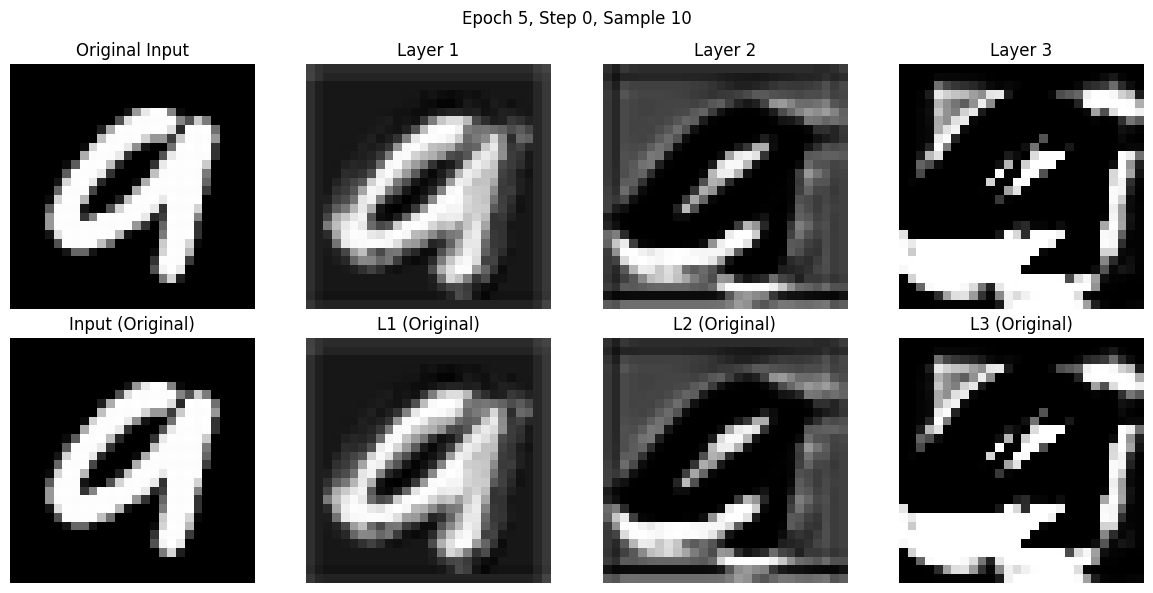

  0%|          | 1/938 [00:10<2:51:05, 10.96s/it]


Layer Statistics (Paraphrase Prob: 0.0%):
Input:
  MSE: 0.0000
  Cosine Similarity: 1.0000
  Actual Paraphrase Rate: 0.0%
Layer 1:
  MSE: 0.0000
  Cosine Similarity: 1.0000
  Actual Paraphrase Rate: 0.0%
Layer 2:
  MSE: 0.0000
  Cosine Similarity: 1.0000
  Actual Paraphrase Rate: 0.0%
Layer 3:
  MSE: 0.0000
  Cosine Similarity: 1.0000
  Actual Paraphrase Rate: 0.0%


 43%|████▎     | 400/938 [02:22<02:52,  3.12it/s]

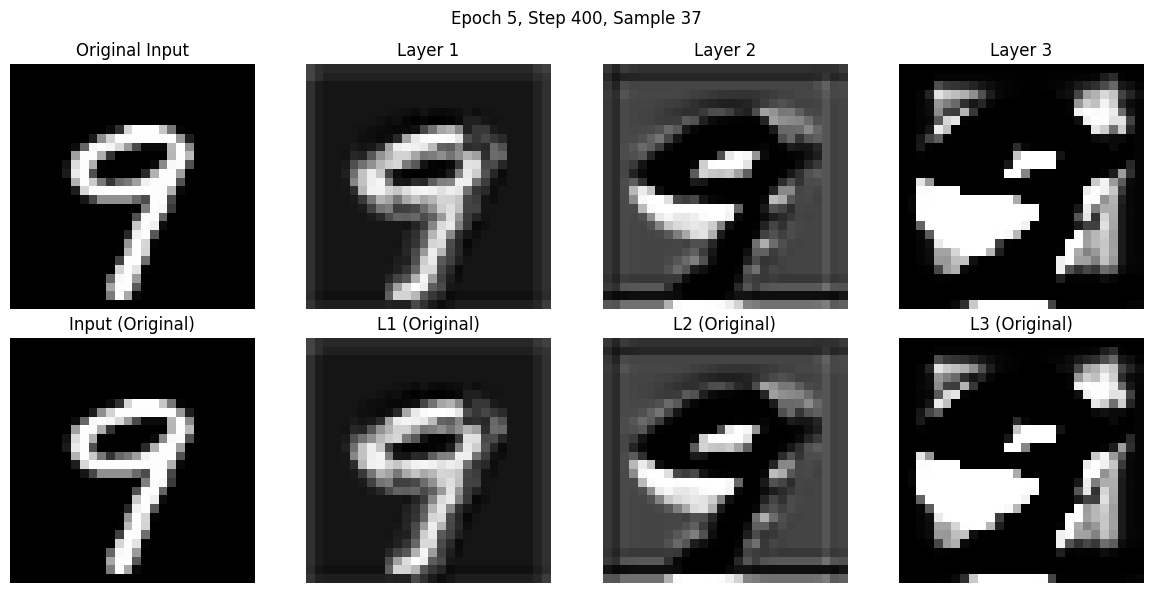

 43%|████▎     | 401/938 [02:23<04:14,  2.11it/s]


Layer Statistics (Paraphrase Prob: 0.0%):
Input:
  MSE: 0.0000
  Cosine Similarity: 1.0000
  Actual Paraphrase Rate: 0.0%
Layer 1:
  MSE: 0.0000
  Cosine Similarity: 1.0000
  Actual Paraphrase Rate: 0.0%
Layer 2:
  MSE: 0.0000
  Cosine Similarity: 1.0000
  Actual Paraphrase Rate: 0.0%
Layer 3:
  MSE: 0.0000
  Cosine Similarity: 1.0000
  Actual Paraphrase Rate: 0.0%


 85%|████████▌ | 800/938 [04:35<00:47,  2.93it/s]

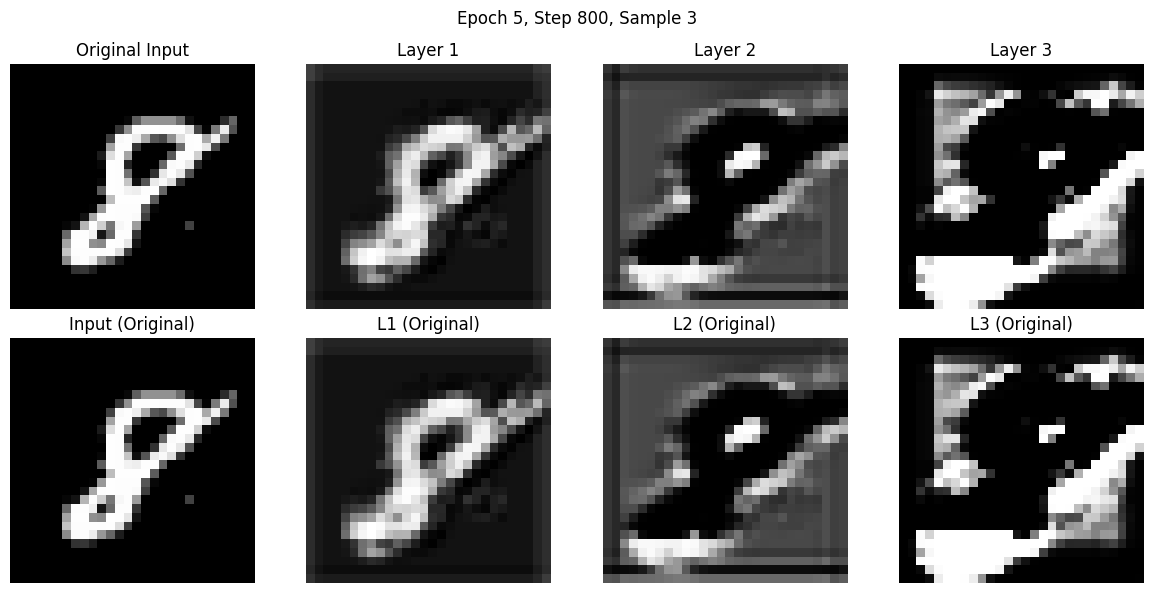

 85%|████████▌ | 801/938 [04:36<01:09,  1.97it/s]


Layer Statistics (Paraphrase Prob: 0.0%):
Input:
  MSE: 0.0000
  Cosine Similarity: 1.0000
  Actual Paraphrase Rate: 0.0%
Layer 1:
  MSE: 0.0000
  Cosine Similarity: 1.0000
  Actual Paraphrase Rate: 0.0%
Layer 2:
  MSE: 0.0000
  Cosine Similarity: 1.0000
  Actual Paraphrase Rate: 0.0%
Layer 3:
  MSE: 0.0000
  Cosine Similarity: 1.0000
  Actual Paraphrase Rate: 0.0%


100%|██████████| 938/938 [05:23<00:00,  2.90it/s]



Epoch 5 (Paraphrase Prob: 0.0%):
Train Loss: 0.1145, Train Acc: 96.61%, Test Acc: 97.50%


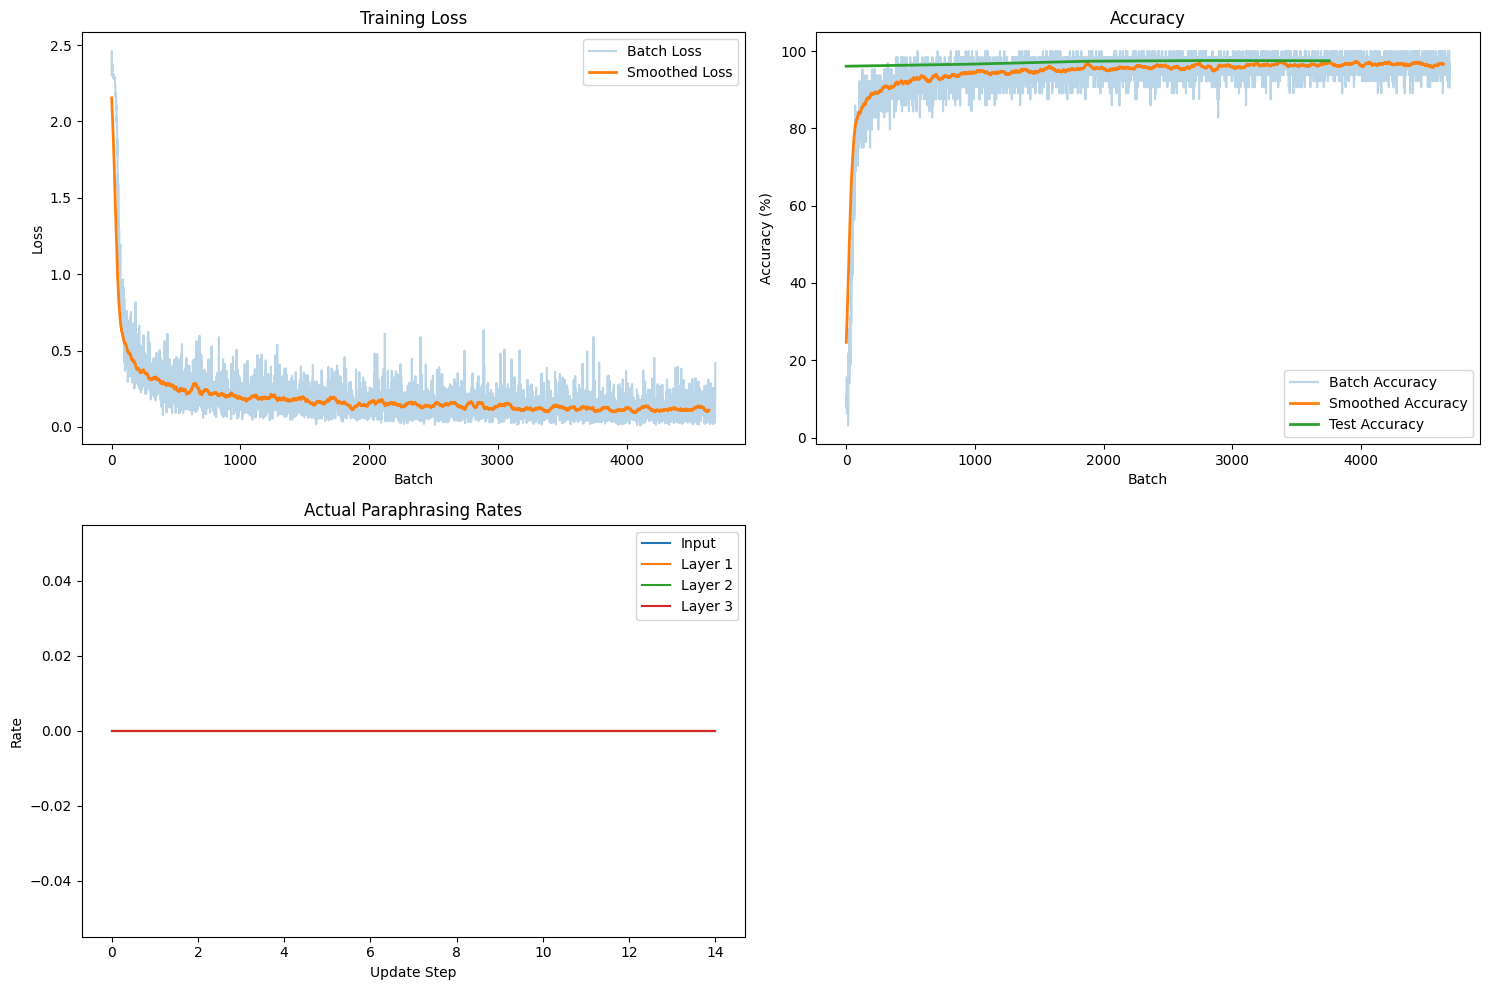


Training classifier with 50.0% paraphrasing probability

Training with paraphrase probability: 50.0%


  0%|          | 0/938 [00:00<?, ?it/s]

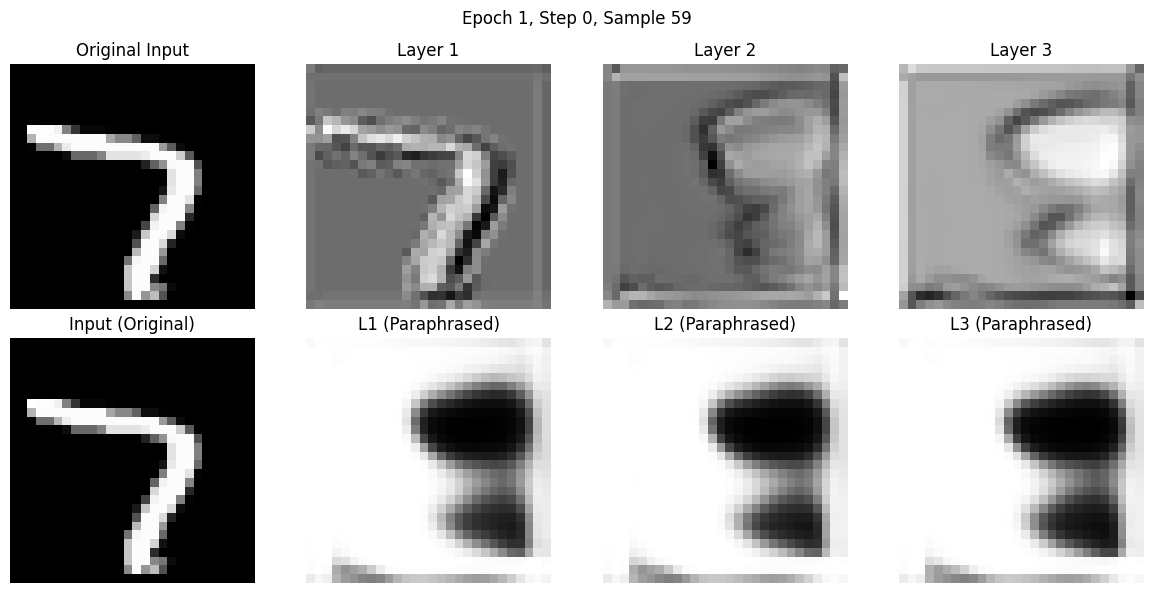

  0%|          | 1/938 [00:11<3:05:21, 11.87s/it]


Layer Statistics (Paraphrase Prob: 50.0%):
Input:
  MSE: 0.0000
  Cosine Similarity: 1.0000
  Actual Paraphrase Rate: 0.0%
Layer 1:
  MSE: 0.1859
  Cosine Similarity: 0.9155
  Actual Paraphrase Rate: 100.0%
Layer 2:
  MSE: 0.1628
  Cosine Similarity: 0.9060
  Actual Paraphrase Rate: 100.0%
Layer 3:
  MSE: 0.1727
  Cosine Similarity: 0.8896
  Actual Paraphrase Rate: 100.0%


 43%|████▎     | 400/938 [10:45<13:48,  1.54s/it]

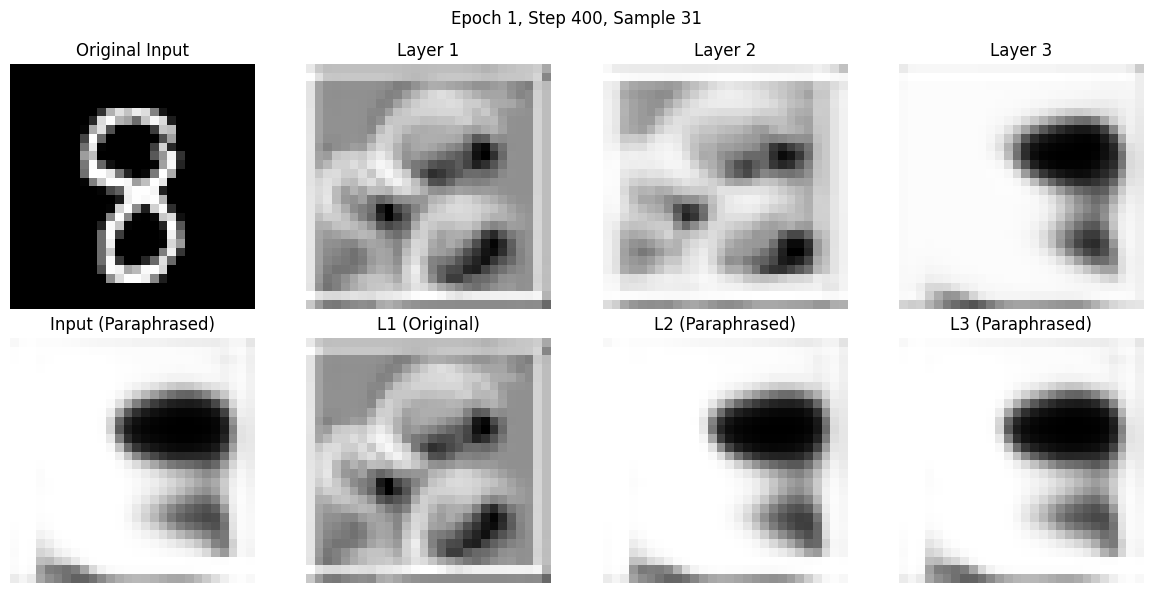

 43%|████▎     | 401/938 [10:47<17:13,  1.92s/it]


Layer Statistics (Paraphrase Prob: 50.0%):
Input:
  MSE: 0.9286
  Cosine Similarity: 0.4238
  Actual Paraphrase Rate: 48.0%
Layer 1:
  MSE: 0.0445
  Cosine Similarity: 0.9683
  Actual Paraphrase Rate: 44.0%
Layer 2:
  MSE: 0.0278
  Cosine Similarity: 0.9810
  Actual Paraphrase Rate: 57.0%
Layer 3:
  MSE: 0.0138
  Cosine Similarity: 0.9907
  Actual Paraphrase Rate: 53.0%


 85%|████████▌ | 800/938 [21:21<02:42,  1.18s/it]

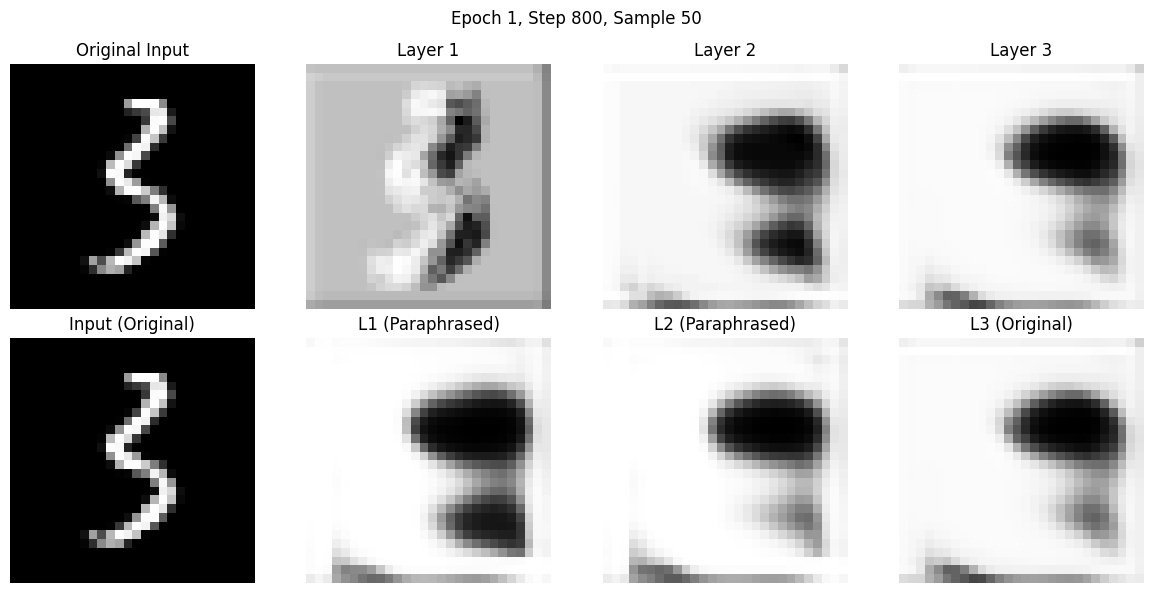

 85%|████████▌ | 801/938 [21:24<03:58,  1.74s/it]


Layer Statistics (Paraphrase Prob: 50.0%):
Input:
  MSE: 0.9469
  Cosine Similarity: 0.4107
  Actual Paraphrase Rate: 49.0%
Layer 1:
  MSE: 0.0388
  Cosine Similarity: 0.9729
  Actual Paraphrase Rate: 46.0%
Layer 2:
  MSE: 0.0199
  Cosine Similarity: 0.9865
  Actual Paraphrase Rate: 54.0%
Layer 3:
  MSE: 0.0081
  Cosine Similarity: 0.9947
  Actual Paraphrase Rate: 42.0%


100%|██████████| 938/938 [25:05<00:00,  1.61s/it]



Epoch 1 (Paraphrase Prob: 50.0%):
Train Loss: 2.3123, Train Acc: 11.17%, Test Acc: 11.35%


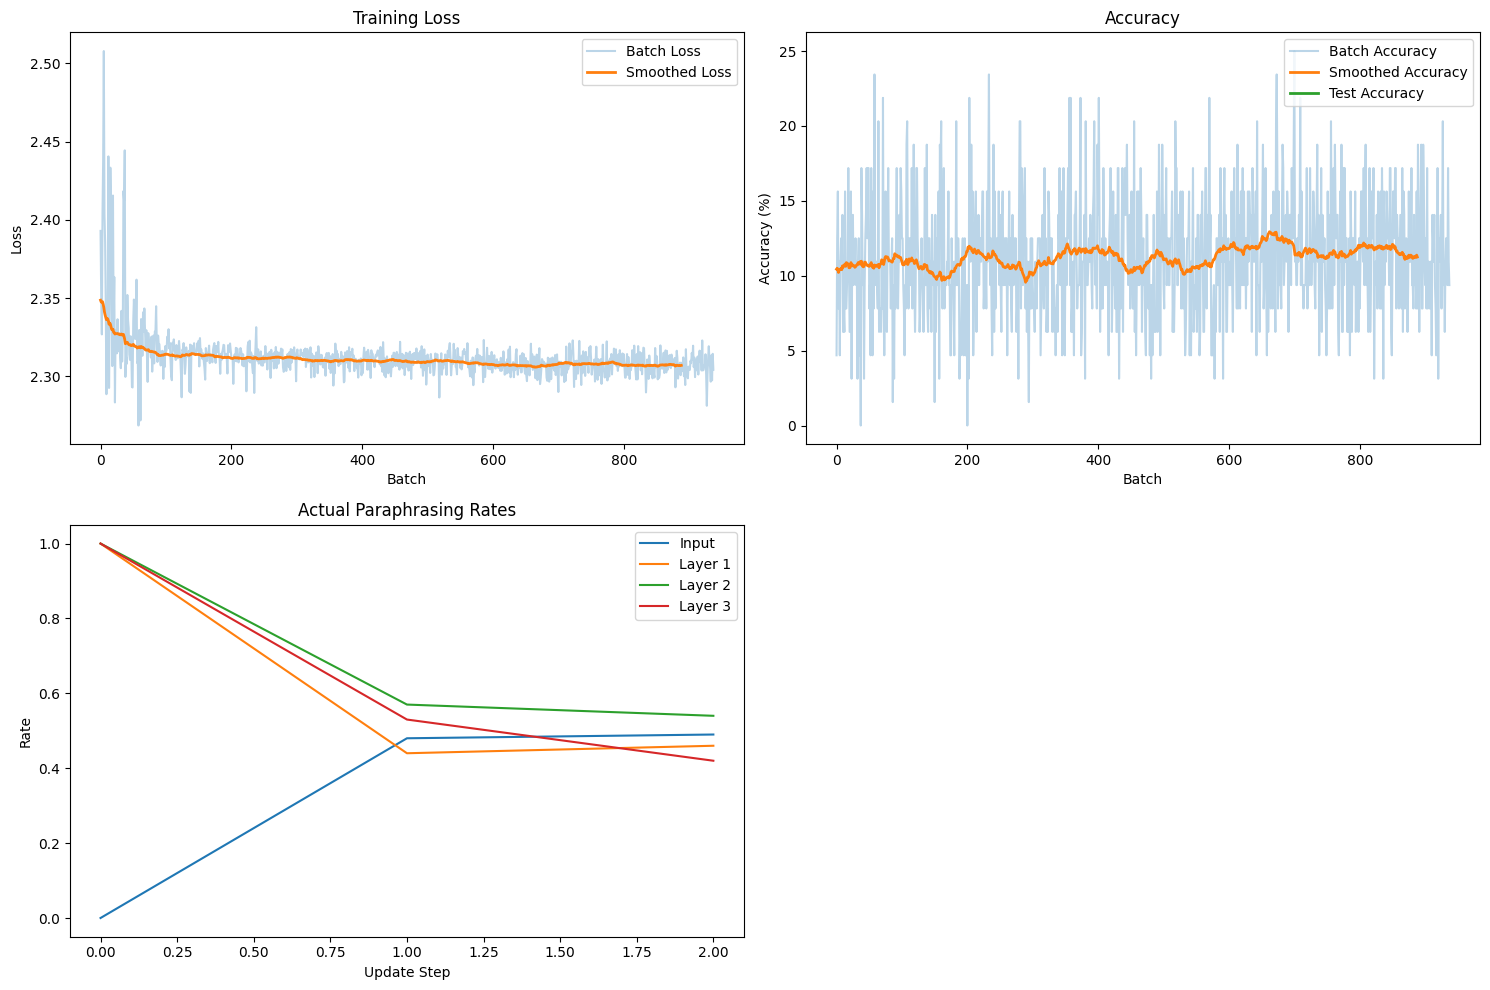

  0%|          | 0/938 [00:00<?, ?it/s]

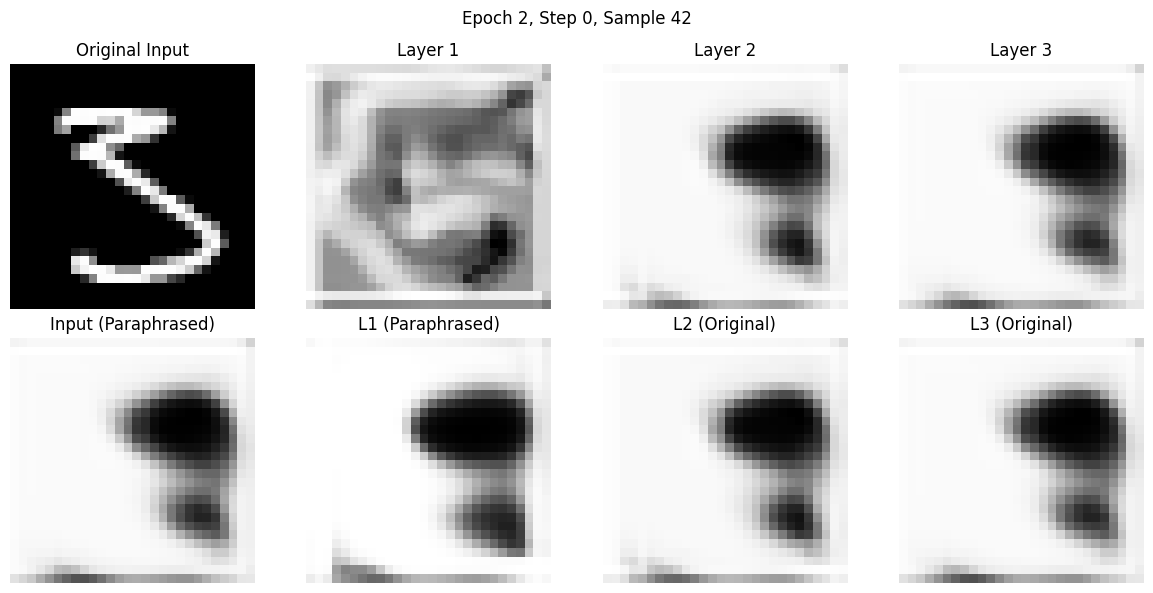

  0%|          | 1/938 [00:10<2:49:43, 10.87s/it]


Layer Statistics (Paraphrase Prob: 50.0%):
Input:
  MSE: 1.9205
  Cosine Similarity: -0.1997
  Actual Paraphrase Rate: 100.0%
Layer 1:
  MSE: 0.0729
  Cosine Similarity: 0.9494
  Actual Paraphrase Rate: 100.0%
Layer 2:
  MSE: 0.0000
  Cosine Similarity: 1.0000
  Actual Paraphrase Rate: 0.0%
Layer 3:
  MSE: 0.0000
  Cosine Similarity: 1.0000
  Actual Paraphrase Rate: 0.0%


 43%|████▎     | 400/938 [11:04<15:37,  1.74s/it]

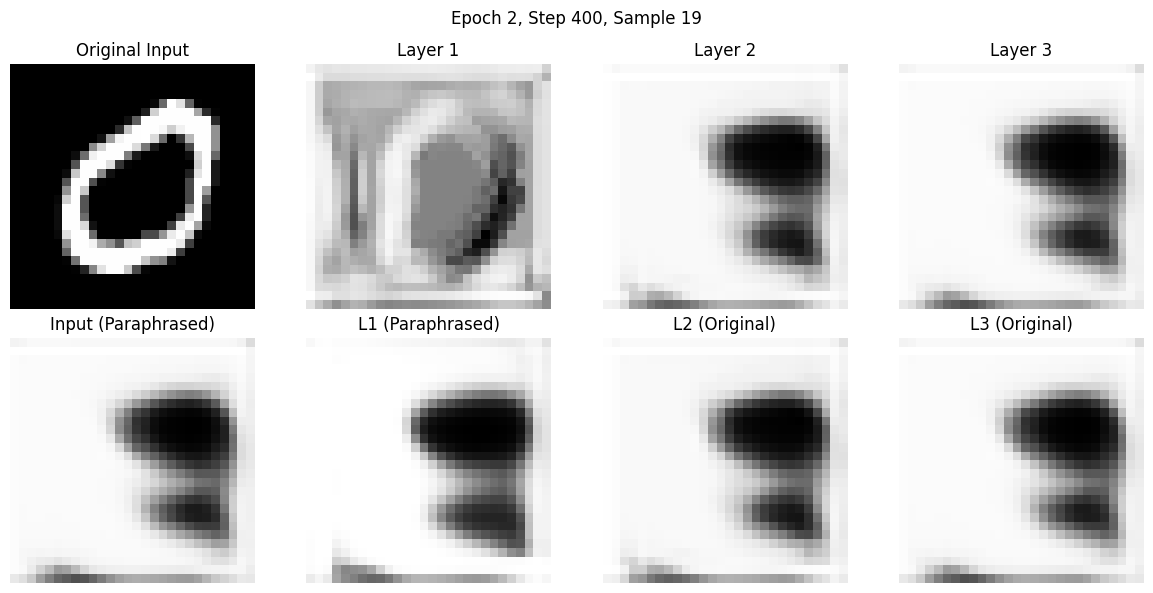

 43%|████▎     | 401/938 [11:06<16:52,  1.88s/it]


Layer Statistics (Paraphrase Prob: 50.0%):
Input:
  MSE: 0.8694
  Cosine Similarity: 0.4589
  Actual Paraphrase Rate: 45.0%
Layer 1:
  MSE: 0.0336
  Cosine Similarity: 0.9765
  Actual Paraphrase Rate: 43.0%
Layer 2:
  MSE: 0.0177
  Cosine Similarity: 0.9881
  Actual Paraphrase Rate: 50.0%
Layer 3:
  MSE: 0.0088
  Cosine Similarity: 0.9942
  Actual Paraphrase Rate: 51.0%


 85%|████████▌ | 800/938 [21:48<02:20,  1.02s/it]

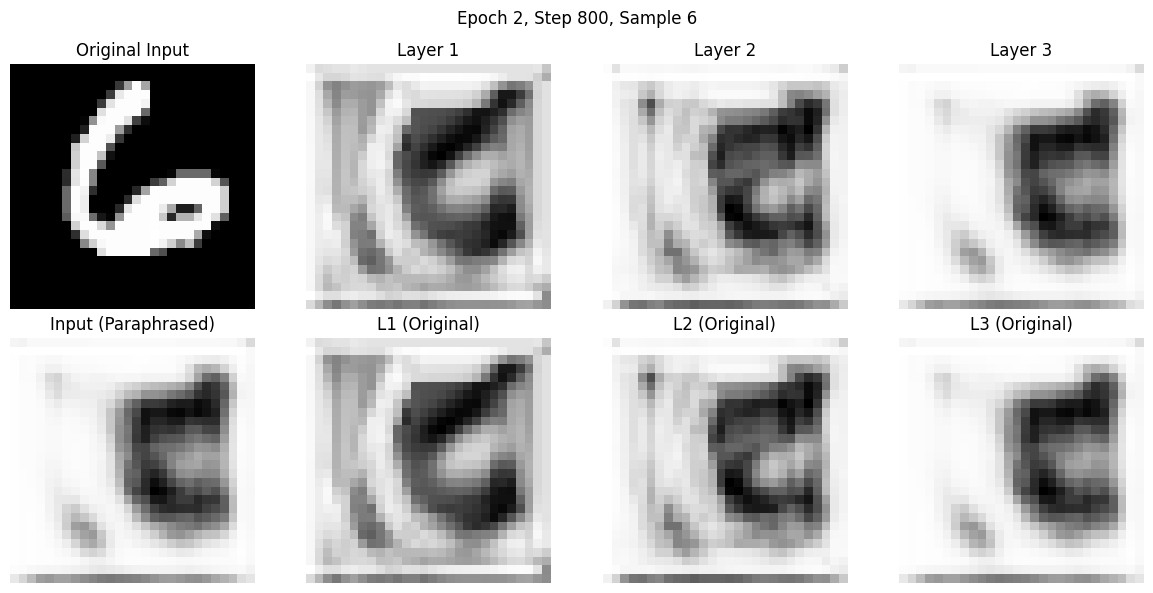

 85%|████████▌ | 801/938 [21:50<02:43,  1.20s/it]


Layer Statistics (Paraphrase Prob: 50.0%):
Input:
  MSE: 0.9507
  Cosine Similarity: 0.4123
  Actual Paraphrase Rate: 49.0%
Layer 1:
  MSE: 0.0337
  Cosine Similarity: 0.9765
  Actual Paraphrase Rate: 44.0%
Layer 2:
  MSE: 0.0146
  Cosine Similarity: 0.9902
  Actual Paraphrase Rate: 44.0%
Layer 3:
  MSE: 0.0078
  Cosine Similarity: 0.9949
  Actual Paraphrase Rate: 49.0%


100%|██████████| 938/938 [25:37<00:00,  1.64s/it]



Epoch 2 (Paraphrase Prob: 50.0%):
Train Loss: 2.3075, Train Acc: 11.24%, Test Acc: 11.35%


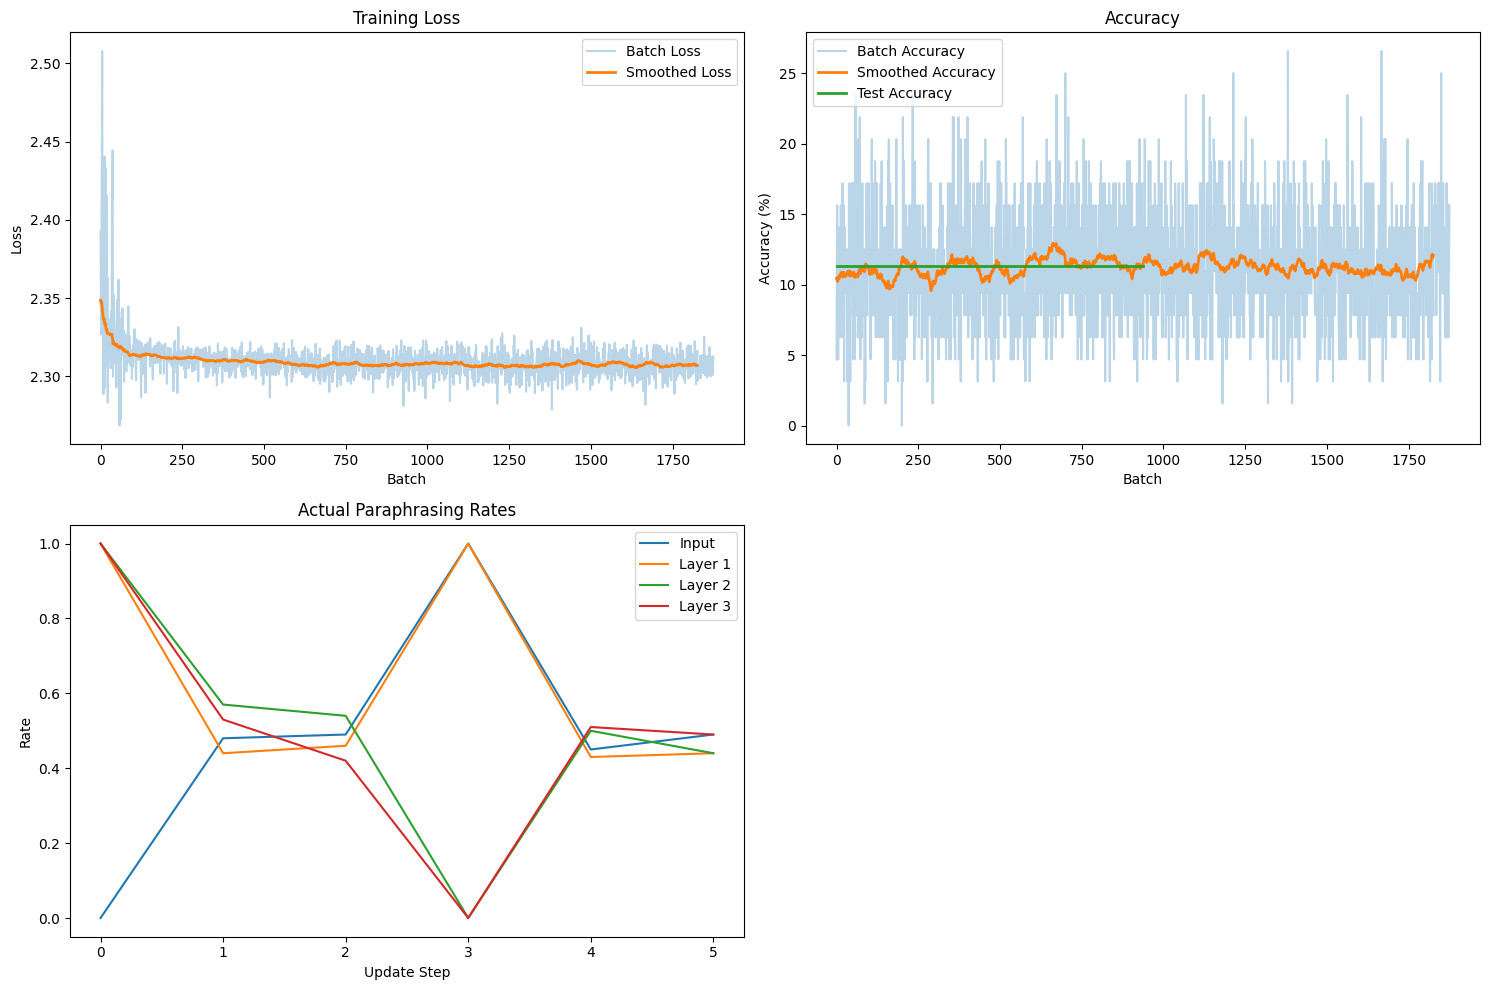

  0%|          | 0/938 [00:00<?, ?it/s]

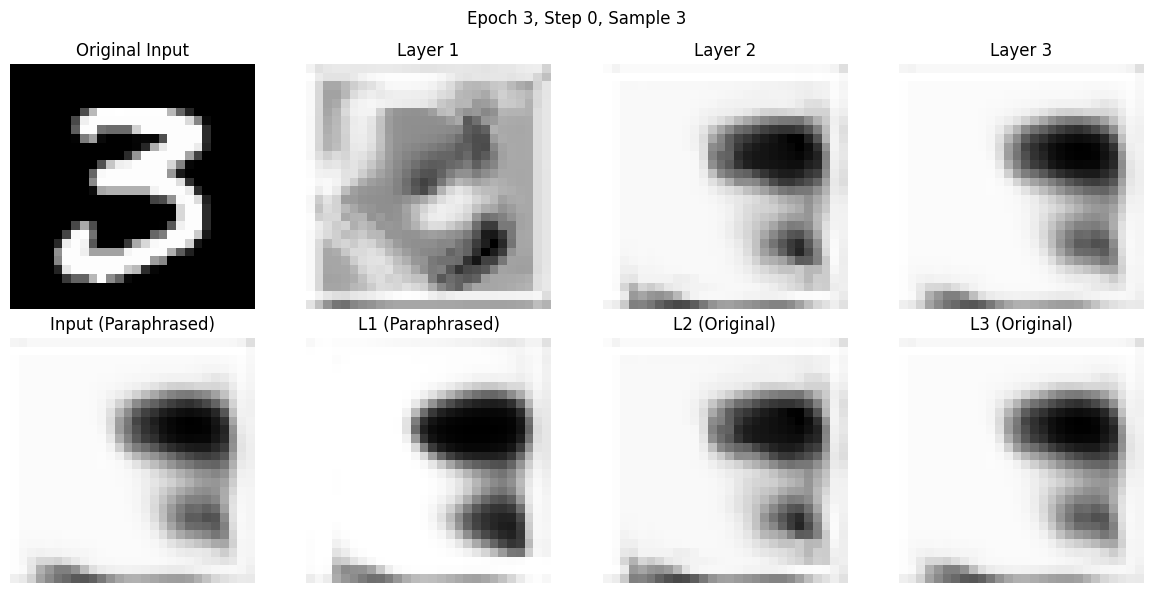

  0%|          | 1/938 [00:10<2:49:08, 10.83s/it]


Layer Statistics (Paraphrase Prob: 50.0%):
Input:
  MSE: 1.9056
  Cosine Similarity: -0.2011
  Actual Paraphrase Rate: 100.0%
Layer 1:
  MSE: 0.0705
  Cosine Similarity: 0.9507
  Actual Paraphrase Rate: 100.0%
Layer 2:
  MSE: 0.0000
  Cosine Similarity: 1.0000
  Actual Paraphrase Rate: 0.0%
Layer 3:
  MSE: 0.0000
  Cosine Similarity: 1.0000
  Actual Paraphrase Rate: 0.0%


 43%|████▎     | 400/938 [11:51<13:37,  1.52s/it]

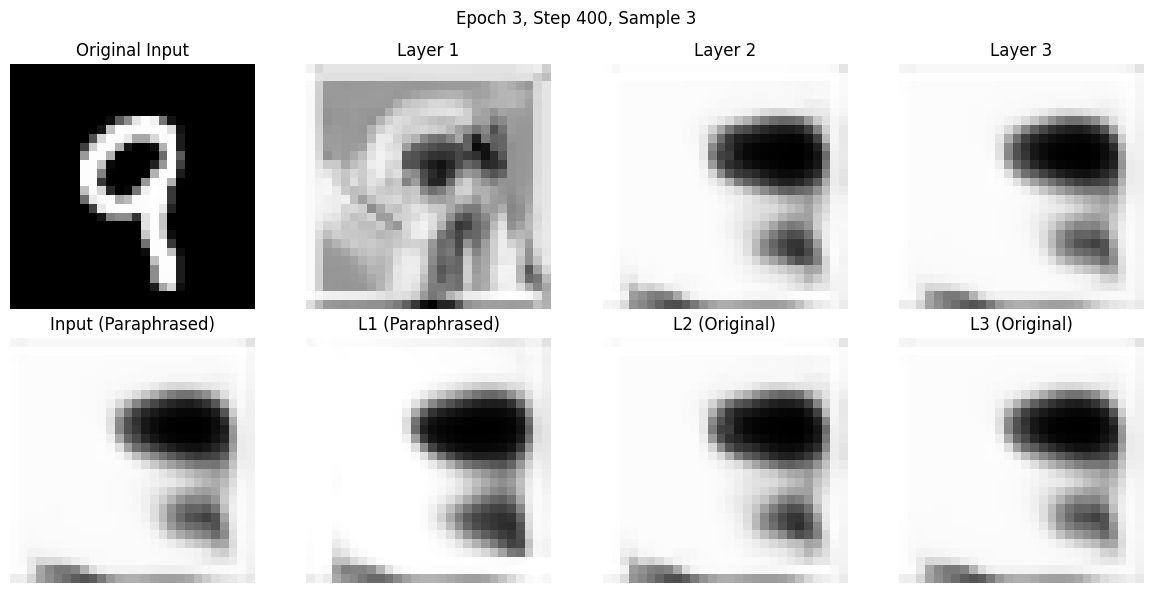

 43%|████▎     | 401/938 [11:54<16:16,  1.82s/it]


Layer Statistics (Paraphrase Prob: 50.0%):
Input:
  MSE: 1.0274
  Cosine Similarity: 0.3622
  Actual Paraphrase Rate: 53.0%
Layer 1:
  MSE: 0.0392
  Cosine Similarity: 0.9727
  Actual Paraphrase Rate: 53.0%
Layer 2:
  MSE: 0.0146
  Cosine Similarity: 0.9902
  Actual Paraphrase Rate: 56.0%
Layer 3:
  MSE: 0.0048
  Cosine Similarity: 0.9969
  Actual Paraphrase Rate: 44.0%


 85%|████████▌ | 800/938 [23:09<03:14,  1.41s/it]

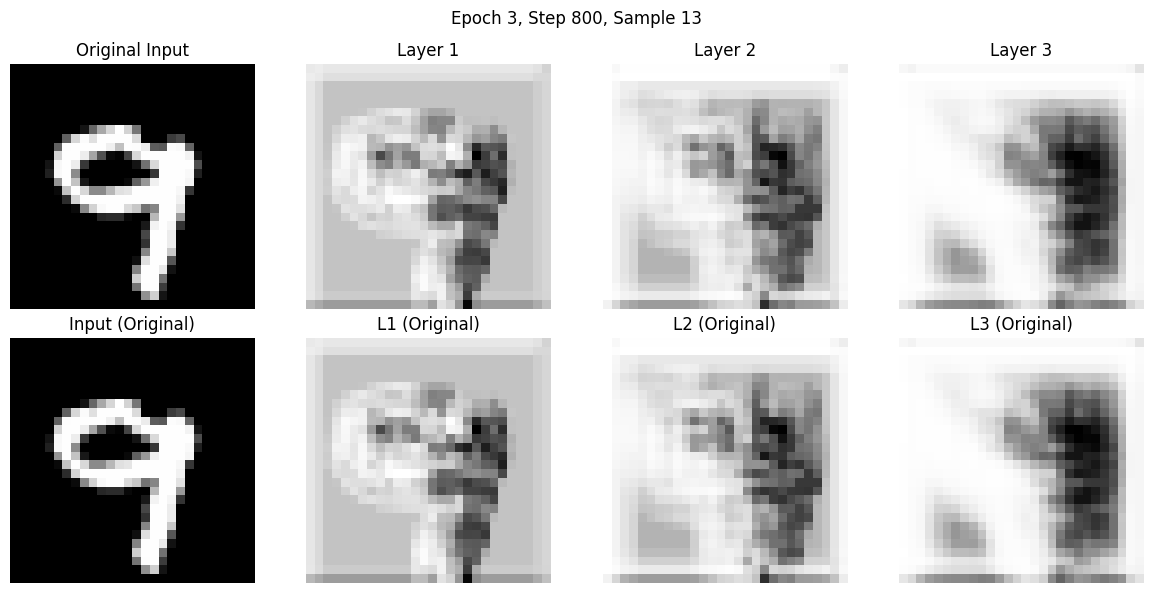

 85%|████████▌ | 801/938 [23:10<02:51,  1.25s/it]


Layer Statistics (Paraphrase Prob: 50.0%):
Input:
  MSE: 0.9674
  Cosine Similarity: 0.3989
  Actual Paraphrase Rate: 50.0%
Layer 1:
  MSE: 0.0409
  Cosine Similarity: 0.9715
  Actual Paraphrase Rate: 55.0%
Layer 2:
  MSE: 0.0116
  Cosine Similarity: 0.9922
  Actual Paraphrase Rate: 47.0%
Layer 3:
  MSE: 0.0061
  Cosine Similarity: 0.9960
  Actual Paraphrase Rate: 49.0%


100%|██████████| 938/938 [26:49<00:00,  1.72s/it]



Epoch 3 (Paraphrase Prob: 50.0%):
Train Loss: 2.3072, Train Acc: 11.24%, Test Acc: 11.35%


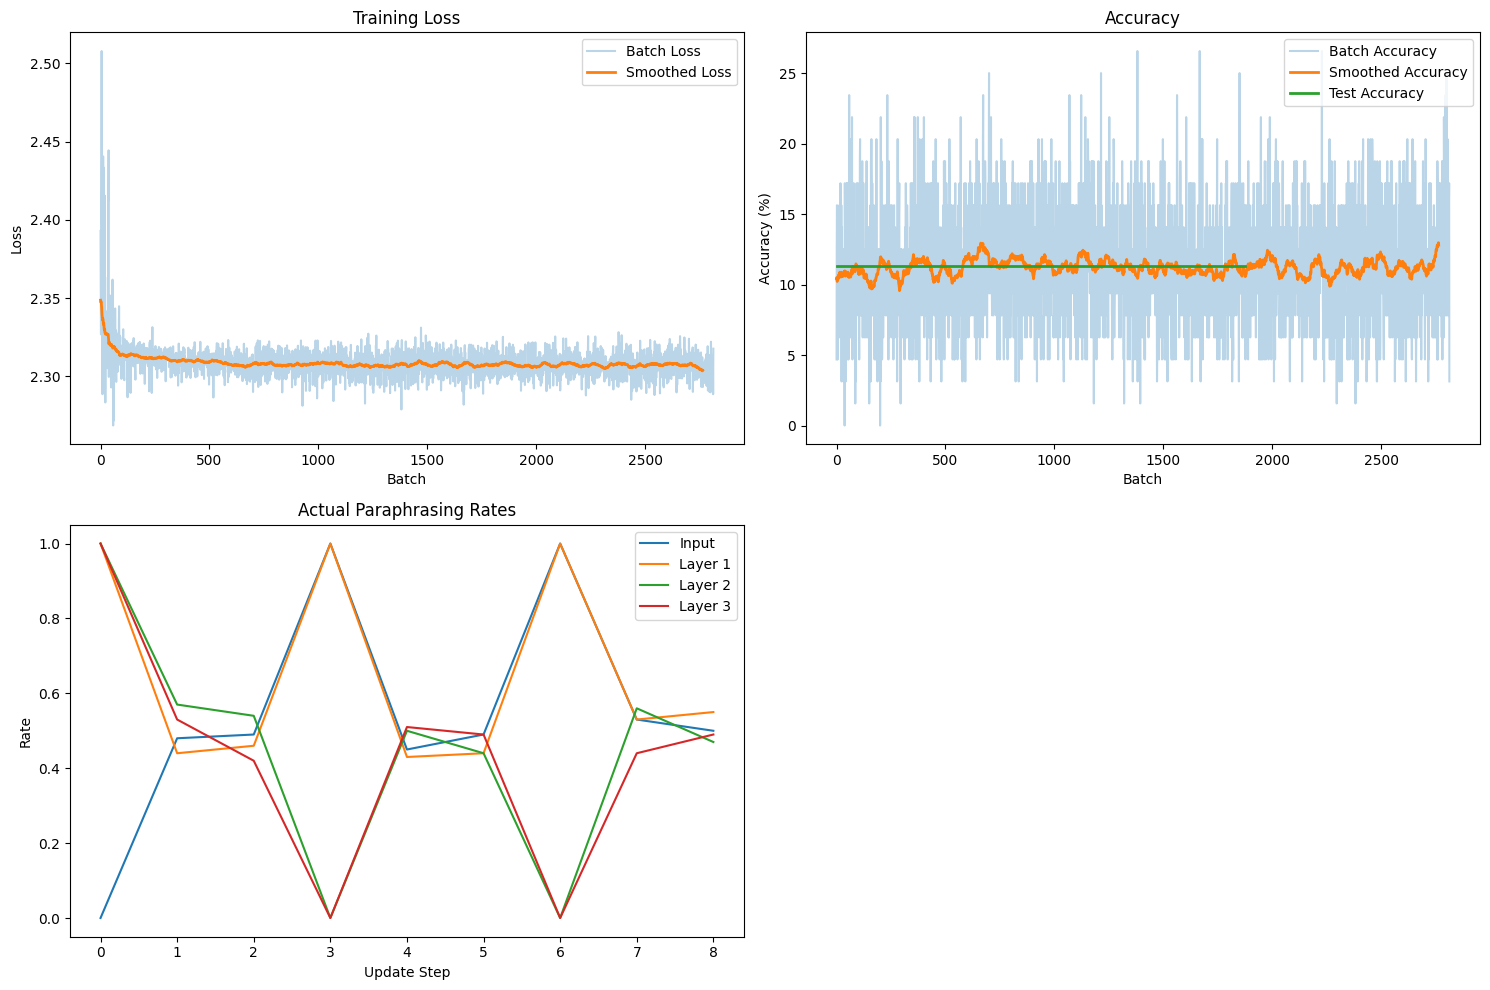

  0%|          | 0/938 [00:00<?, ?it/s]

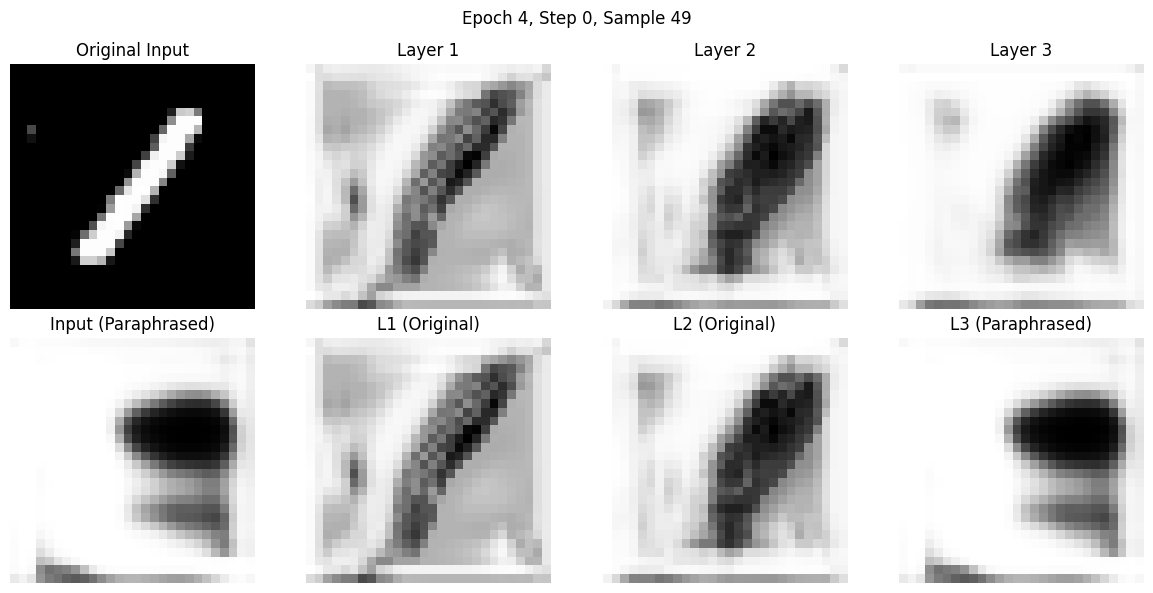

  0%|          | 1/938 [00:12<3:09:52, 12.16s/it]


Layer Statistics (Paraphrase Prob: 50.0%):
Input:
  MSE: 1.9598
  Cosine Similarity: -0.1944
  Actual Paraphrase Rate: 100.0%
Layer 1:
  MSE: 0.0000
  Cosine Similarity: 1.0000
  Actual Paraphrase Rate: 0.0%
Layer 2:
  MSE: 0.0000
  Cosine Similarity: 1.0000
  Actual Paraphrase Rate: 0.0%
Layer 3:
  MSE: 0.0331
  Cosine Similarity: 0.9779
  Actual Paraphrase Rate: 100.0%


 43%|████▎     | 400/938 [11:17<17:35,  1.96s/it]

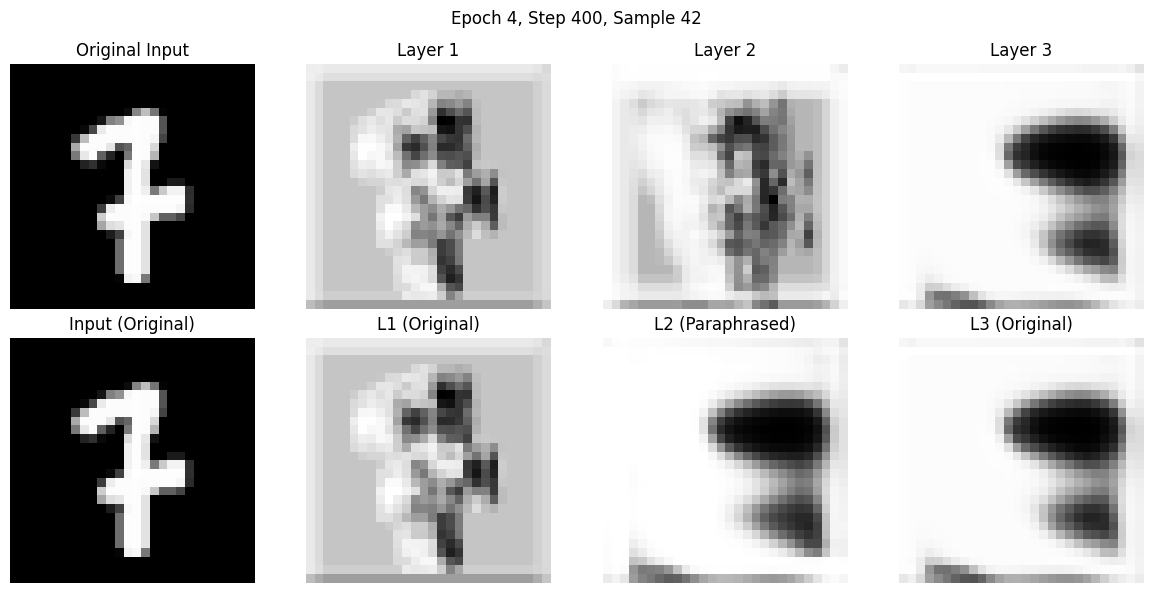

 43%|████▎     | 401/938 [11:19<16:50,  1.88s/it]


Layer Statistics (Paraphrase Prob: 50.0%):
Input:
  MSE: 0.9881
  Cosine Similarity: 0.3872
  Actual Paraphrase Rate: 51.0%
Layer 1:
  MSE: 0.0377
  Cosine Similarity: 0.9738
  Actual Paraphrase Rate: 51.0%
Layer 2:
  MSE: 0.0159
  Cosine Similarity: 0.9893
  Actual Paraphrase Rate: 59.0%
Layer 3:
  MSE: 0.0043
  Cosine Similarity: 0.9972
  Actual Paraphrase Rate: 43.0%


 85%|████████▌ | 800/938 [22:16<03:38,  1.58s/it]

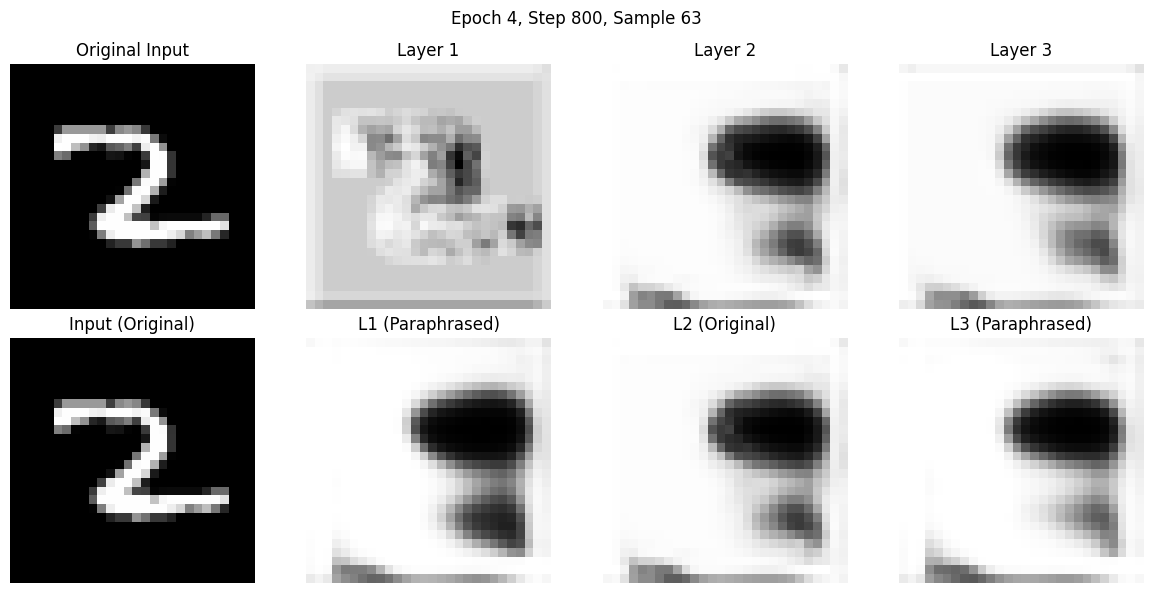

 85%|████████▌ | 801/938 [22:18<04:07,  1.81s/it]


Layer Statistics (Paraphrase Prob: 50.0%):
Input:
  MSE: 0.8724
  Cosine Similarity: 0.4589
  Actual Paraphrase Rate: 45.0%
Layer 1:
  MSE: 0.0326
  Cosine Similarity: 0.9774
  Actual Paraphrase Rate: 45.0%
Layer 2:
  MSE: 0.0173
  Cosine Similarity: 0.9884
  Actual Paraphrase Rate: 57.0%
Layer 3:
  MSE: 0.0052
  Cosine Similarity: 0.9966
  Actual Paraphrase Rate: 47.0%


100%|██████████| 938/938 [26:14<00:00,  1.68s/it]



Epoch 4 (Paraphrase Prob: 50.0%):
Train Loss: 2.3069, Train Acc: 11.24%, Test Acc: 11.35%


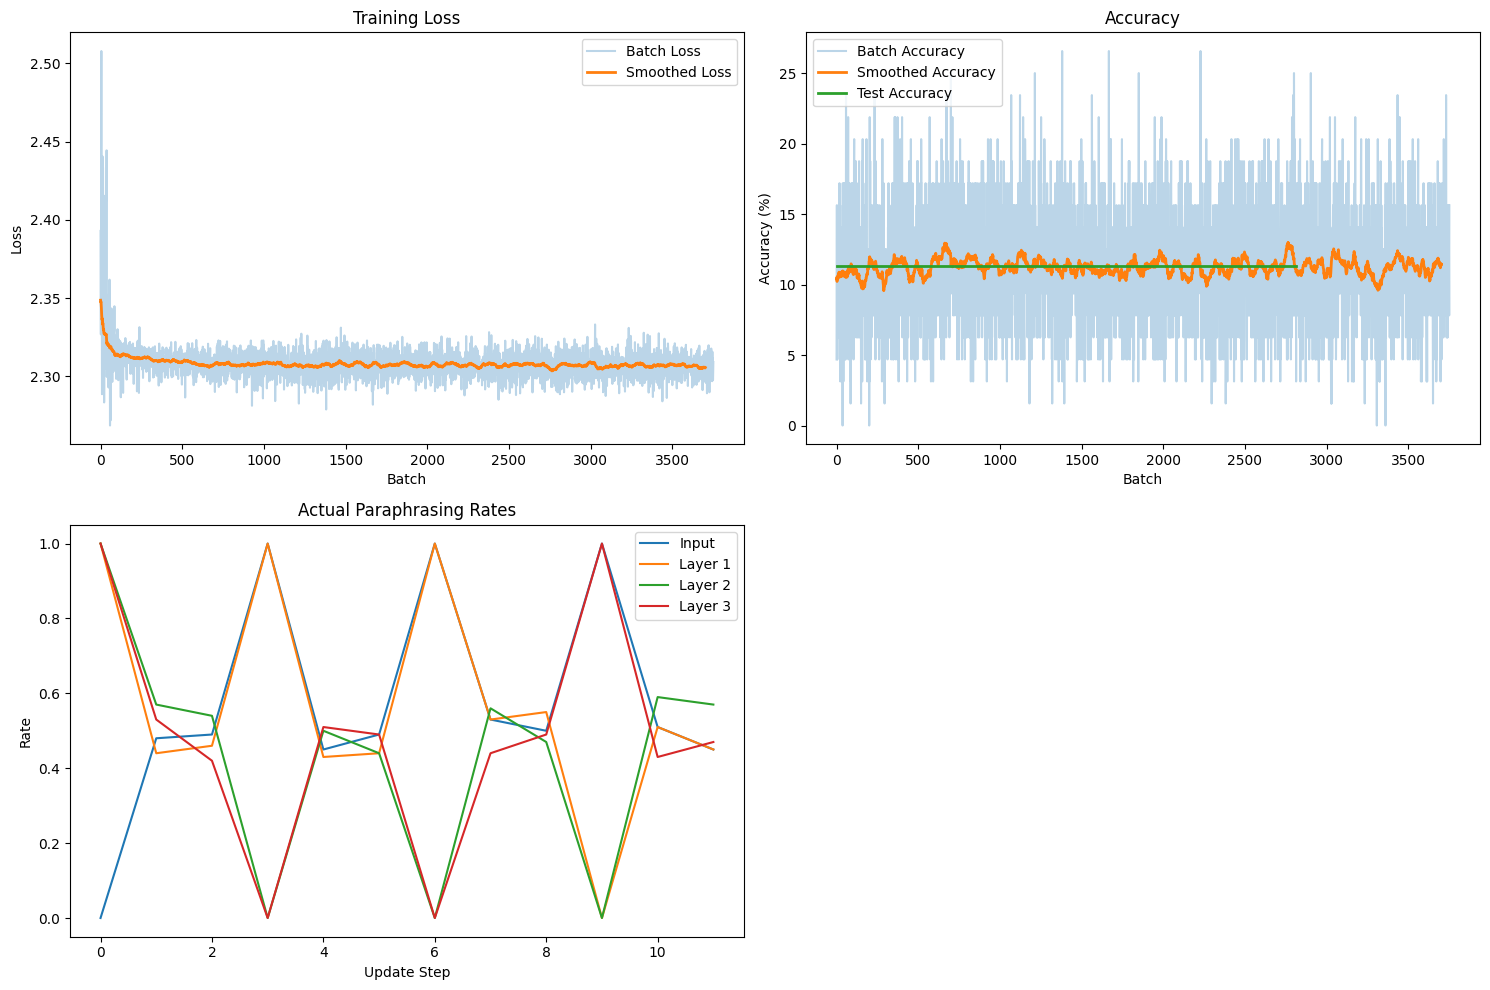

  0%|          | 0/938 [00:00<?, ?it/s]

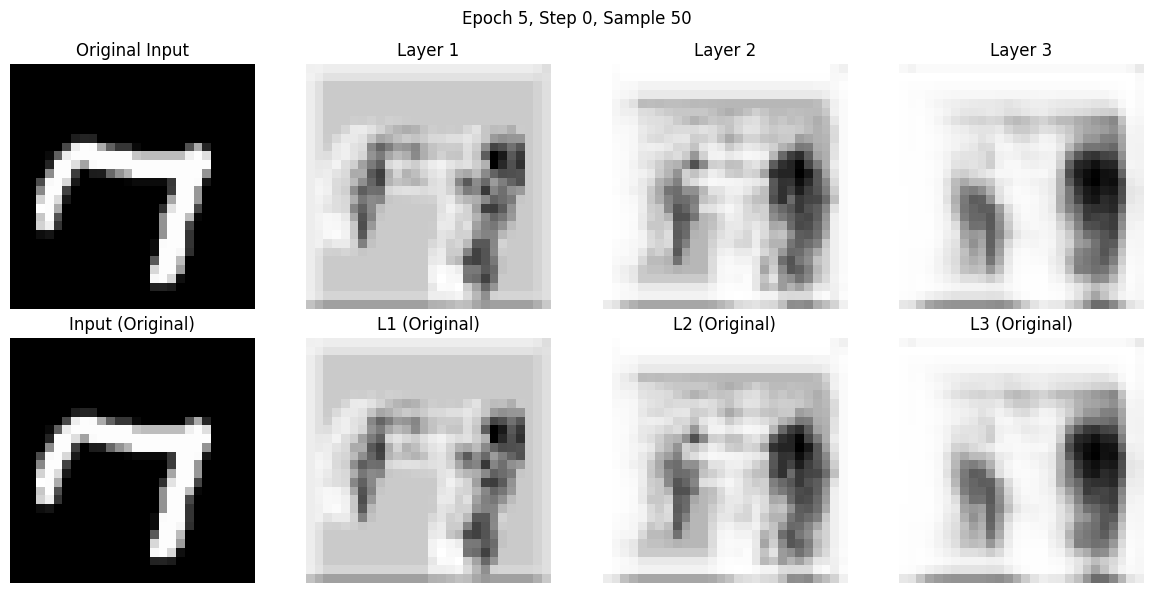

  0%|          | 1/938 [00:11<2:51:47, 11.00s/it]


Layer Statistics (Paraphrase Prob: 50.0%):
Input:
  MSE: 0.0000
  Cosine Similarity: 1.0000
  Actual Paraphrase Rate: 0.0%
Layer 1:
  MSE: 0.0000
  Cosine Similarity: 1.0000
  Actual Paraphrase Rate: 0.0%
Layer 2:
  MSE: 0.0000
  Cosine Similarity: 1.0000
  Actual Paraphrase Rate: 0.0%
Layer 3:
  MSE: 0.0000
  Cosine Similarity: 1.0000
  Actual Paraphrase Rate: 0.0%


 43%|████▎     | 400/938 [11:29<14:55,  1.66s/it]

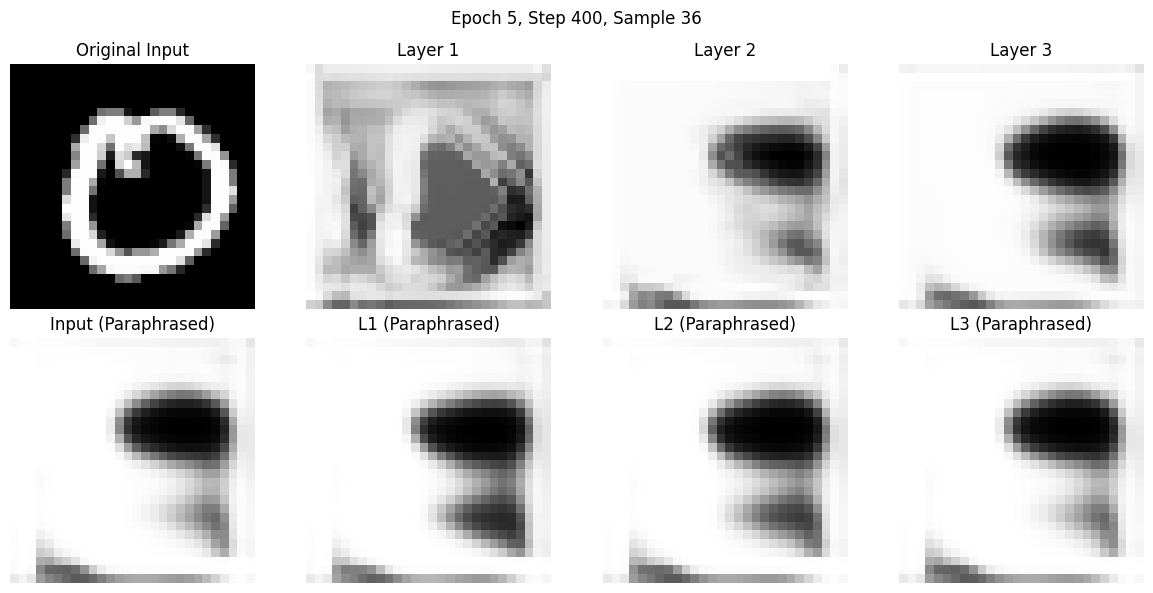

 43%|████▎     | 401/938 [11:33<20:50,  2.33s/it]


Layer Statistics (Paraphrase Prob: 50.0%):
Input:
  MSE: 0.8921
  Cosine Similarity: 0.4488
  Actual Paraphrase Rate: 46.0%
Layer 1:
  MSE: 0.0369
  Cosine Similarity: 0.9744
  Actual Paraphrase Rate: 51.0%
Layer 2:
  MSE: 0.0127
  Cosine Similarity: 0.9915
  Actual Paraphrase Rate: 50.0%
Layer 3:
  MSE: 0.0065
  Cosine Similarity: 0.9958
  Actual Paraphrase Rate: 54.0%


 85%|████████▌ | 800/938 [22:43<04:05,  1.78s/it]

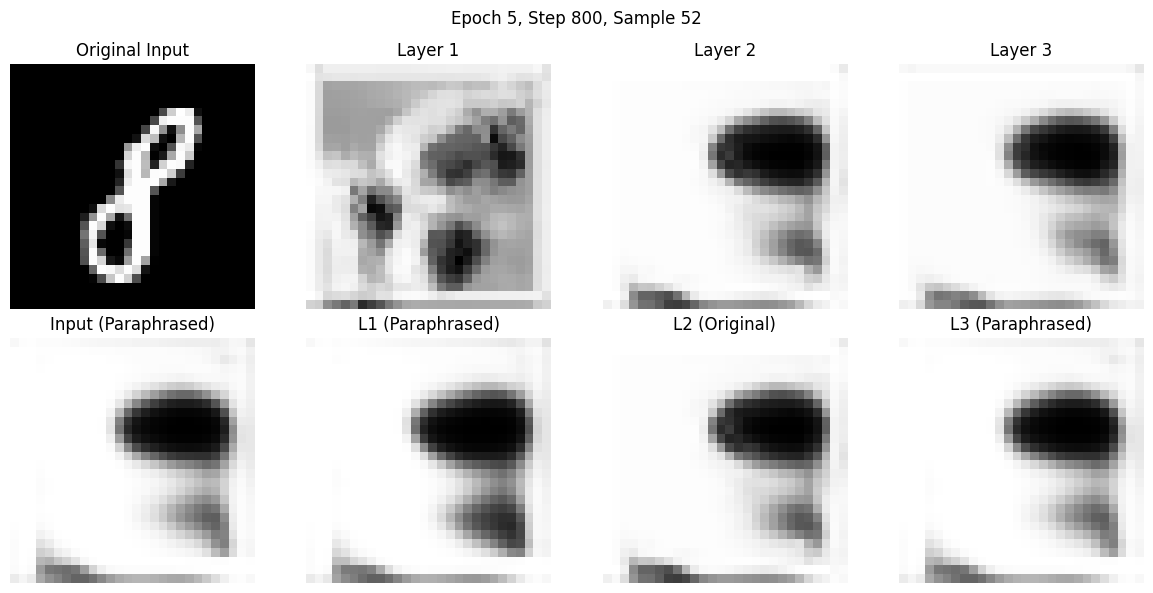

 85%|████████▌ | 801/938 [22:48<06:02,  2.65s/it]


Layer Statistics (Paraphrase Prob: 50.0%):
Input:
  MSE: 0.9719
  Cosine Similarity: 0.4008
  Actual Paraphrase Rate: 50.0%
Layer 1:
  MSE: 0.0415
  Cosine Similarity: 0.9712
  Actual Paraphrase Rate: 58.0%
Layer 2:
  MSE: 0.0092
  Cosine Similarity: 0.9939
  Actual Paraphrase Rate: 47.0%
Layer 3:
  MSE: 0.0061
  Cosine Similarity: 0.9960
  Actual Paraphrase Rate: 55.0%


100%|██████████| 938/938 [26:35<00:00,  1.70s/it]



Epoch 5 (Paraphrase Prob: 50.0%):
Train Loss: 2.3067, Train Acc: 11.24%, Test Acc: 11.35%


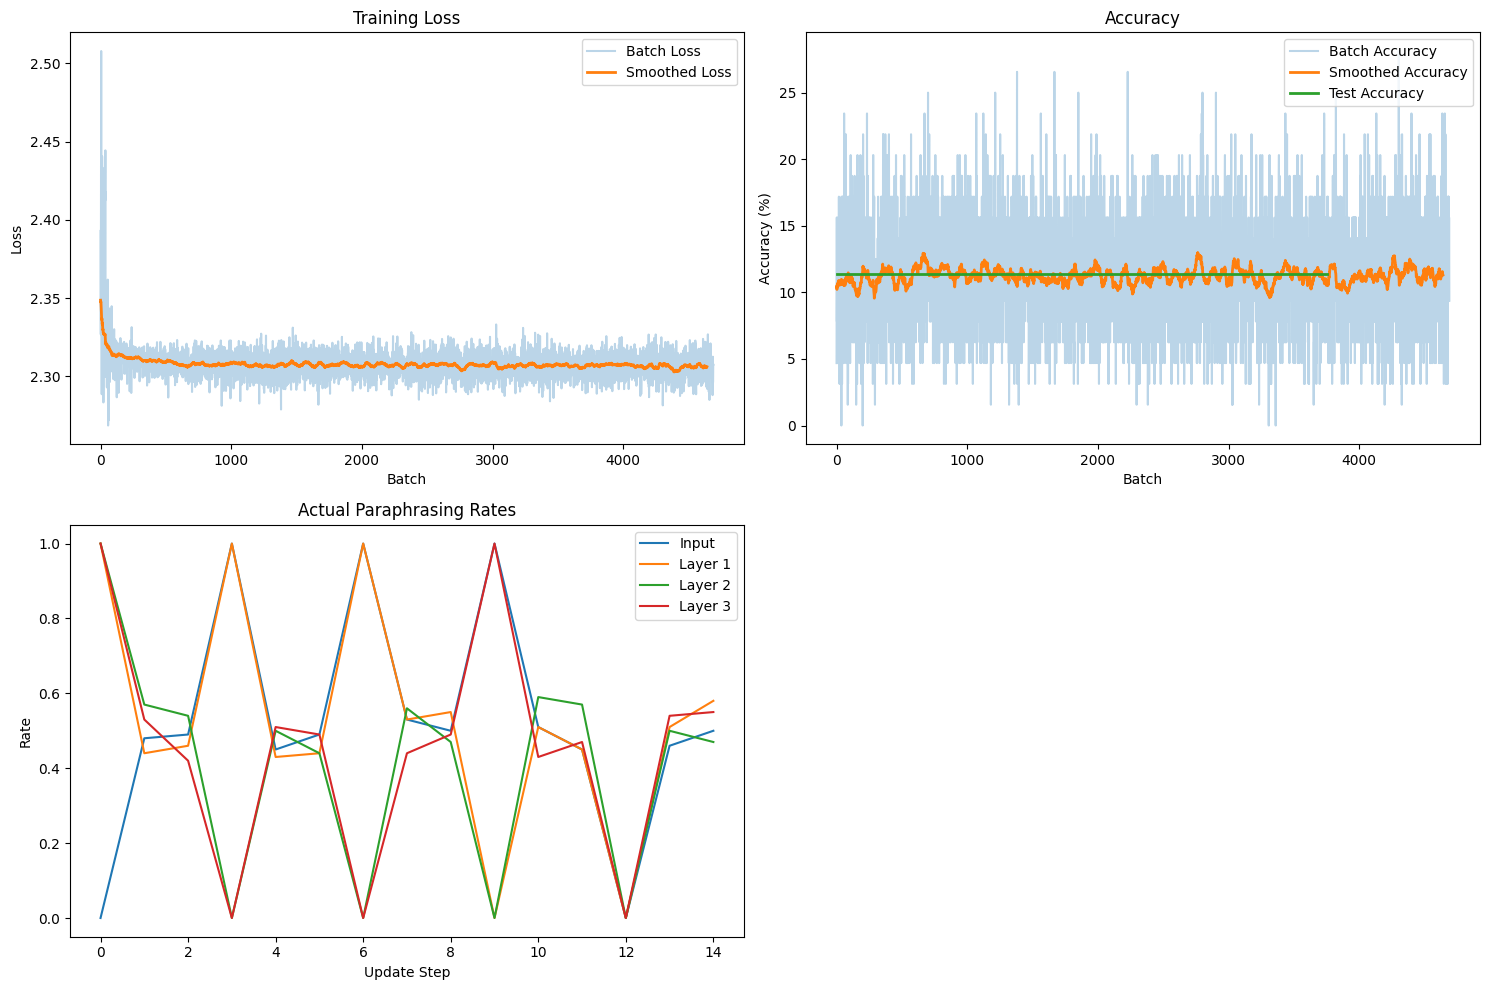


Training classifier with 100.0% paraphrasing probability

Training with paraphrase probability: 100.0%


  0%|          | 0/938 [00:00<?, ?it/s]

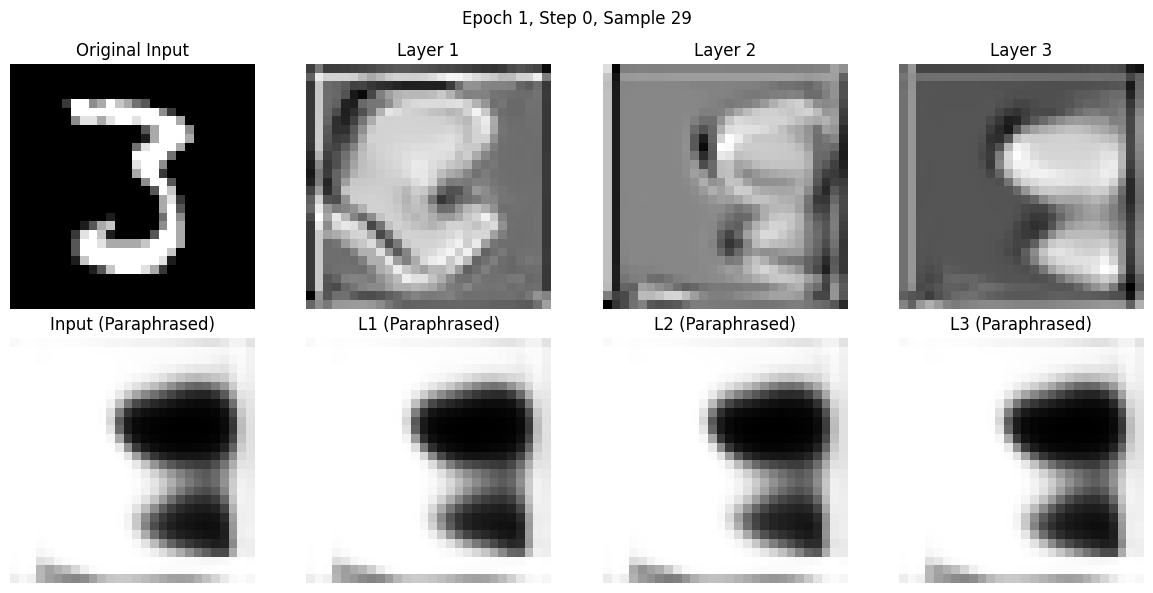

  0%|          | 1/938 [00:12<3:09:33, 12.14s/it]


Layer Statistics (Paraphrase Prob: 100.0%):
Input:
  MSE: 1.9451
  Cosine Similarity: -0.1949
  Actual Paraphrase Rate: 100.0%
Layer 1:
  MSE: 0.1908
  Cosine Similarity: 0.8969
  Actual Paraphrase Rate: 100.0%
Layer 2:
  MSE: 0.1782
  Cosine Similarity: 0.9019
  Actual Paraphrase Rate: 100.0%
Layer 3:
  MSE: 0.2145
  Cosine Similarity: 0.8432
  Actual Paraphrase Rate: 100.0%


 43%|████▎     | 400/938 [19:48<26:31,  2.96s/it]

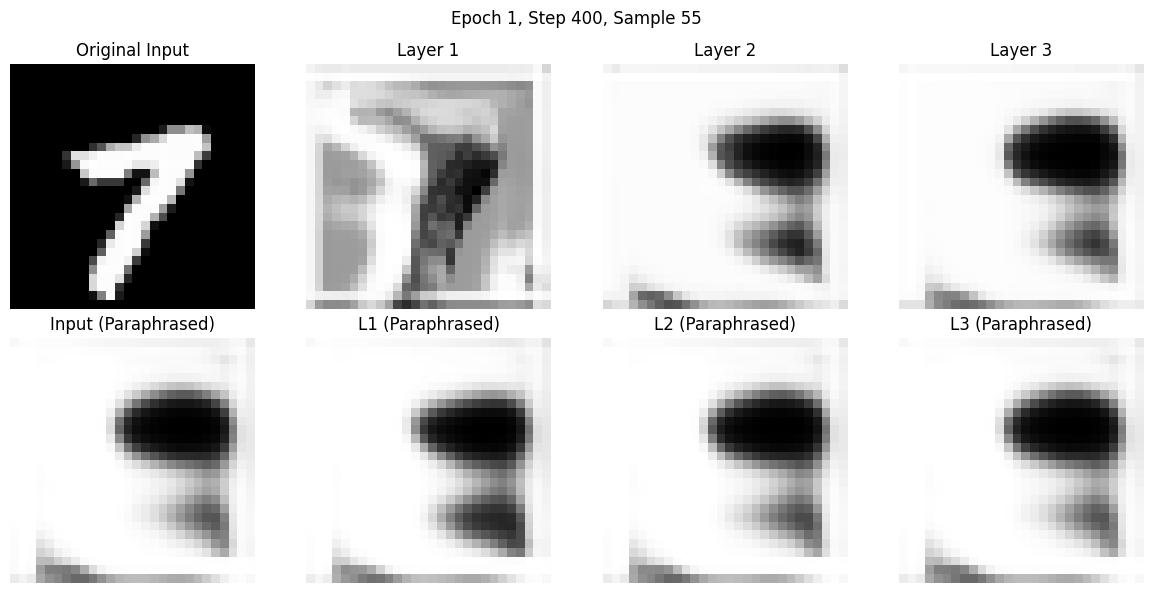

 43%|████▎     | 401/938 [19:52<27:49,  3.11s/it]


Layer Statistics (Paraphrase Prob: 100.0%):
Input:
  MSE: 1.9382
  Cosine Similarity: -0.1996
  Actual Paraphrase Rate: 100.0%
Layer 1:
  MSE: 0.0639
  Cosine Similarity: 0.9561
  Actual Paraphrase Rate: 100.0%
Layer 2:
  MSE: 0.0051
  Cosine Similarity: 0.9968
  Actual Paraphrase Rate: 100.0%
Layer 3:
  MSE: 0.0017
  Cosine Similarity: 0.9989
  Actual Paraphrase Rate: 100.0%


 85%|████████▌ | 800/938 [39:16<06:42,  2.91s/it]

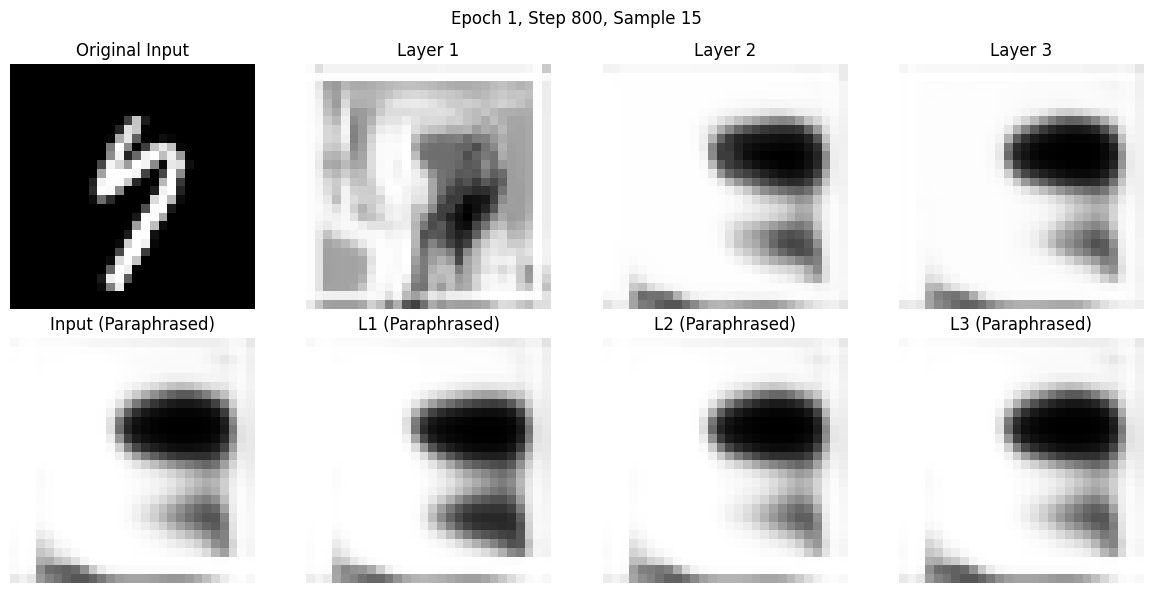

 85%|████████▌ | 801/938 [39:19<07:00,  3.07s/it]


Layer Statistics (Paraphrase Prob: 100.0%):
Input:
  MSE: 1.9318
  Cosine Similarity: -0.1990
  Actual Paraphrase Rate: 100.0%
Layer 1:
  MSE: 0.0598
  Cosine Similarity: 0.9590
  Actual Paraphrase Rate: 100.0%
Layer 2:
  MSE: 0.0029
  Cosine Similarity: 0.9982
  Actual Paraphrase Rate: 100.0%
Layer 3:
  MSE: 0.0014
  Cosine Similarity: 0.9991
  Actual Paraphrase Rate: 100.0%


100%|██████████| 938/938 [45:48<00:00,  2.93s/it]



Epoch 1 (Paraphrase Prob: 100.0%):
Train Loss: 2.3113, Train Acc: 10.71%, Test Acc: 11.39%


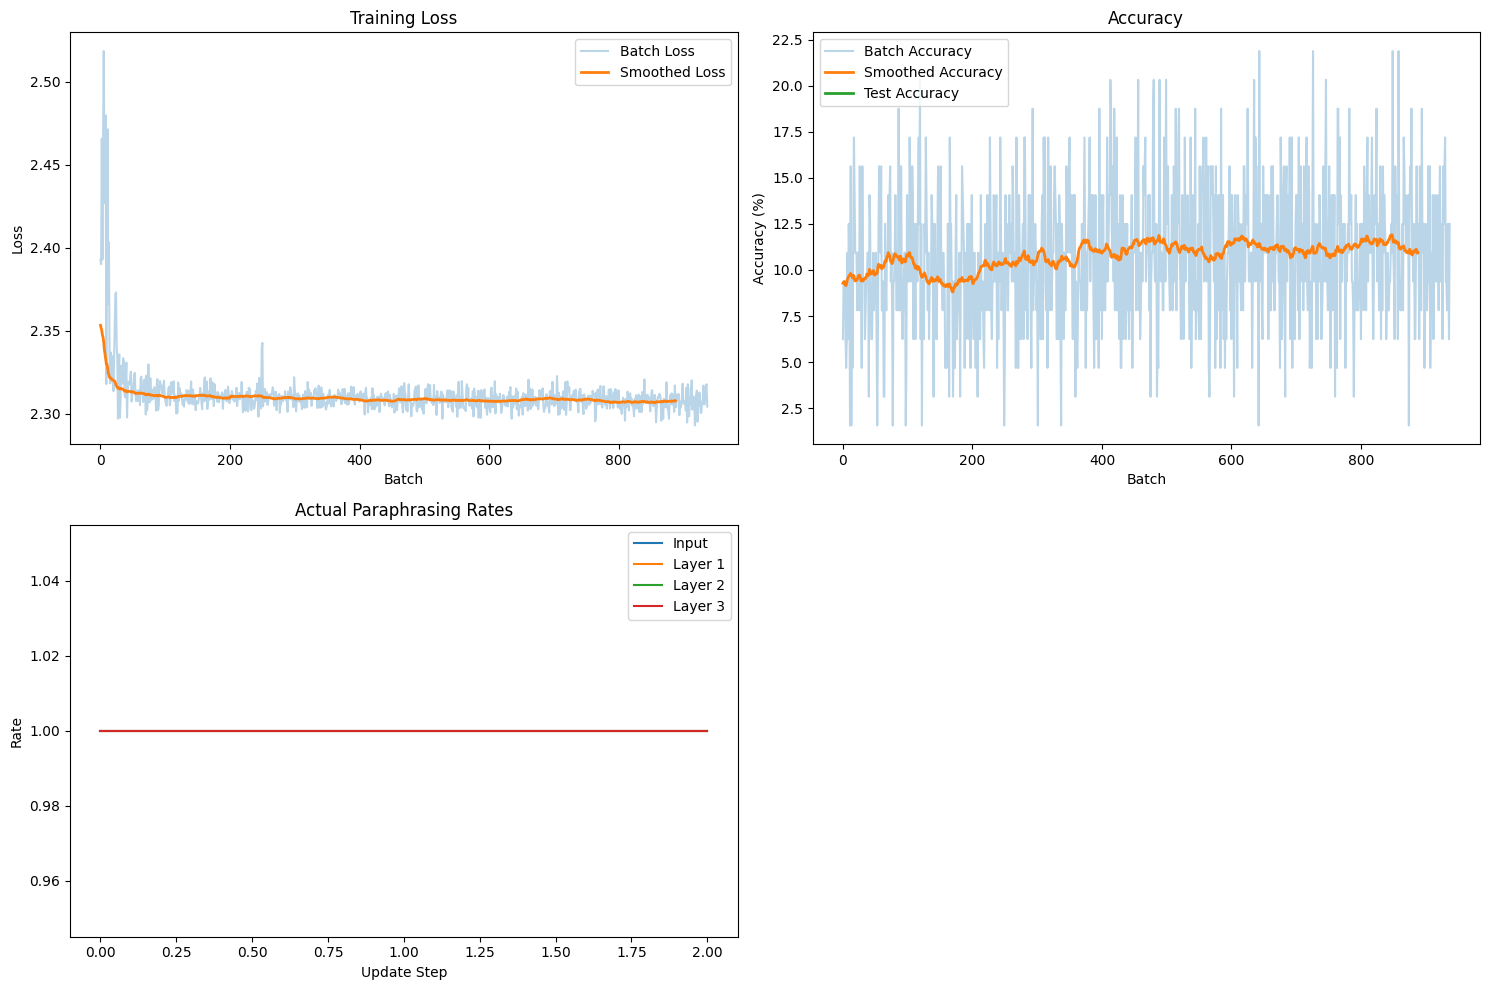

  0%|          | 0/938 [00:00<?, ?it/s]

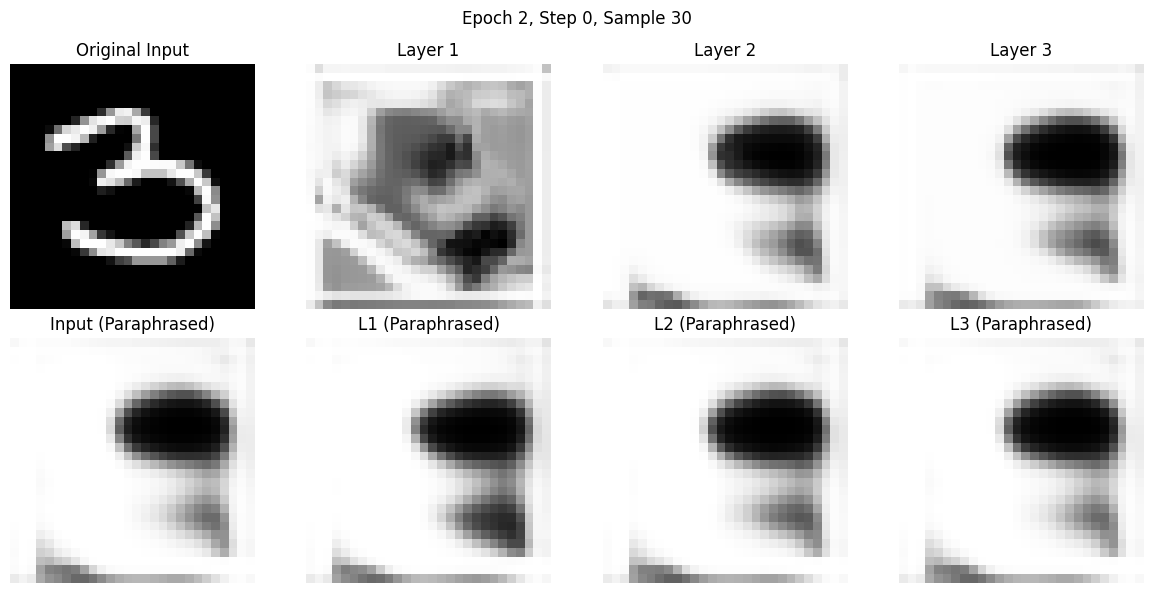

  0%|          | 1/938 [00:12<3:15:51, 12.54s/it]


Layer Statistics (Paraphrase Prob: 100.0%):
Input:
  MSE: 1.9351
  Cosine Similarity: -0.2104
  Actual Paraphrase Rate: 100.0%
Layer 1:
  MSE: 0.0581
  Cosine Similarity: 0.9603
  Actual Paraphrase Rate: 100.0%
Layer 2:
  MSE: 0.0026
  Cosine Similarity: 0.9984
  Actual Paraphrase Rate: 100.0%
Layer 3:
  MSE: 0.0014
  Cosine Similarity: 0.9992
  Actual Paraphrase Rate: 100.0%


 43%|████▎     | 400/938 [19:48<26:16,  2.93s/it]

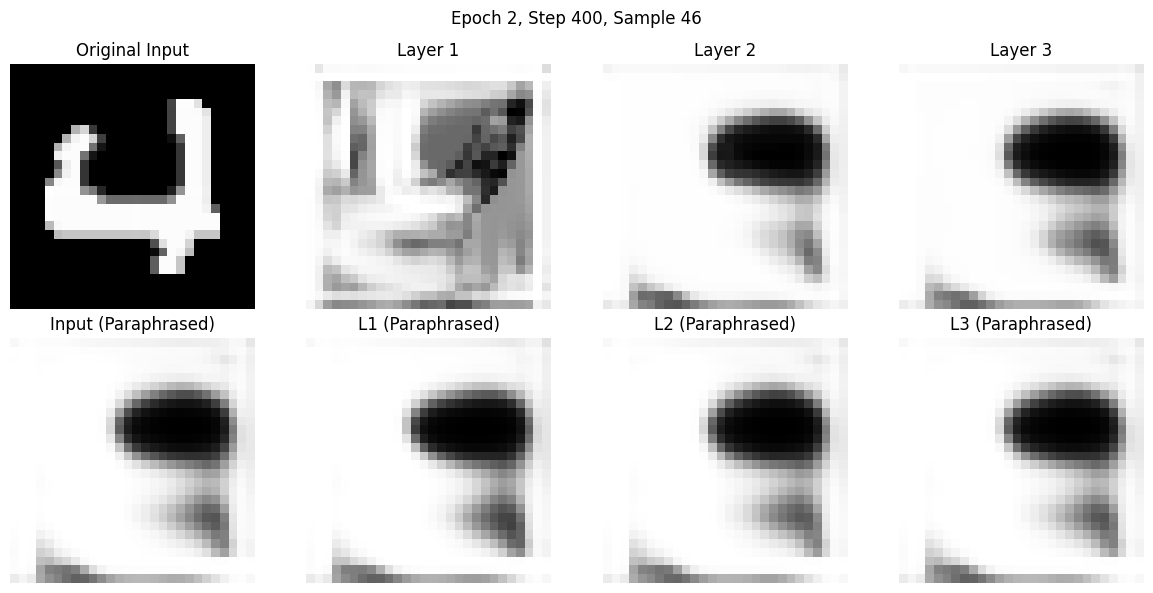

 43%|████▎     | 401/938 [19:52<27:49,  3.11s/it]


Layer Statistics (Paraphrase Prob: 100.0%):
Input:
  MSE: 1.9356
  Cosine Similarity: -0.1998
  Actual Paraphrase Rate: 100.0%
Layer 1:
  MSE: 0.0552
  Cosine Similarity: 0.9624
  Actual Paraphrase Rate: 100.0%
Layer 2:
  MSE: 0.0024
  Cosine Similarity: 0.9985
  Actual Paraphrase Rate: 100.0%
Layer 3:
  MSE: 0.0013
  Cosine Similarity: 0.9992
  Actual Paraphrase Rate: 100.0%


 85%|████████▌ | 800/938 [39:38<06:27,  2.81s/it]

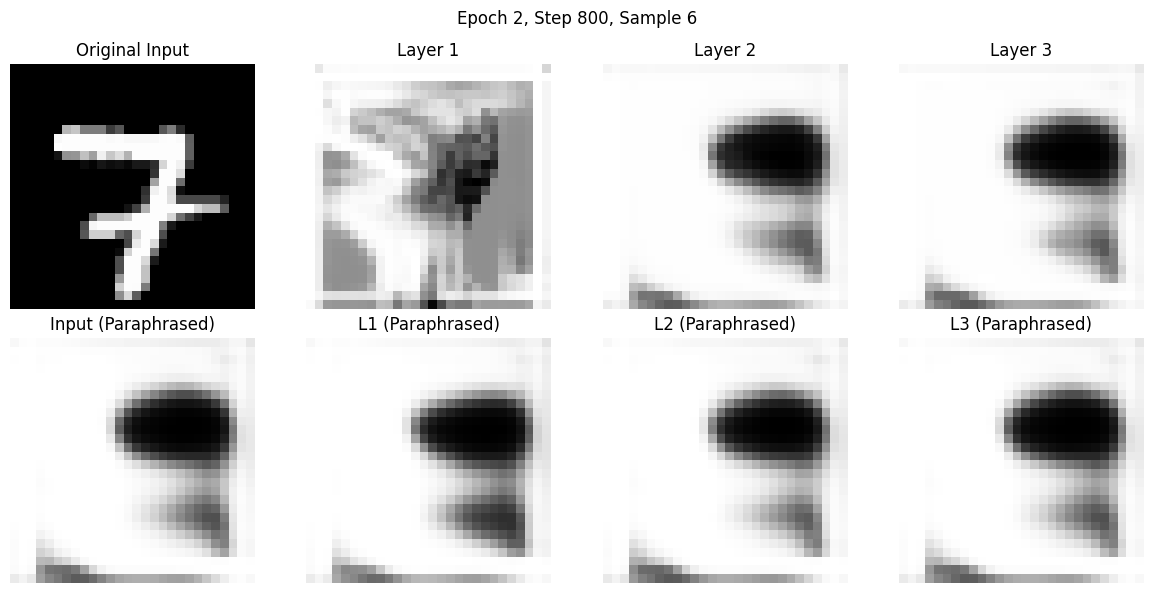

 85%|████████▌ | 801/938 [39:42<07:00,  3.07s/it]


Layer Statistics (Paraphrase Prob: 100.0%):
Input:
  MSE: 1.9367
  Cosine Similarity: -0.2000
  Actual Paraphrase Rate: 100.0%
Layer 1:
  MSE: 0.0533
  Cosine Similarity: 0.9639
  Actual Paraphrase Rate: 100.0%
Layer 2:
  MSE: 0.0023
  Cosine Similarity: 0.9986
  Actual Paraphrase Rate: 100.0%
Layer 3:
  MSE: 0.0012
  Cosine Similarity: 0.9992
  Actual Paraphrase Rate: 100.0%


100%|██████████| 938/938 [46:10<00:00,  2.95s/it]



Epoch 2 (Paraphrase Prob: 100.0%):
Train Loss: 2.3072, Train Acc: 11.24%, Test Acc: 11.25%


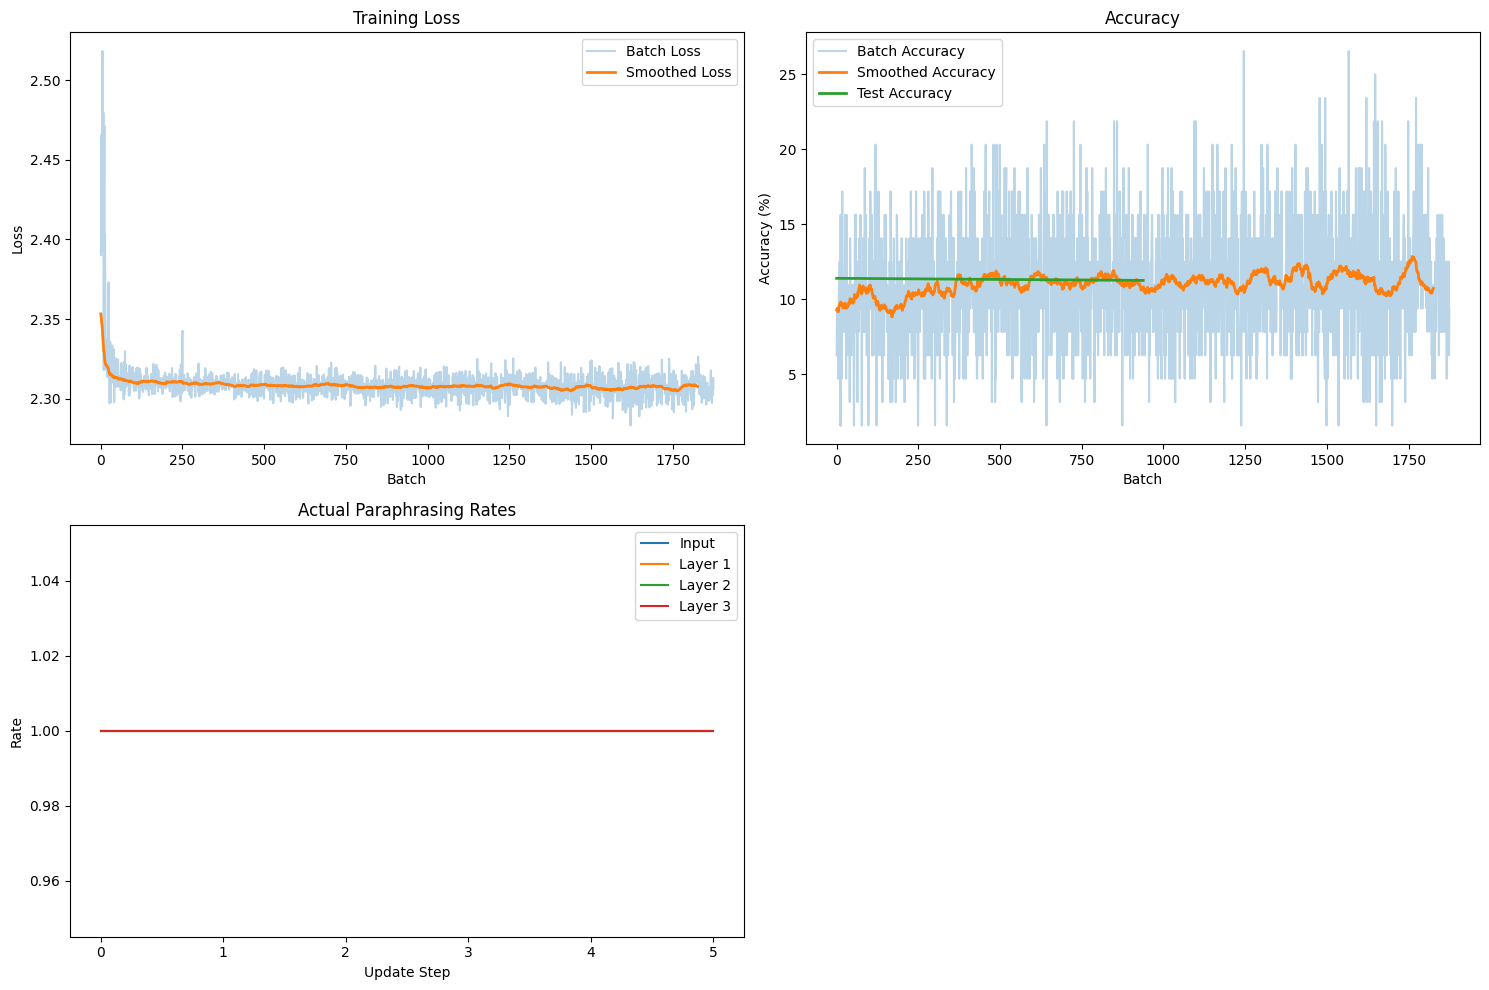

  0%|          | 0/938 [00:00<?, ?it/s]

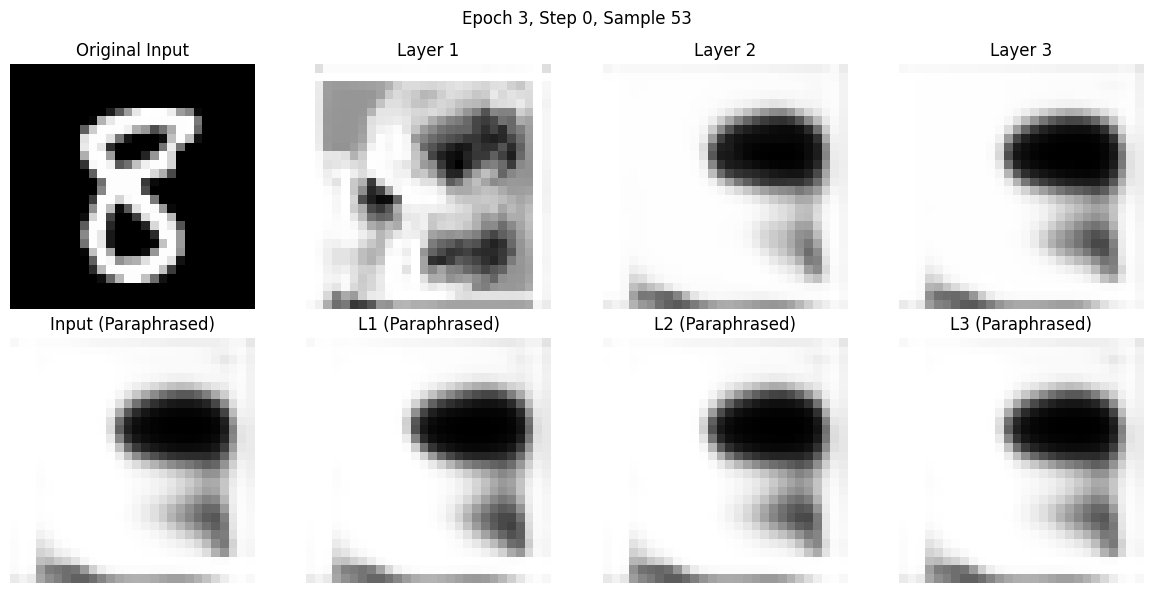

  0%|          | 1/938 [00:12<3:09:46, 12.15s/it]


Layer Statistics (Paraphrase Prob: 100.0%):
Input:
  MSE: 1.9358
  Cosine Similarity: -0.1945
  Actual Paraphrase Rate: 100.0%
Layer 1:
  MSE: 0.0528
  Cosine Similarity: 0.9643
  Actual Paraphrase Rate: 100.0%
Layer 2:
  MSE: 0.0025
  Cosine Similarity: 0.9985
  Actual Paraphrase Rate: 100.0%
Layer 3:
  MSE: 0.0016
  Cosine Similarity: 0.9990
  Actual Paraphrase Rate: 100.0%


 43%|████▎     | 400/938 [19:08<26:47,  2.99s/it]

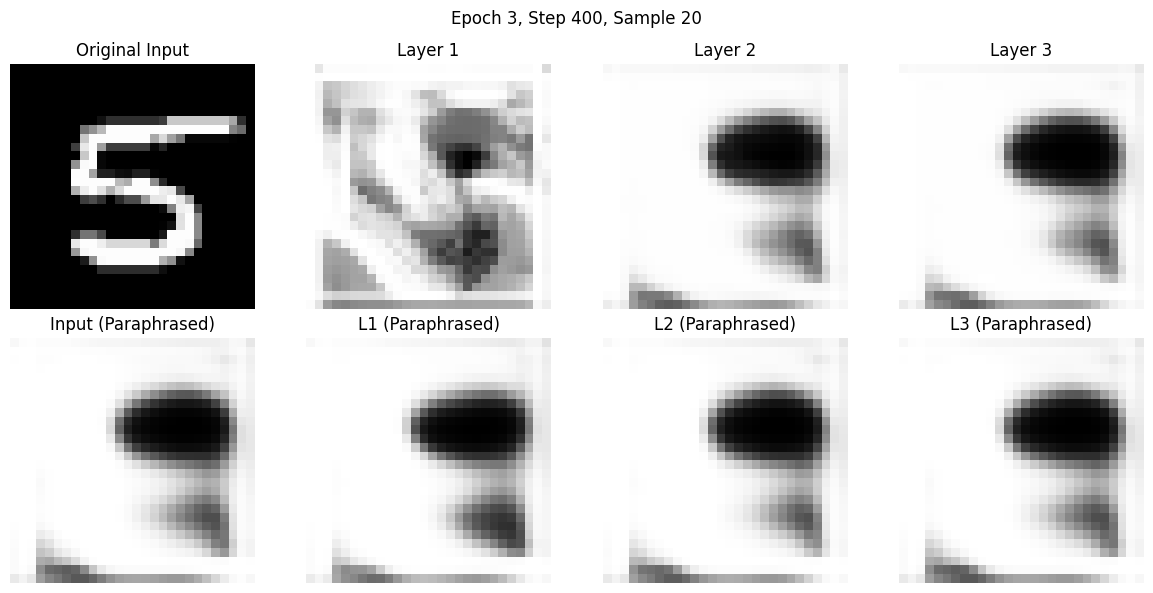

 43%|████▎     | 401/938 [19:11<27:53,  3.12s/it]


Layer Statistics (Paraphrase Prob: 100.0%):
Input:
  MSE: 1.9338
  Cosine Similarity: -0.2011
  Actual Paraphrase Rate: 100.0%
Layer 1:
  MSE: 0.0515
  Cosine Similarity: 0.9652
  Actual Paraphrase Rate: 100.0%
Layer 2:
  MSE: 0.0023
  Cosine Similarity: 0.9986
  Actual Paraphrase Rate: 100.0%
Layer 3:
  MSE: 0.0012
  Cosine Similarity: 0.9993
  Actual Paraphrase Rate: 100.0%


 85%|████████▌ | 800/938 [39:07<06:40,  2.91s/it]

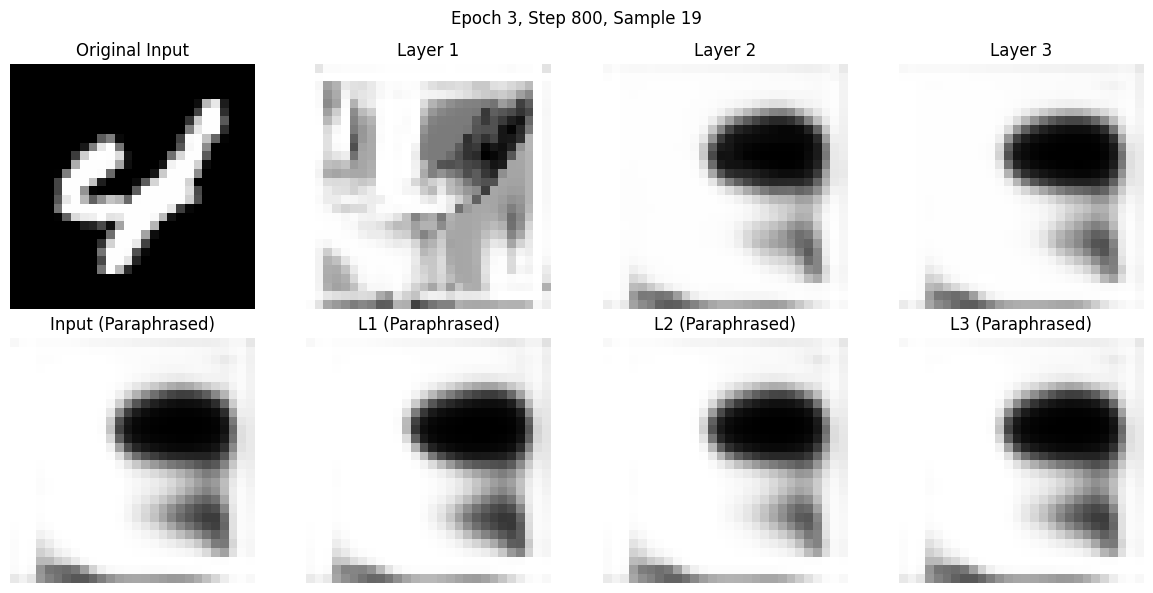

 85%|████████▌ | 801/938 [39:11<07:32,  3.30s/it]


Layer Statistics (Paraphrase Prob: 100.0%):
Input:
  MSE: 1.9366
  Cosine Similarity: -0.2000
  Actual Paraphrase Rate: 100.0%
Layer 1:
  MSE: 0.0508
  Cosine Similarity: 0.9658
  Actual Paraphrase Rate: 100.0%
Layer 2:
  MSE: 0.0022
  Cosine Similarity: 0.9987
  Actual Paraphrase Rate: 100.0%
Layer 3:
  MSE: 0.0011
  Cosine Similarity: 0.9993
  Actual Paraphrase Rate: 100.0%


100%|██████████| 938/938 [46:02<00:00,  2.95s/it]



Epoch 3 (Paraphrase Prob: 100.0%):
Train Loss: 2.3067, Train Acc: 11.24%, Test Acc: 11.93%


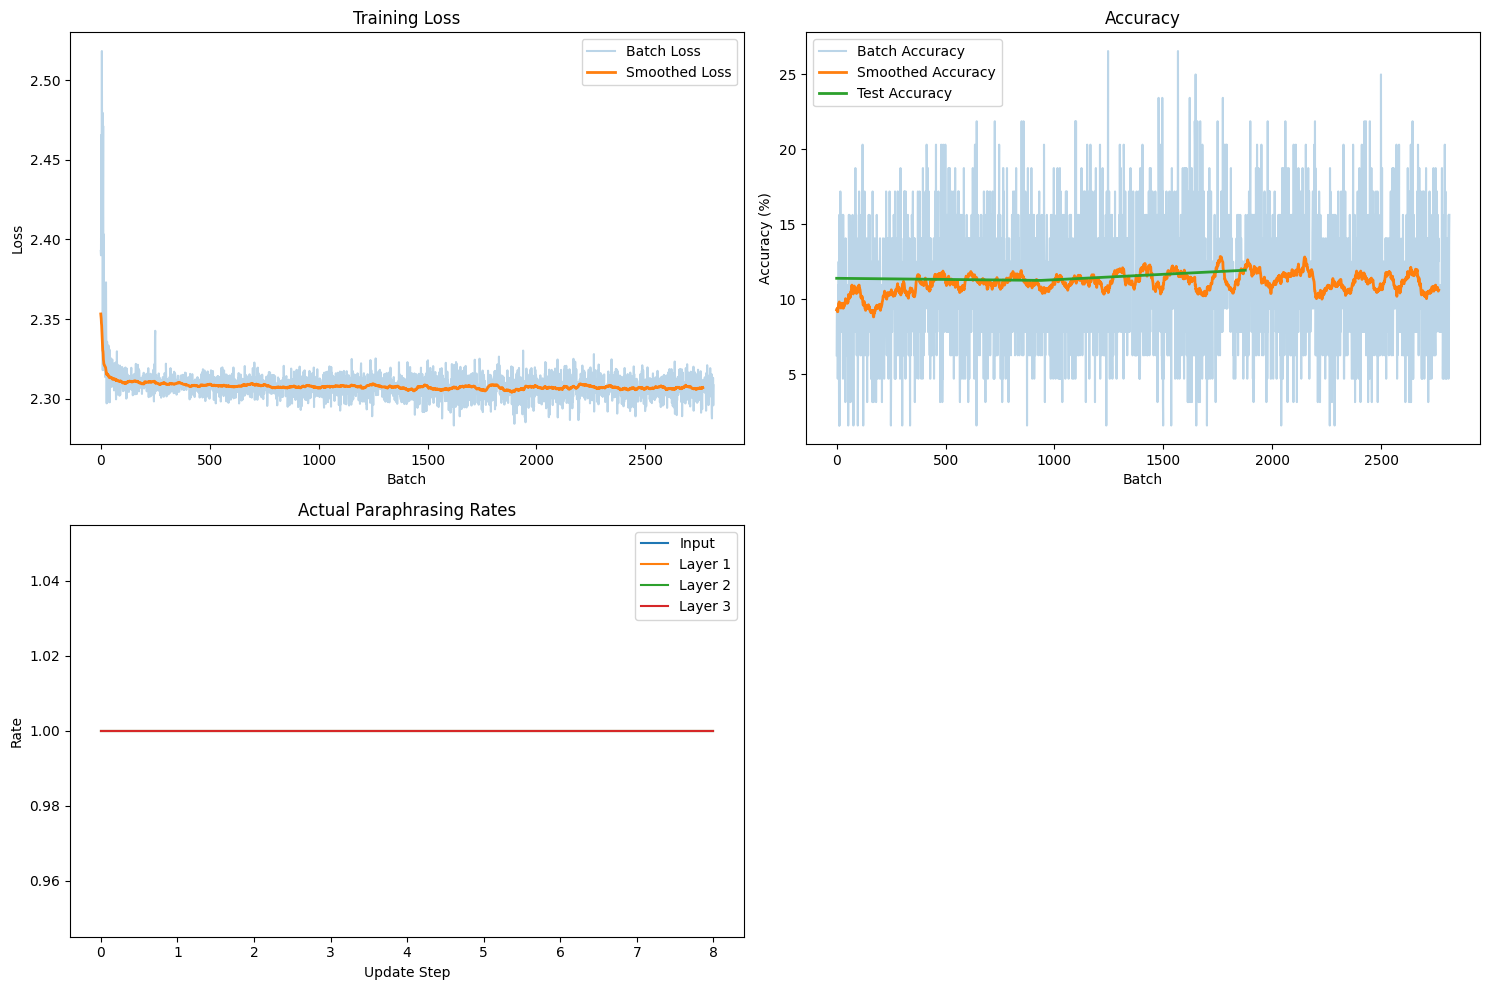

  0%|          | 0/938 [00:00<?, ?it/s]

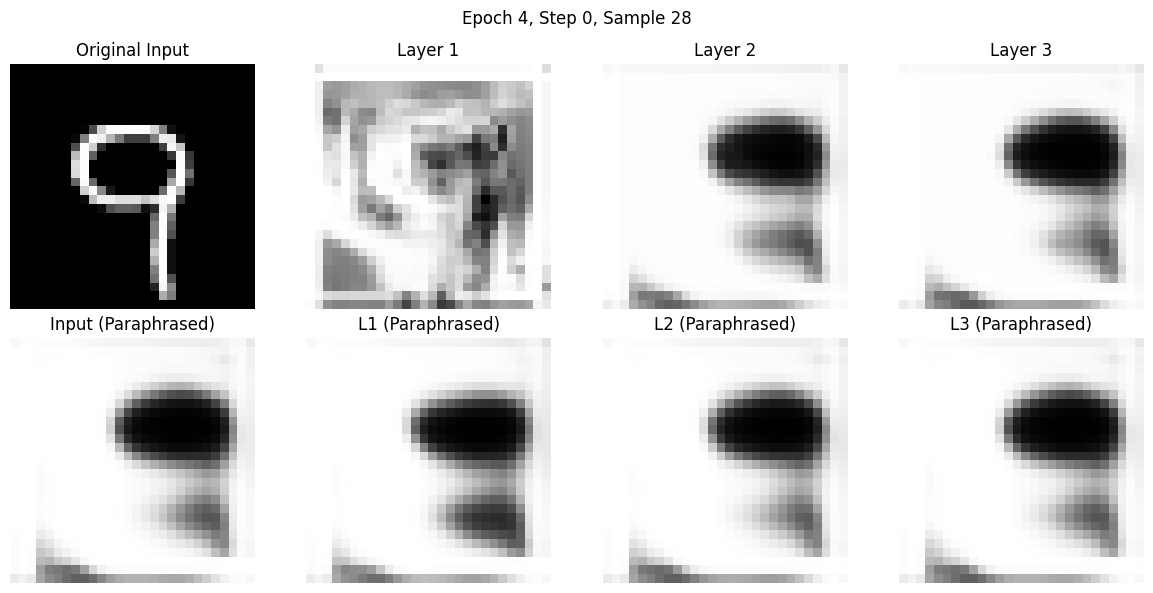

  0%|          | 1/938 [00:12<3:08:00, 12.04s/it]


Layer Statistics (Paraphrase Prob: 100.0%):
Input:
  MSE: 1.9001
  Cosine Similarity: -0.2106
  Actual Paraphrase Rate: 100.0%
Layer 1:
  MSE: 0.0504
  Cosine Similarity: 0.9660
  Actual Paraphrase Rate: 100.0%
Layer 2:
  MSE: 0.0019
  Cosine Similarity: 0.9988
  Actual Paraphrase Rate: 100.0%
Layer 3:
  MSE: 0.0011
  Cosine Similarity: 0.9993
  Actual Paraphrase Rate: 100.0%


 43%|████▎     | 400/938 [19:44<27:06,  3.02s/it]

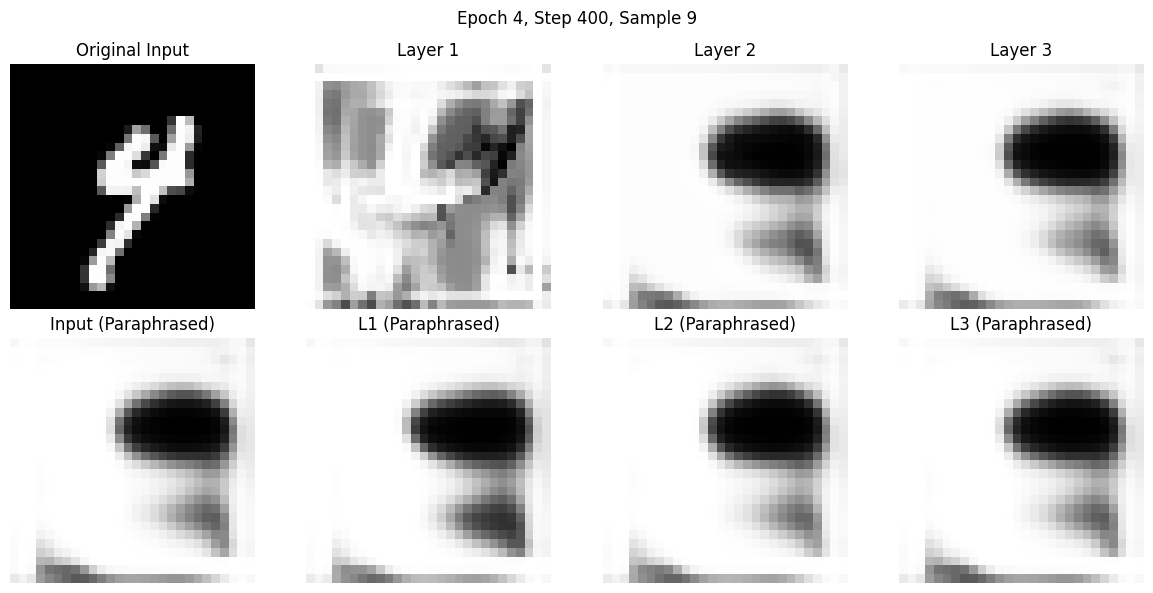

 43%|████▎     | 401/938 [19:47<28:22,  3.17s/it]


Layer Statistics (Paraphrase Prob: 100.0%):
Input:
  MSE: 1.9351
  Cosine Similarity: -0.2021
  Actual Paraphrase Rate: 100.0%
Layer 1:
  MSE: 0.0497
  Cosine Similarity: 0.9666
  Actual Paraphrase Rate: 100.0%
Layer 2:
  MSE: 0.0021
  Cosine Similarity: 0.9987
  Actual Paraphrase Rate: 100.0%
Layer 3:
  MSE: 0.0011
  Cosine Similarity: 0.9994
  Actual Paraphrase Rate: 100.0%


 85%|████████▌ | 800/938 [39:03<06:49,  2.97s/it]

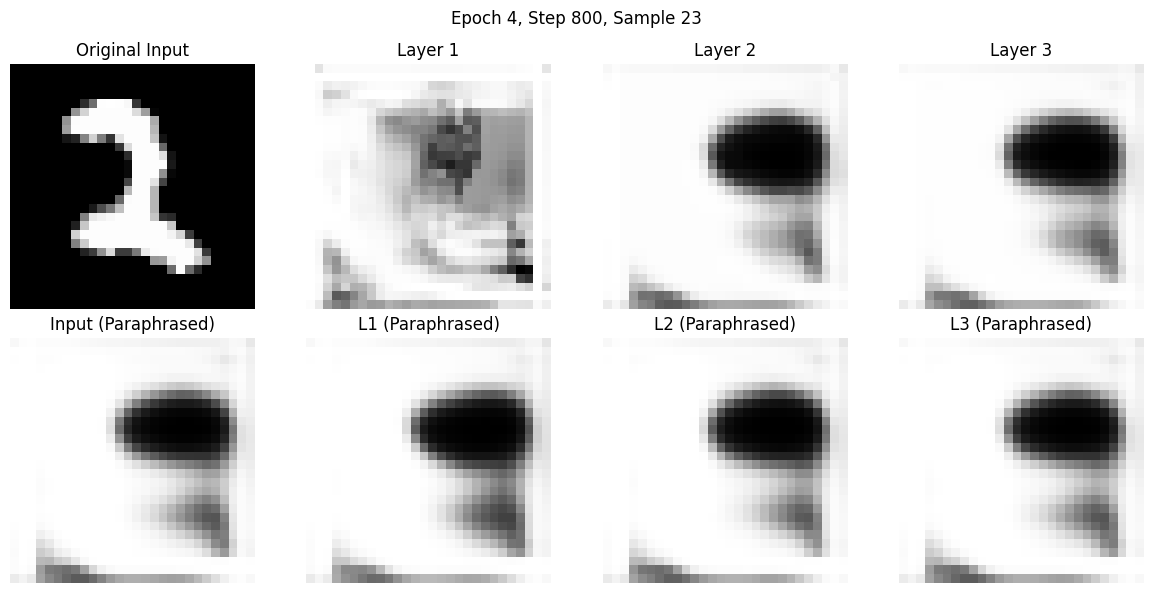

 85%|████████▌ | 801/938 [39:07<07:24,  3.25s/it]


Layer Statistics (Paraphrase Prob: 100.0%):
Input:
  MSE: 1.9354
  Cosine Similarity: -0.2013
  Actual Paraphrase Rate: 100.0%
Layer 1:
  MSE: 0.0491
  Cosine Similarity: 0.9670
  Actual Paraphrase Rate: 100.0%
Layer 2:
  MSE: 0.0021
  Cosine Similarity: 0.9987
  Actual Paraphrase Rate: 100.0%
Layer 3:
  MSE: 0.0010
  Cosine Similarity: 0.9994
  Actual Paraphrase Rate: 100.0%


100%|██████████| 938/938 [45:54<00:00,  2.94s/it]



Epoch 4 (Paraphrase Prob: 100.0%):
Train Loss: 2.3066, Train Acc: 11.24%, Test Acc: 11.55%


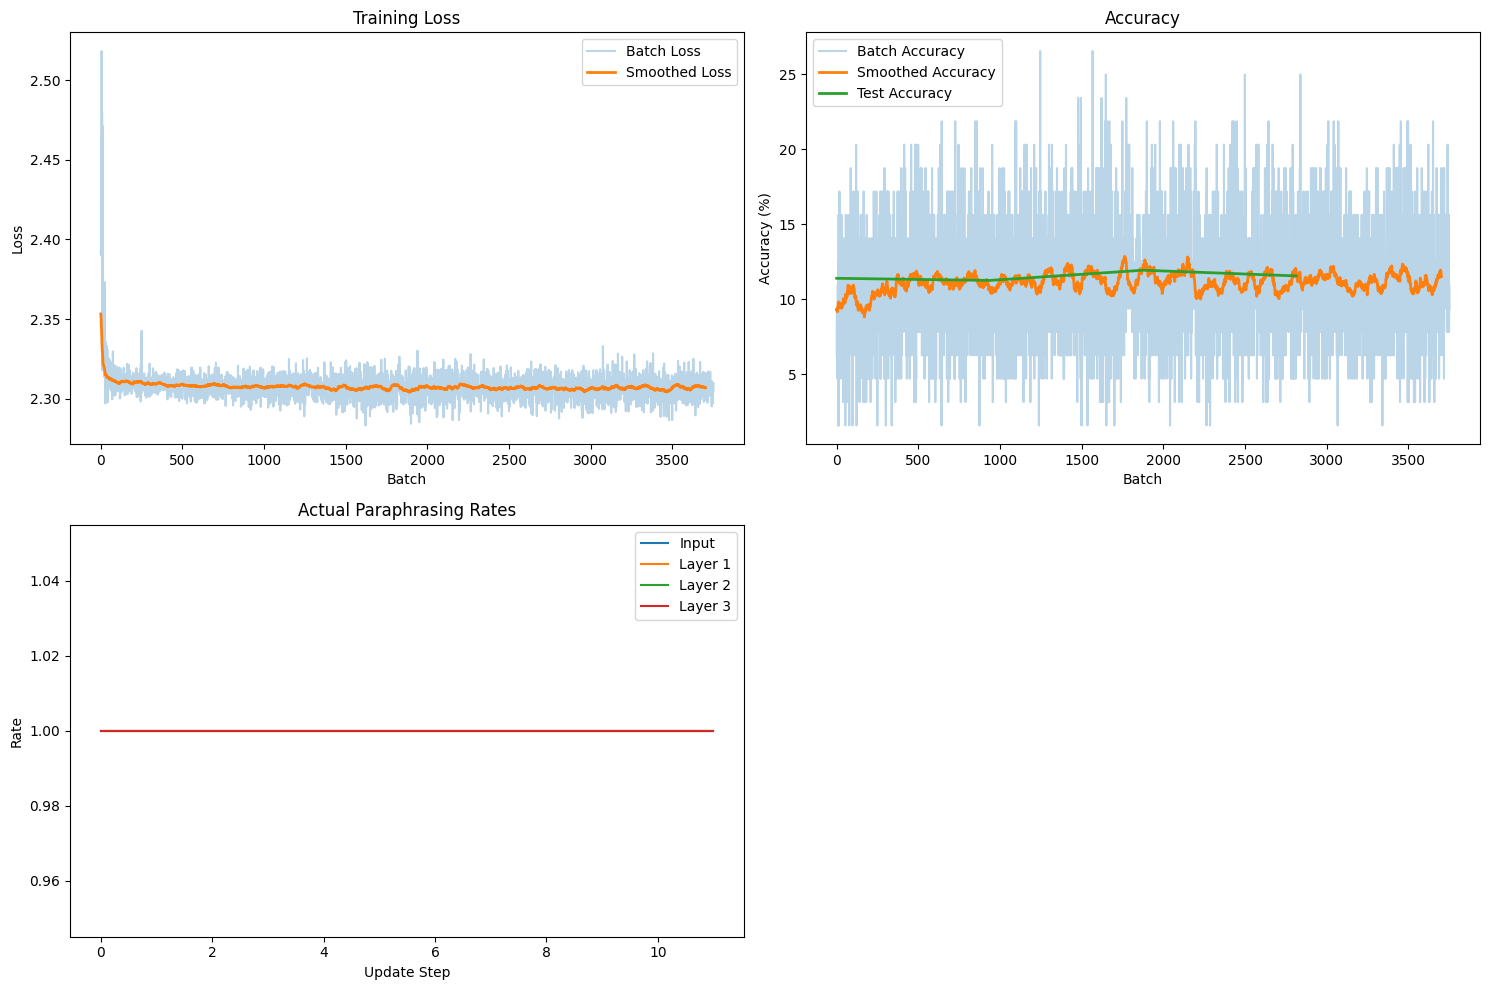

  0%|          | 0/938 [00:00<?, ?it/s]

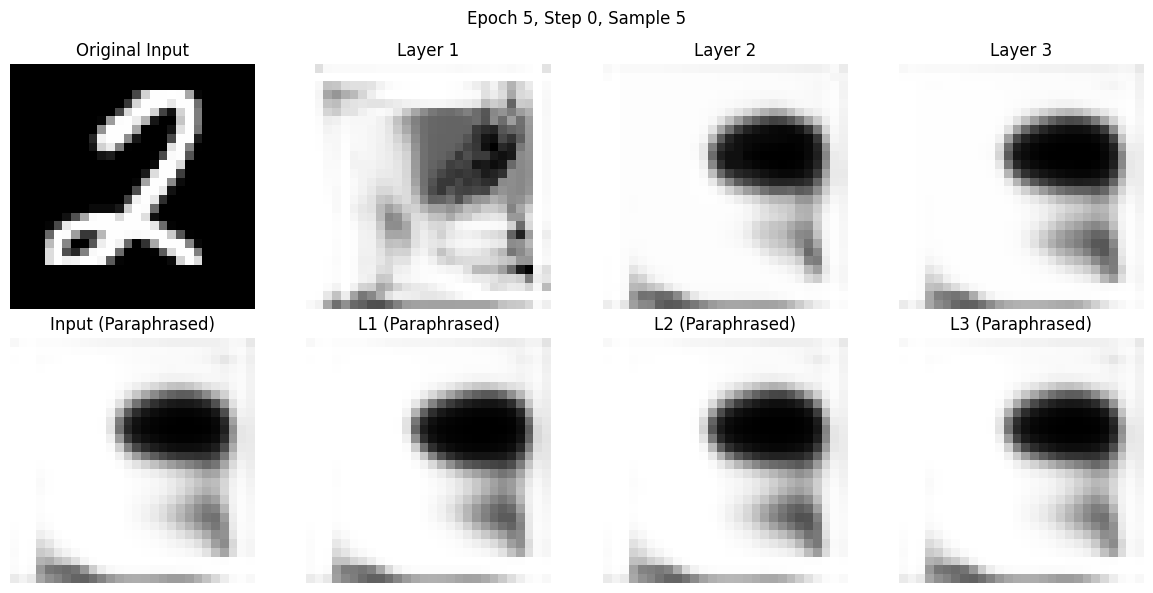

  0%|          | 1/938 [00:14<3:40:36, 14.13s/it]


Layer Statistics (Paraphrase Prob: 100.0%):
Input:
  MSE: 1.9407
  Cosine Similarity: -0.2087
  Actual Paraphrase Rate: 100.0%
Layer 1:
  MSE: 0.0474
  Cosine Similarity: 0.9681
  Actual Paraphrase Rate: 100.0%
Layer 2:
  MSE: 0.0018
  Cosine Similarity: 0.9989
  Actual Paraphrase Rate: 100.0%
Layer 3:
  MSE: 0.0008
  Cosine Similarity: 0.9995
  Actual Paraphrase Rate: 100.0%


 43%|████▎     | 400/938 [20:18<27:55,  3.11s/it]

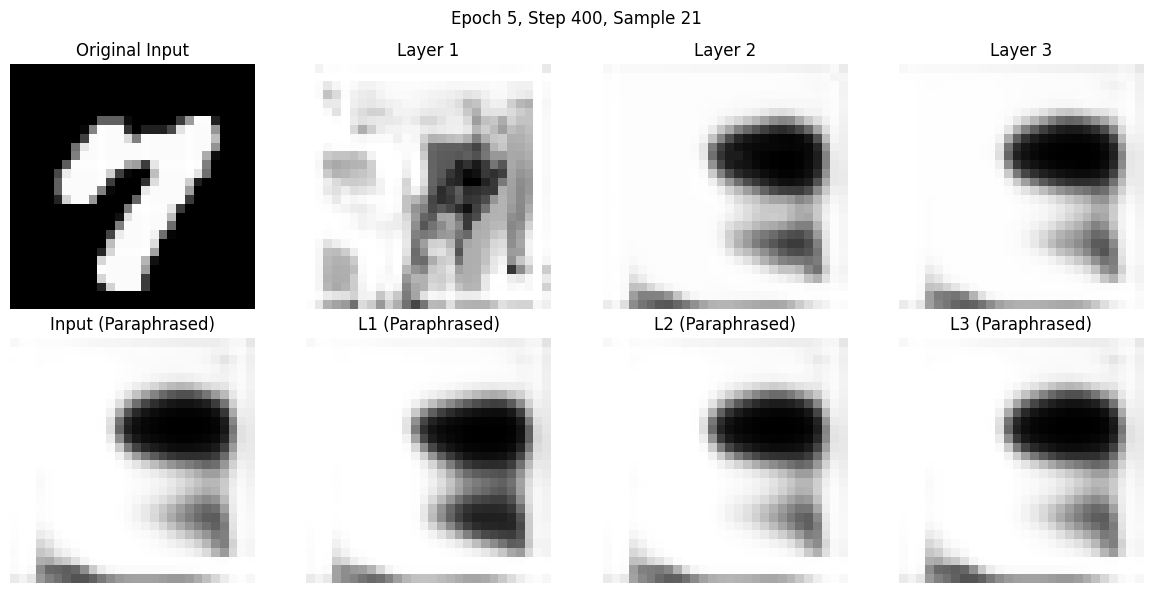

 43%|████▎     | 401/938 [20:22<29:10,  3.26s/it]


Layer Statistics (Paraphrase Prob: 100.0%):
Input:
  MSE: 1.9308
  Cosine Similarity: -0.2042
  Actual Paraphrase Rate: 100.0%
Layer 1:
  MSE: 0.0486
  Cosine Similarity: 0.9673
  Actual Paraphrase Rate: 100.0%
Layer 2:
  MSE: 0.0019
  Cosine Similarity: 0.9988
  Actual Paraphrase Rate: 100.0%
Layer 3:
  MSE: 0.0009
  Cosine Similarity: 0.9994
  Actual Paraphrase Rate: 100.0%


 85%|████████▌ | 800/938 [40:22<06:50,  2.97s/it]

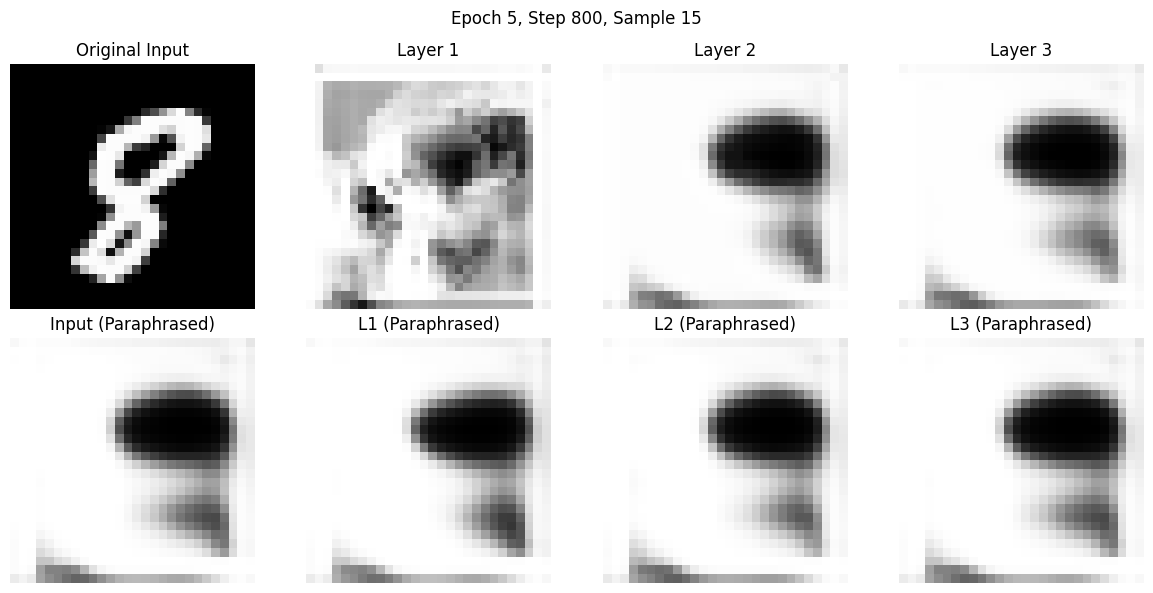

 85%|████████▌ | 801/938 [40:25<07:10,  3.14s/it]


Layer Statistics (Paraphrase Prob: 100.0%):
Input:
  MSE: 1.9335
  Cosine Similarity: -0.2031
  Actual Paraphrase Rate: 100.0%
Layer 1:
  MSE: 0.0482
  Cosine Similarity: 0.9676
  Actual Paraphrase Rate: 100.0%
Layer 2:
  MSE: 0.0019
  Cosine Similarity: 0.9988
  Actual Paraphrase Rate: 100.0%
Layer 3:
  MSE: 0.0009
  Cosine Similarity: 0.9994
  Actual Paraphrase Rate: 100.0%


100%|██████████| 938/938 [47:18<00:00,  3.03s/it]



Epoch 5 (Paraphrase Prob: 100.0%):
Train Loss: 2.3064, Train Acc: 11.24%, Test Acc: 11.44%


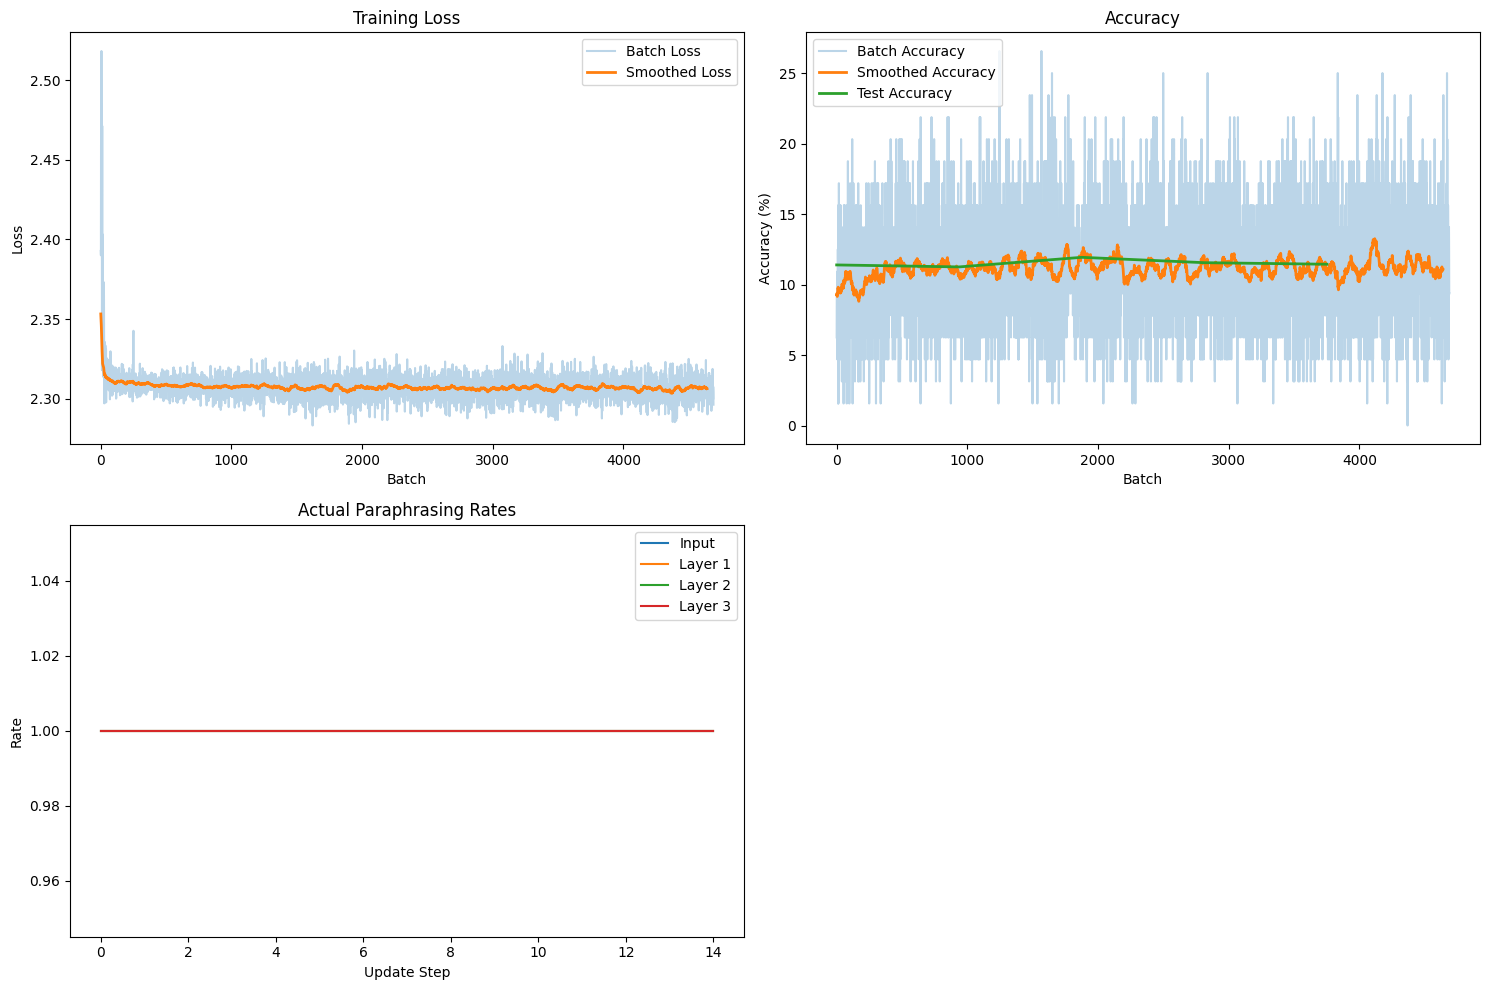

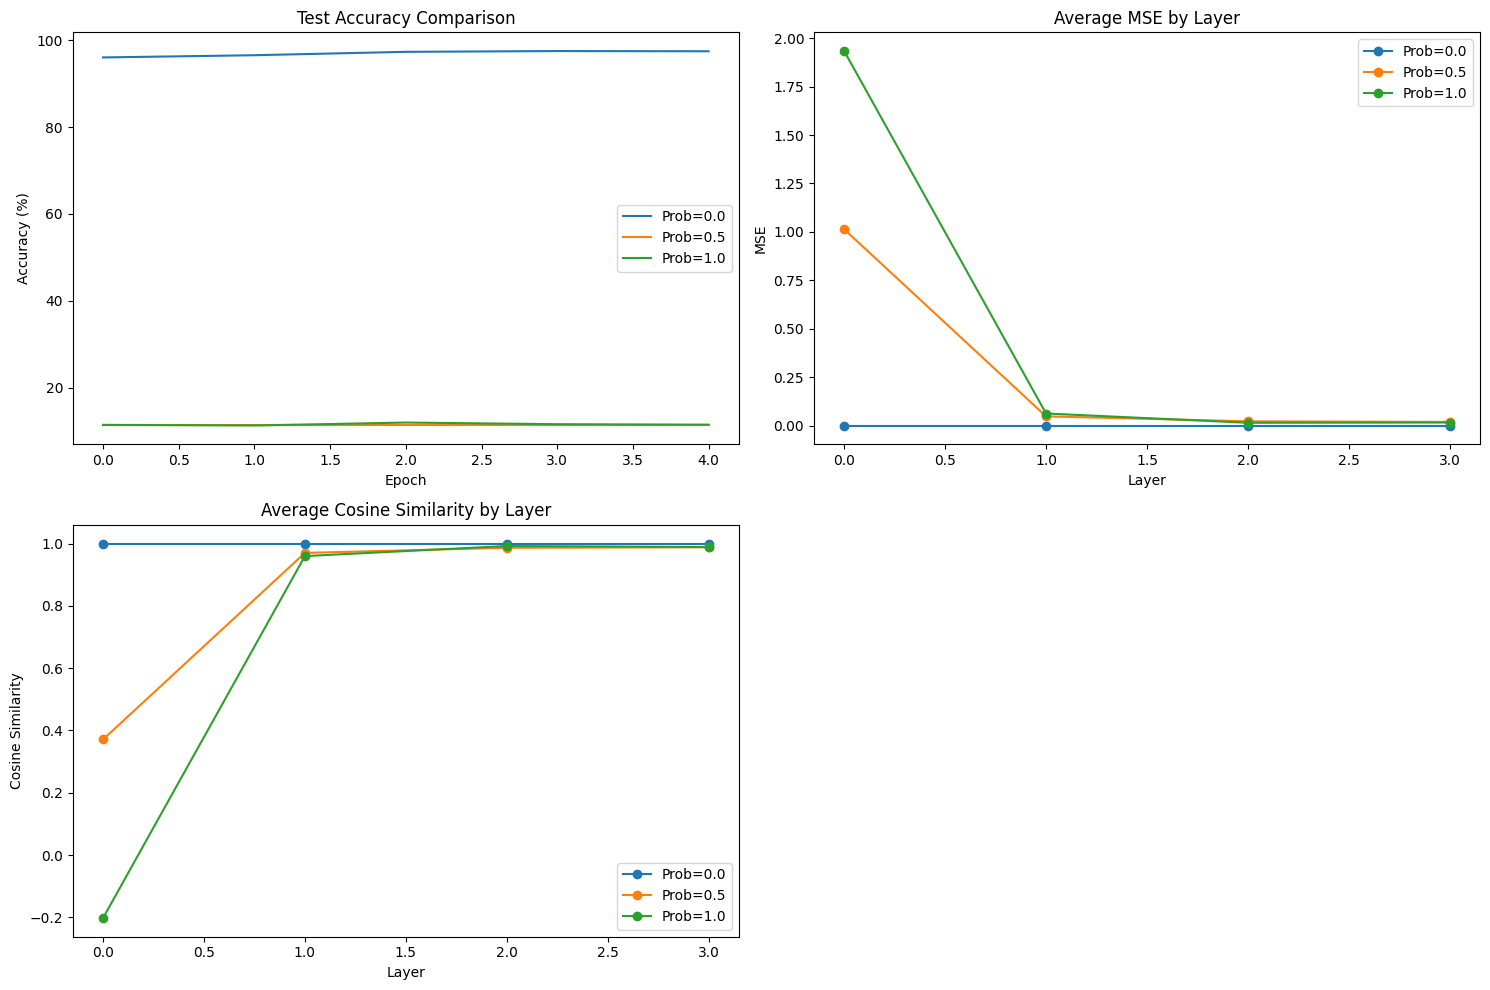


Training complete! Models and metrics saved in: c:\Users\plogo\Documents\AI work\Paraphraser\Paraphrasing_MNIST\models


In [9]:
# main

def main():
    # Setup device and paths
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f'Using device: {device}')
    
    root_dir = Path(os.path.abspath(''))
    data_dir = root_dir / 'data'
    models_dir = root_dir / 'models'
    models_dir.mkdir(exist_ok=True)
    
    # Setup data loaders
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])
    
    train_dataset = torchvision.datasets.MNIST(root=str(data_dir), train=True,
                                             download=True, transform=transform)
    test_dataset = torchvision.datasets.MNIST(root=str(data_dir), train=False,
                                            download=True, transform=transform)
    
    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, 
                            pin_memory=True, num_workers=4)
    test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, 
                            pin_memory=True, num_workers=4)
    
    # Load or train prerequisite models
    classifier = PretrainedClassifier()
    paraphraser = ImageParaphraser()
    
    # Load/train classifier
    classifier_path = models_dir / 'initial_classifier.pth'
    if classifier_path.exists():
        print("Loading pretrained classifier...")
        classifier.load_state_dict(torch.load(classifier_path, map_location=device))
    else:
        print("Training initial classifier...")
        classifier.to(device)
        train_classifier(classifier, train_loader, test_loader, device)
        torch.save(classifier.state_dict(), classifier_path)
    
    classifier.to(device)
    classifier.eval()
    
    # Load/train paraphraser
    paraphraser_path = models_dir / 'paraphraser.pth'
    if paraphraser_path.exists():
        print("Loading pretrained paraphraser...")
        paraphraser.load_state_dict(torch.load(paraphraser_path, map_location=device))
    else:
        print("Training paraphraser...")
        paraphraser.to(device)
        train_paraphraser(paraphraser, classifier, train_loader, device)
        torch.save(paraphraser.state_dict(), paraphraser_path)
    
    paraphraser.to(device)
    paraphraser.eval()
    
    # Train interpretable classifiers with different paraphrasing probabilities
    paraphrase_probs = [0.0, 0.5, 1.0]  # 0%, 50%, 100%
    all_metrics = []
    
    for prob in paraphrase_probs:
        print(f"\nTraining classifier with {prob * 100:.1f}% paraphrasing probability")
        model = InterpretableClassifier()
        metrics = train_interpretable_classifier(
            model, 
            paraphraser,
            train_loader, 
            test_loader, 
            paraphrase_prob=prob,
            device=device,
            save_dir=str(models_dir)
        )
        all_metrics.append(metrics)
        
        # Save final model and metrics. Saves separate models for each paraphrasing probability given
        torch.save(model.state_dict(), 
                  models_dir / f'interpretable_classifier_p{prob:.2f}.pth')
        torch.save(metrics, 
                  models_dir / f'training_metrics_p{prob:.2f}.pth')
    
    # Compare results
    compare_training_results(all_metrics)
    
    print("\nTraining complete! Models and metrics saved in:", models_dir)

if __name__ == "__main__":
    main()